# Visualization of Stock Trading

In [1]:
# import libraries
import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns
import datetime
import pandas_datareader.data as web


import matplotlib.pyplot as plt

import logging
import coloredlogs

from train import *
from evaluate import show_eval_result

# Altair:
# in case of error on notebook: Istll vega_datasets
#conda install -c conda-forge altair vega_datasets notebook vega
#see also https://altair-viz.github.io/getting_started/installation.html
alt.renderers.enable('notebook')

Using TensorFlow backend.


[[0.5        0.5        0.5        0.5        0.00247262 0.99330715]]
(1, 6)


RendererRegistry.enable('notebook')

## Set relevant parameters
 - Window-Size: cutout of stock data that agent gets as state for his decision making
 - ep_count: # of epochs
 - Model Name (hint: model saved automatically after 10 epochs)
 - Pretrained: Load Pretrained Model or create new one

In [2]:
window_size = 15
batch_size = 20 #16
ep_count = 100 # 3-5 for debugging, otherwise 20-100
model_name = 'model_w15v2'
pretrained = False
debug = False

## Load Datasets into pandas DataFrame

<Figure size 432x288 with 0 Axes>

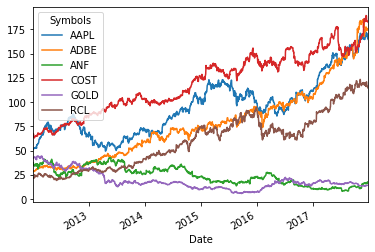

In [3]:
# Loading Train Data
# Setting Start and Enddate for Validation

start_train= datetime.datetime(2012, 1, 1)
end_train = datetime.datetime(2018, 1, 1)
start_val = end_train
end_val = datetime.datetime.now()


# Load Test Data

# Load several stocks
df_train = web.DataReader(['ADBE', 'AAPL', 'RCL', 'COST', 'ANF', 'GOLD'],'yahoo',
                               start=start_train, end=end_train)['Adj Close']

df2_train = web.DataReader('GOLD','yahoo',
                               start=start_train, #start_train
                               end=end_train) #end_train


df_val = web.DataReader(['ADBE', 'AAPL', 'RCL', 'COST', 'ANF', 'GOLD'],'yahoo',
                               start=start_val, #start_train
                               end=end_val)['Adj Close'] #end_val
df2_val = web.DataReader('GOLD','yahoo',
                               start=start_val, #start_val
                               end=end_val)  #end_val


# Convert df2_test to list
df2_train_list = list(df2_train['Adj Close'])
df2_val_list = list(df2_val['Adj Close'])

plt.figure();
df_train.plot();

## Training of Model
 - List of stocks (loaded above) is shuffled in every epoch

I1004 08:42:10.554670 15928 train.py:156] switching to TensorFlow for CPU
2019-10-04 08:42:10 PC-Stefan root[16684] DEBUG switching to TensorFlow for CPU
W1004 08:42:10.656150 15928 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

2019-10-04 08:42:10 PC-Stefan tensorflow[16684] WARNING From C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1004 08:42:10.658187 15928 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

2019-10-04 08:42:10 PC-Stefan tensorflow[16684] WARNING From C:\ProgramData\Anaconda3\envs\2019\lib\site

Symbols           RCL       AAPL       COST       GOLD        ANF       ADBE
Date                                                                        
2012-01-03  42.415550  67.481003  28.570000  51.269413  22.028625  37.513138
2012-01-04  43.049412  67.058258  28.280001  51.544937  22.215746  36.262455
2012-01-05  42.870869  66.412148  28.480000  52.117188  22.113682  35.211254
2012-01-06  42.442329  64.713181  28.719999  52.662014  21.688419  34.459309
2012-01-09  42.594097  63.022152  28.530001  52.578468  21.756460  35.011761


Episode 1/100:   0%|          | 0/1508 [00:00<?, ?it/s]W1004 08:42:10.779020 15928 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\keras\backend\tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

2019-10-04 08:42:10 PC-Stefan tensorflow[16684] WARNING From C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\keras\backend\tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1004 08:42:10.789113 15928 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

2019-10-04 08:42:10 PC-Stefan tensorflow[16684] WARNING From C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.

Symbols          COST       ADBE       AAPL        ANF       GOLD        RCL
Date                                                                        
2012-01-03  37.513138  42.415550  67.481003  51.269413  28.570000  22.028625
2012-01-04  36.262455  43.049412  67.058258  51.544937  28.280001  22.215746
2012-01-05  35.211254  42.870869  66.412148  52.117188  28.480000  22.113682
2012-01-06  34.459309  42.442329  64.713181  52.662014  28.719999  21.688419
2012-01-09  35.011761  42.594097  63.022152  52.578468  28.530001  21.756460


Episode 2/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.62it/s]
I1004 08:44:14.416344 15928 train.py:147] Episode 2/100 - Train Position: -$2.83  Val Position: +$36.11  Train Loss: 0.0151  (~16.8231 secs)
2019-10-04 08:44:14 PC-Stefan root[16684] INFO Episode 2/100 - Train Position: -$2.83  Val Position: +$36.11  Train Loss: 0.0151  (~16.8231 secs)
Episode 2/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.60it/s]
I1004 08:44:31.370306 15928 train.py:147] Episode 2/100 - Train Position: -$10.42  Val Position: -$6.30  Train Loss: 0.0122  (~16.8317 secs)
2019-10-04 08:44:31 PC-Stefan root[16684] INFO Episode 2/100 - Train Position: -$10.42  Val Position: -$6.30  Train Loss: 0.0122  (~16.8317 secs)
Episode 2/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.08it/s]
I1004 08:44:48.430143 15928 train.py:147] Episode 2/100 - Train Position: +$31.45  Val Position: -$4.81  Train Loss: 0.0143  (~16.9312 secs)
2019-10-04 08:44:48 PC-Stefan root[16684] INFO Episode 2/100 - Train Position: +$31.

Symbols           ANF       ADBE        RCL       COST       GOLD       AAPL
Date                                                                        
2012-01-03  22.028625  28.570000  51.269413  42.415550  67.481003  37.513138
2012-01-04  22.215746  28.280001  51.544937  43.049412  67.058258  36.262455
2012-01-05  22.113682  28.480000  52.117188  42.870869  66.412148  35.211254
2012-01-06  21.688419  28.719999  52.662014  42.442329  64.713181  34.459309
2012-01-09  21.756460  28.530001  52.578468  42.594097  63.022152  35.011761


Episode 3/100: 100%|██████████| 1508/1508 [00:17<00:00, 84.35it/s]
I1004 08:45:58.053456 15928 train.py:147] Episode 3/100 - Train Position: +$61.52  Val Position: +$2.27  Train Loss: 0.0133  (~17.8688 secs)
2019-10-04 08:45:58 PC-Stefan root[16684] INFO Episode 3/100 - Train Position: +$61.52  Val Position: +$2.27  Train Loss: 0.0133  (~17.8688 secs)
Episode 3/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.68it/s]
I1004 08:46:14.990191 15928 train.py:147] Episode 3/100 - Train Position: +$42.29  Val Position: +$28.32  Train Loss: 0.0129  (~16.8102 secs)
2019-10-04 08:46:14 PC-Stefan root[16684] INFO Episode 3/100 - Train Position: +$42.29  Val Position: +$28.32  Train Loss: 0.0129  (~16.8102 secs)
Episode 3/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.34it/s]
I1004 08:46:31.999763 15928 train.py:147] Episode 3/100 - Train Position: +$35.49  Val Position: +$22.08  Train Loss: 0.0358  (~16.8804 secs)
2019-10-04 08:46:31 PC-Stefan root[16684] INFO Episode 3/100 - Train Position: +$

Symbols          AAPL       COST        ANF       ADBE        RCL       GOLD
Date                                                                        
2012-01-03  37.513138  42.415550  51.269413  22.028625  67.481003  28.570000
2012-01-04  36.262455  43.049412  51.544937  22.215746  67.058258  28.280001
2012-01-05  35.211254  42.870869  52.117188  22.113682  66.412148  28.480000
2012-01-06  34.459309  42.442329  52.662014  21.688419  64.713181  28.719999
2012-01-09  35.011761  42.594097  52.578468  21.756460  63.022152  28.530001


Episode 4/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.20it/s]
I1004 08:47:40.025238 15928 train.py:147] Episode 4/100 - Train Position: -$9.20  Val Position: +$54.30  Train Loss: 0.0198  (~16.9026 secs)
2019-10-04 08:47:40 PC-Stefan root[16684] INFO Episode 4/100 - Train Position: -$9.20  Val Position: +$54.30  Train Loss: 0.0198  (~16.9026 secs)
Episode 4/100: 100%|██████████| 1508/1508 [00:18<00:00, 80.73it/s]
I1004 08:47:58.827446 15928 train.py:147] Episode 4/100 - Train Position: +$12.72  Val Position: +$36.70  Train Loss: 0.0164  (~18.6792 secs)
2019-10-04 08:47:58 PC-Stefan root[16684] INFO Episode 4/100 - Train Position: +$12.72  Val Position: +$36.70  Train Loss: 0.0164  (~18.6792 secs)
Episode 4/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.33it/s]
I1004 08:48:15.832394 15928 train.py:147] Episode 4/100 - Train Position: +$3.42  Val Position: +$13.41  Train Loss: 0.0294  (~16.8817 secs)
2019-10-04 08:48:15 PC-Stefan root[16684] INFO Episode 4/100 - Train Position: +$3

Symbols          AAPL        RCL        ANF       ADBE       GOLD       COST
Date                                                                        
2012-01-03  37.513138  67.481003  51.269413  22.028625  42.415550  28.570000
2012-01-04  36.262455  67.058258  51.544937  22.215746  43.049412  28.280001
2012-01-05  35.211254  66.412148  52.117188  22.113682  42.870869  28.480000
2012-01-06  34.459309  64.713181  52.662014  21.688419  42.442329  28.719999
2012-01-09  35.011761  63.022152  52.578468  21.756460  42.594097  28.530001


Episode 5/100: 100%|██████████| 1508/1508 [00:17<00:00, 86.88it/s]
I1004 08:49:23.709540 15928 train.py:147] Episode 5/100 - Train Position: -$23.88  Val Position: +$51.31  Train Loss: 0.0089  (~17.3559 secs)
2019-10-04 08:49:23 PC-Stefan root[16684] INFO Episode 5/100 - Train Position: -$23.88  Val Position: +$51.31  Train Loss: 0.0089  (~17.3559 secs)
Episode 5/100: 100%|██████████| 1508/1508 [00:16<00:00, 91.03it/s]
I1004 08:49:40.393741 15928 train.py:147] Episode 5/100 - Train Position: +$46.97  Val Position: +$48.83  Train Loss: 0.0339  (~16.5609 secs)
2019-10-04 08:49:40 PC-Stefan root[16684] INFO Episode 5/100 - Train Position: +$46.97  Val Position: +$48.83  Train Loss: 0.0339  (~16.5609 secs)
Episode 5/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.83it/s]
I1004 08:49:57.109247 15928 train.py:147] Episode 5/100 - Train Position: +$84.44  Val Position: -$0.25  Train Loss: 0.0357  (~16.6004 secs)
2019-10-04 08:49:57 PC-Stefan root[16684] INFO Episode 5/100 - Train Position: +

Symbols          AAPL       COST        RCL       ADBE       GOLD        ANF
Date                                                                        
2012-01-03  51.269413  22.028625  28.570000  37.513138  42.415550  67.481003
2012-01-04  51.544937  22.215746  28.280001  36.262455  43.049412  67.058258
2012-01-05  52.117188  22.113682  28.480000  35.211254  42.870869  66.412148
2012-01-06  52.662014  21.688419  28.719999  34.459309  42.442329  64.713181
2012-01-09  52.578468  21.756460  28.530001  35.011761  42.594097  63.022152


Episode 6/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.67it/s]
I1004 08:51:03.997544 15928 train.py:147] Episode 6/100 - Train Position: +$89.24  Val Position: +$13.79  Train Loss: 0.0482  (~16.6335 secs)
2019-10-04 08:51:03 PC-Stefan root[16684] INFO Episode 6/100 - Train Position: +$89.24  Val Position: +$13.79  Train Loss: 0.0482  (~16.6335 secs)
Episode 6/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.61it/s]
I1004 08:51:20.770480 15928 train.py:147] Episode 6/100 - Train Position: +$115.37  Val Position: -$2.13  Train Loss: 0.0415  (~16.6502 secs)
2019-10-04 08:51:20 PC-Stefan root[16684] INFO Episode 6/100 - Train Position: +$115.37  Val Position: -$2.13  Train Loss: 0.0415  (~16.6502 secs)
Episode 6/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.96it/s]
I1004 08:51:37.476261 15928 train.py:147] Episode 6/100 - Train Position: +$78.48  Val Position: +$23.98  Train Loss: 0.0391  (~16.5828 secs)
2019-10-04 08:51:37 PC-Stefan root[16684] INFO Episode 6/100 - Train Position: 

Symbols          AAPL       COST        ANF       GOLD       ADBE        RCL
Date                                                                        
2012-01-03  51.269413  42.415550  37.513138  28.570000  67.481003  22.028625
2012-01-04  51.544937  43.049412  36.262455  28.280001  67.058258  22.215746
2012-01-05  52.117188  42.870869  35.211254  28.480000  66.412148  22.113682
2012-01-06  52.662014  42.442329  34.459309  28.719999  64.713181  21.688419
2012-01-09  52.578468  42.594097  35.011761  28.530001  63.022152  21.756460


Episode 7/100: 100%|██████████| 1508/1508 [00:17<00:00, 87.61it/s]
I1004 08:52:45.086911 15928 train.py:147] Episode 7/100 - Train Position: +$43.30  Val Position: -$16.71  Train Loss: 0.0312  (~17.2086 secs)
2019-10-04 08:52:45 PC-Stefan root[16684] INFO Episode 7/100 - Train Position: +$43.30  Val Position: -$16.71  Train Loss: 0.0312  (~17.2086 secs)
Episode 7/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.48it/s]
I1004 08:53:01.873780 15928 train.py:147] Episode 7/100 - Train Position: +$57.79  Val Position: +$35.76  Train Loss: 0.0347  (~16.6652 secs)
2019-10-04 08:53:01 PC-Stefan root[16684] INFO Episode 7/100 - Train Position: +$57.79  Val Position: +$35.76  Train Loss: 0.0347  (~16.6652 secs)
Episode 7/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.71it/s]
I1004 08:53:18.629259 15928 train.py:147] Episode 7/100 - Train Position: -$55.03  Val Position: +$9.24  Train Loss: 0.0290  (~16.6292 secs)
2019-10-04 08:53:18 PC-Stefan root[16684] INFO Episode 7/100 - Train Position: -

Symbols          COST       AAPL        ANF       ADBE       GOLD        RCL
Date                                                                        
2012-01-03  28.570000  67.481003  22.028625  51.269413  42.415550  37.513138
2012-01-04  28.280001  67.058258  22.215746  51.544937  43.049412  36.262455
2012-01-05  28.480000  66.412148  22.113682  52.117188  42.870869  35.211254
2012-01-06  28.719999  64.713181  21.688419  52.662014  42.442329  34.459309
2012-01-09  28.530001  63.022152  21.756460  52.578468  42.594097  35.011761


Episode 8/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.25it/s]
I1004 08:54:25.972933 15928 train.py:147] Episode 8/100 - Train Position: +$158.92  Val Position: +$51.11  Train Loss: 0.0431  (~16.8997 secs)
2019-10-04 08:54:25 PC-Stefan root[16684] INFO Episode 8/100 - Train Position: +$158.92  Val Position: +$51.11  Train Loss: 0.0431  (~16.8997 secs)
Episode 8/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.85it/s]
I1004 08:54:42.701350 15928 train.py:147] Episode 8/100 - Train Position: +$53.00  Val Position: -$38.52  Train Loss: 0.0411  (~16.5978 secs)
2019-10-04 08:54:42 PC-Stefan root[16684] INFO Episode 8/100 - Train Position: +$53.00  Val Position: -$38.52  Train Loss: 0.0411  (~16.5978 secs)
Episode 8/100: 100%|██████████| 1508/1508 [00:17<00:00, 86.52it/s]
I1004 08:55:00.253417 15928 train.py:147] Episode 8/100 - Train Position: +$63.67  Val Position: +$0.74  Train Loss: 0.0474  (~17.4275 secs)
2019-10-04 08:55:00 PC-Stefan root[16684] INFO Episode 8/100 - Train Position:

Symbols           RCL       ADBE       GOLD       AAPL       COST        ANF
Date                                                                        
2012-01-03  42.415550  28.570000  51.269413  37.513138  22.028625  67.481003
2012-01-04  43.049412  28.280001  51.544937  36.262455  22.215746  67.058258
2012-01-05  42.870869  28.480000  52.117188  35.211254  22.113682  66.412148
2012-01-06  42.442329  28.719999  52.662014  34.459309  21.688419  64.713181
2012-01-09  42.594097  28.530001  52.578468  35.011761  21.756460  63.022152


Episode 9/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.61it/s]
I1004 08:56:07.365049 15928 train.py:147] Episode 9/100 - Train Position: -$21.79  Val Position: -$6.71  Train Loss: 0.0276  (~16.6417 secs)
2019-10-04 08:56:07 PC-Stefan root[16684] INFO Episode 9/100 - Train Position: -$21.79  Val Position: -$6.71  Train Loss: 0.0276  (~16.6417 secs)
Episode 9/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.53it/s]
I1004 08:56:24.143837 15928 train.py:147] Episode 9/100 - Train Position: +$103.61  Val Position: +$156.32  Train Loss: 0.0303  (~16.6514 secs)
2019-10-04 08:56:24 PC-Stefan root[16684] INFO Episode 9/100 - Train Position: +$103.61  Val Position: +$156.32  Train Loss: 0.0303  (~16.6514 secs)
Episode 9/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.43it/s]
I1004 08:56:40.939876 15928 train.py:147] Episode 9/100 - Train Position: +$101.82  Val Position: +$1.84  Train Loss: 0.0811  (~16.6704 secs)
2019-10-04 08:56:40 PC-Stefan root[16684] INFO Episode 9/100 - Train Position

Symbols           RCL       GOLD       AAPL       ADBE       COST        ANF
Date                                                                        
2012-01-03  37.513138  67.481003  22.028625  42.415550  28.570000  51.269413
2012-01-04  36.262455  67.058258  22.215746  43.049412  28.280001  51.544937
2012-01-05  35.211254  66.412148  22.113682  42.870869  28.480000  52.117188
2012-01-06  34.459309  64.713181  21.688419  42.442329  28.719999  52.662014
2012-01-09  35.011761  63.022152  21.756460  42.594097  28.530001  52.578468


Episode 10/100: 100%|██████████| 1508/1508 [00:16<00:00, 91.05it/s]
I1004 08:57:47.887450 15928 train.py:147] Episode 10/100 - Train Position: -$11.59  Val Position: -$0.31  Train Loss: 0.0184  (~16.5659 secs)
2019-10-04 08:57:47 PC-Stefan root[16684] INFO Episode 10/100 - Train Position: -$11.59  Val Position: -$0.31  Train Loss: 0.0184  (~16.5659 secs)
Episode 10/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.47it/s]
I1004 08:58:04.884207 15928 train.py:147] Episode 10/100 - Train Position: +$112.32  Val Position: +$0.22  Train Loss: 0.0369  (~16.8562 secs)
2019-10-04 08:58:04 PC-Stefan root[16684] INFO Episode 10/100 - Train Position: +$112.32  Val Position: +$0.22  Train Loss: 0.0369  (~16.8562 secs)
Episode 10/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.84it/s]
I1004 08:58:21.822561 15928 train.py:147] Episode 10/100 - Train Position: +$64.63  Val Position: +$39.47  Train Loss: 0.0259  (~16.7916 secs)
2019-10-04 08:58:21 PC-Stefan root[16684] INFO Episode 10/100 - Train Pos

Symbols          AAPL        RCL       ADBE       COST       GOLD        ANF
Date                                                                        
2012-01-03  42.415550  37.513138  22.028625  67.481003  51.269413  28.570000
2012-01-04  43.049412  36.262455  22.215746  67.058258  51.544937  28.280001
2012-01-05  42.870869  35.211254  22.113682  66.412148  52.117188  28.480000
2012-01-06  42.442329  34.459309  21.688419  64.713181  52.662014  28.719999
2012-01-09  42.594097  35.011761  21.756460  63.022152  52.578468  28.530001


Episode 11/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.53it/s]
I1004 08:59:29.719120 15928 train.py:147] Episode 11/100 - Train Position: -$10.67  Val Position: +$163.38  Train Loss: 0.0109  (~16.8446 secs)
2019-10-04 08:59:29 PC-Stefan root[16684] INFO Episode 11/100 - Train Position: -$10.67  Val Position: +$163.38  Train Loss: 0.0109  (~16.8446 secs)
Episode 11/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.40it/s]
I1004 08:59:46.710146 15928 train.py:147] Episode 11/100 - Train Position: +$22.40  Val Position: -$45.59  Train Loss: 0.0608  (~16.8708 secs)
2019-10-04 08:59:46 PC-Stefan root[16684] INFO Episode 11/100 - Train Position: +$22.40  Val Position: -$45.59  Train Loss: 0.0608  (~16.8708 secs)
Episode 11/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.60it/s]
I1004 09:00:03.672223 15928 train.py:147] Episode 11/100 - Train Position: +$53.72  Val Position: +$79.30  Train Loss: 0.0460  (~16.8368 secs)
2019-10-04 09:00:03 PC-Stefan root[16684] INFO Episode 11/100 - Train

Symbols          COST       GOLD       ADBE        RCL        ANF       AAPL
Date                                                                        
2012-01-03  28.570000  67.481003  51.269413  42.415550  22.028625  37.513138
2012-01-04  28.280001  67.058258  51.544937  43.049412  22.215746  36.262455
2012-01-05  28.480000  66.412148  52.117188  42.870869  22.113682  35.211254
2012-01-06  28.719999  64.713181  52.662014  42.442329  21.688419  34.459309
2012-01-09  28.530001  63.022152  52.578468  42.594097  21.756460  35.011761


Episode 12/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.44it/s]
I1004 09:01:11.531439 15928 train.py:147] Episode 12/100 - Train Position: +$37.51  Val Position: +$35.20  Train Loss: 0.0170  (~16.8616 secs)
2019-10-04 09:01:11 PC-Stefan root[16684] INFO Episode 12/100 - Train Position: +$37.51  Val Position: +$35.20  Train Loss: 0.0170  (~16.8616 secs)
Episode 12/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.39it/s]
I1004 09:01:28.533160 15928 train.py:147] Episode 12/100 - Train Position: +$76.96  Val Position: +$1.53  Train Loss: 0.0454  (~16.8711 secs)
2019-10-04 09:01:28 PC-Stefan root[16684] INFO Episode 12/100 - Train Position: +$76.96  Val Position: +$1.53  Train Loss: 0.0454  (~16.8711 secs)
Episode 12/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.88it/s]
I1004 09:01:45.440206 15928 train.py:147] Episode 12/100 - Train Position: +$225.88  Val Position: +$132.91  Train Loss: 0.0576  (~16.7812 secs)
2019-10-04 09:01:45 PC-Stefan root[16684] INFO Episode 12/100 - Train P

Symbols          GOLD       AAPL        ANF        RCL       COST       ADBE
Date                                                                        
2012-01-03  22.028625  67.481003  37.513138  51.269413  28.570000  42.415550
2012-01-04  22.215746  67.058258  36.262455  51.544937  28.280001  43.049412
2012-01-05  22.113682  66.412148  35.211254  52.117188  28.480000  42.870869
2012-01-06  21.688419  64.713181  34.459309  52.662014  28.719999  42.442329
2012-01-09  21.756460  63.022152  35.011761  52.578468  28.530001  42.594097


Episode 13/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.74it/s]
I1004 09:02:53.197719 15928 train.py:147] Episode 13/100 - Train Position: +$104.40  Val Position: +$12.63  Train Loss: 0.0682  (~16.7997 secs)
2019-10-04 09:02:53 PC-Stefan root[16684] INFO Episode 13/100 - Train Position: +$104.40  Val Position: +$12.63  Train Loss: 0.0682  (~16.7997 secs)
Episode 13/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.21it/s]
I1004 09:03:10.224175 15928 train.py:147] Episode 13/100 - Train Position: +$48.85  Val Position: +$81.62  Train Loss: 0.0293  (~16.9065 secs)
2019-10-04 09:03:10 PC-Stefan root[16684] INFO Episode 13/100 - Train Position: +$48.85  Val Position: +$81.62  Train Loss: 0.0293  (~16.9065 secs)
Episode 13/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.37it/s]
I1004 09:03:27.228947 15928 train.py:147] Episode 13/100 - Train Position: -$8.06  Val Position: +$6.63  Train Loss: 0.0570  (~16.8779 secs)
2019-10-04 09:03:27 PC-Stefan root[16684] INFO Episode 13/100 - Train P

Symbols          AAPL       ADBE        ANF       COST       GOLD        RCL
Date                                                                        
2012-01-03  22.028625  42.415550  37.513138  67.481003  28.570000  51.269413
2012-01-04  22.215746  43.049412  36.262455  67.058258  28.280001  51.544937
2012-01-05  22.113682  42.870869  35.211254  66.412148  28.480000  52.117188
2012-01-06  21.688419  42.442329  34.459309  64.713181  28.719999  52.662014
2012-01-09  21.756460  42.594097  35.011761  63.022152  28.530001  52.578468


Episode 14/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.60it/s]
I1004 09:04:36.190687 15928 train.py:147] Episode 14/100 - Train Position: +$132.52  Val Position: -$0.40  Train Loss: 0.0883  (~16.8299 secs)
2019-10-04 09:04:36 PC-Stefan root[16684] INFO Episode 14/100 - Train Position: +$132.52  Val Position: -$0.40  Train Loss: 0.0883  (~16.8299 secs)
Episode 14/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.42it/s]
I1004 09:04:53.183398 15928 train.py:147] Episode 14/100 - Train Position: +$4.81  Val Position: +$171.96  Train Loss: 0.0467  (~16.8692 secs)
2019-10-04 09:04:53 PC-Stefan root[16684] INFO Episode 14/100 - Train Position: +$4.81  Val Position: +$171.96  Train Loss: 0.0467  (~16.8692 secs)
Episode 14/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.55it/s]
I1004 09:05:10.151869 15928 train.py:147] Episode 14/100 - Train Position: -$10.92  Val Position: +$9.77  Train Loss: 0.0721  (~16.8461 secs)
2019-10-04 09:05:10 PC-Stefan root[16684] INFO Episode 14/100 - Train Po

Symbols          COST        ANF       GOLD        RCL       ADBE       AAPL
Date                                                                        
2012-01-03  42.415550  22.028625  51.269413  28.570000  67.481003  37.513138
2012-01-04  43.049412  22.215746  51.544937  28.280001  67.058258  36.262455
2012-01-05  42.870869  22.113682  52.117188  28.480000  66.412148  35.211254
2012-01-06  42.442329  21.688419  52.662014  28.719999  64.713181  34.459309
2012-01-09  42.594097  21.756460  52.578468  28.530001  63.022152  35.011761


Episode 15/100: 100%|██████████| 1508/1508 [00:17<00:00, 83.91it/s]
I1004 09:06:19.107360 15928 train.py:147] Episode 15/100 - Train Position: +$9.27  Val Position: +$22.39  Train Loss: 0.0339  (~17.9753 secs)
2019-10-04 09:06:19 PC-Stefan root[16684] INFO Episode 15/100 - Train Position: +$9.27  Val Position: +$22.39  Train Loss: 0.0339  (~17.9753 secs)
Episode 15/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.57it/s]
I1004 09:06:36.063037 15928 train.py:147] Episode 15/100 - Train Position: +$103.75  Val Position: +$2.66  Train Loss: 0.0468  (~16.8374 secs)
2019-10-04 09:06:36 PC-Stefan root[16684] INFO Episode 15/100 - Train Position: +$103.75  Val Position: +$2.66  Train Loss: 0.0468  (~16.8374 secs)
Episode 15/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.64it/s]
I1004 09:06:53.005315 15928 train.py:147] Episode 15/100 - Train Position: +$104.74  Val Position: -$1.09  Train Loss: 0.0371  (~16.8126 secs)
2019-10-04 09:06:53 PC-Stefan root[16684] INFO Episode 15/100 - Train Pos

Symbols          GOLD       AAPL        RCL        ANF       ADBE       COST
Date                                                                        
2012-01-03  28.570000  42.415550  67.481003  22.028625  51.269413  37.513138
2012-01-04  28.280001  43.049412  67.058258  22.215746  51.544937  36.262455
2012-01-05  28.480000  42.870869  66.412148  22.113682  52.117188  35.211254
2012-01-06  28.719999  42.442329  64.713181  21.688419  52.662014  34.459309
2012-01-09  28.530001  42.594097  63.022152  21.756460  52.578468  35.011761


Episode 16/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.52it/s]
I1004 09:08:00.932880 15928 train.py:147] Episode 16/100 - Train Position: +$67.11  Val Position: +$0.94  Train Loss: 0.0627  (~16.8505 secs)
2019-10-04 09:08:00 PC-Stefan root[16684] INFO Episode 16/100 - Train Position: +$67.11  Val Position: +$0.94  Train Loss: 0.0627  (~16.8505 secs)
Episode 16/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.59it/s]
I1004 09:08:17.887468 15928 train.py:147] Episode 16/100 - Train Position: -$4.99  Val Position: +$89.14  Train Loss: 0.0147  (~16.8321 secs)
2019-10-04 09:08:17 PC-Stefan root[16684] INFO Episode 16/100 - Train Position: -$4.99  Val Position: +$89.14  Train Loss: 0.0147  (~16.8321 secs)
Episode 16/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.60it/s]
I1004 09:08:34.841033 15928 train.py:147] Episode 16/100 - Train Position: +$37.95  Val Position: +$32.42  Train Loss: 0.0664  (~16.8276 secs)
2019-10-04 09:08:34 PC-Stefan root[16684] INFO Episode 16/100 - Train Posit

Symbols          AAPL       ADBE       COST        RCL       GOLD        ANF
Date                                                                        
2012-01-03  51.269413  42.415550  22.028625  37.513138  28.570000  67.481003
2012-01-04  51.544937  43.049412  22.215746  36.262455  28.280001  67.058258
2012-01-05  52.117188  42.870869  22.113682  35.211254  28.480000  66.412148
2012-01-06  52.662014  42.442329  21.688419  34.459309  28.719999  64.713181
2012-01-09  52.578468  42.594097  21.756460  35.011761  28.530001  63.022152


Episode 17/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.08it/s]
I1004 09:09:43.090298 15928 train.py:147] Episode 17/100 - Train Position: +$131.54  Val Position: +$57.79  Train Loss: 0.0593  (~16.9362 secs)
2019-10-04 09:09:43 PC-Stefan root[16684] INFO Episode 17/100 - Train Position: +$131.54  Val Position: +$57.79  Train Loss: 0.0593  (~16.9362 secs)
Episode 17/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.31it/s]
I1004 09:10:00.106864 15928 train.py:147] Episode 17/100 - Train Position: -$19.38  Val Position: +$189.93  Train Loss: 0.0481  (~16.8794 secs)
2019-10-04 09:10:00 PC-Stefan root[16684] INFO Episode 17/100 - Train Position: -$19.38  Val Position: +$189.93  Train Loss: 0.0481  (~16.8794 secs)
Episode 17/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.44it/s]
I1004 09:10:17.096980 15928 train.py:147] Episode 17/100 - Train Position: +$56.19  Val Position: -$8.26  Train Loss: 0.0940  (~16.8660 secs)
2019-10-04 09:10:17 PC-Stefan root[16684] INFO Episode 17/100 - Trai

Symbols           RCL       AAPL       ADBE        ANF       GOLD       COST
Date                                                                        
2012-01-03  37.513138  67.481003  22.028625  51.269413  42.415550  28.570000
2012-01-04  36.262455  67.058258  22.215746  51.544937  43.049412  28.280001
2012-01-05  35.211254  66.412148  22.113682  52.117188  42.870869  28.480000
2012-01-06  34.459309  64.713181  21.688419  52.662014  42.442329  28.719999
2012-01-09  35.011761  63.022152  21.756460  52.578468  42.594097  28.530001


Episode 18/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.73it/s]
I1004 09:11:25.657362 15928 train.py:147] Episode 18/100 - Train Position: -$19.72  Val Position: +$2.64  Train Loss: 0.0181  (~16.8051 secs)
2019-10-04 09:11:25 PC-Stefan root[16684] INFO Episode 18/100 - Train Position: -$19.72  Val Position: +$2.64  Train Loss: 0.0181  (~16.8051 secs)
Episode 18/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.54it/s]
I1004 09:11:42.619740 15928 train.py:147] Episode 18/100 - Train Position: +$42.30  Val Position: +$77.38  Train Loss: 0.0361  (~16.8376 secs)
2019-10-04 09:11:42 PC-Stefan root[16684] INFO Episode 18/100 - Train Position: +$42.30  Val Position: +$77.38  Train Loss: 0.0361  (~16.8376 secs)
Episode 18/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.27it/s]
I1004 09:11:59.635087 15928 train.py:147] Episode 18/100 - Train Position: +$55.49  Val Position: +$190.63  Train Loss: 0.0578  (~16.8900 secs)
2019-10-04 09:11:59 PC-Stefan root[16684] INFO Episode 18/100 - Train Po

Symbols          ADBE        RCL       COST       GOLD        ANF       AAPL
Date                                                                        
2012-01-03  42.415550  37.513138  22.028625  51.269413  28.570000  67.481003
2012-01-04  43.049412  36.262455  22.215746  51.544937  28.280001  67.058258
2012-01-05  42.870869  35.211254  22.113682  52.117188  28.480000  66.412148
2012-01-06  42.442329  34.459309  21.688419  52.662014  28.719999  64.713181
2012-01-09  42.594097  35.011761  21.756460  52.578468  28.530001  63.022152


Episode 19/100: 100%|██████████| 1508/1508 [00:17<00:00, 85.52it/s]
I1004 09:13:08.396007 15928 train.py:147] Episode 19/100 - Train Position: -$0.79  Val Position: +$236.38  Train Loss: 0.0362  (~17.6328 secs)
2019-10-04 09:13:08 PC-Stefan root[16684] INFO Episode 19/100 - Train Position: -$0.79  Val Position: +$236.38  Train Loss: 0.0362  (~17.6328 secs)
Episode 19/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.57it/s]
I1004 09:13:25.359441 15928 train.py:147] Episode 19/100 - Train Position: -$49.81  Val Position: -$46.80  Train Loss: 0.0753  (~16.8416 secs)
2019-10-04 09:13:25 PC-Stefan root[16684] INFO Episode 19/100 - Train Position: -$49.81  Val Position: -$46.80  Train Loss: 0.0753  (~16.8416 secs)
Episode 19/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.54it/s]
I1004 09:13:42.332515 15928 train.py:147] Episode 19/100 - Train Position: +$97.52  Val Position: +$2.58  Train Loss: 0.0525  (~16.8503 secs)
2019-10-04 09:13:42 PC-Stefan root[16684] INFO Episode 19/100 - Train Po

Symbols          COST       ADBE       GOLD       AAPL        ANF        RCL
Date                                                                        
2012-01-03  42.415550  28.570000  51.269413  37.513138  67.481003  22.028625
2012-01-04  43.049412  28.280001  51.544937  36.262455  67.058258  22.215746
2012-01-05  42.870869  28.480000  52.117188  35.211254  66.412148  22.113682
2012-01-06  42.442329  28.719999  52.662014  34.459309  64.713181  21.688419
2012-01-09  42.594097  28.530001  52.578468  35.011761  63.022152  21.756460


Episode 20/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.00it/s]
I1004 09:14:50.336207 15928 train.py:147] Episode 20/100 - Train Position: -$2.06  Val Position: +$37.73  Train Loss: 0.0481  (~16.9444 secs)
2019-10-04 09:14:50 PC-Stefan root[16684] INFO Episode 20/100 - Train Position: -$2.06  Val Position: +$37.73  Train Loss: 0.0481  (~16.9444 secs)
Episode 20/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.35it/s]
I1004 09:15:07.355078 15928 train.py:147] Episode 20/100 - Train Position: +$78.20  Val Position: +$181.45  Train Loss: 0.0499  (~16.8737 secs)
2019-10-04 09:15:07 PC-Stefan root[16684] INFO Episode 20/100 - Train Position: +$78.20  Val Position: +$181.45  Train Loss: 0.0499  (~16.8737 secs)
Episode 20/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.28it/s]
I1004 09:15:24.394421 15928 train.py:147] Episode 20/100 - Train Position: +$170.45  Val Position: +$0.37  Train Loss: 0.0966  (~16.8906 secs)
2019-10-04 09:15:24 PC-Stefan root[16684] INFO Episode 20/100 - Train P

Symbols           RCL        ANF       AAPL       COST       ADBE       GOLD
Date                                                                        
2012-01-03  28.570000  22.028625  42.415550  67.481003  51.269413  37.513138
2012-01-04  28.280001  22.215746  43.049412  67.058258  51.544937  36.262455
2012-01-05  28.480000  22.113682  42.870869  66.412148  52.117188  35.211254
2012-01-06  28.719999  21.688419  42.442329  64.713181  52.662014  34.459309
2012-01-09  28.530001  21.756460  42.594097  63.022152  52.578468  35.011761


Episode 21/100: 100%|██████████| 1508/1508 [00:16<00:00, 88.84it/s]
I1004 09:16:32.377307 15928 train.py:147] Episode 21/100 - Train Position: +$85.05  Val Position: +$34.81  Train Loss: 0.0481  (~16.9728 secs)
2019-10-04 09:16:32 PC-Stefan root[16684] INFO Episode 21/100 - Train Position: +$85.05  Val Position: +$34.81  Train Loss: 0.0481  (~16.9728 secs)
Episode 21/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.80it/s]
I1004 09:16:49.290546 15928 train.py:147] Episode 21/100 - Train Position: +$118.40  Val Position: +$8.38  Train Loss: 0.0492  (~16.7919 secs)
2019-10-04 09:16:49 PC-Stefan root[16684] INFO Episode 21/100 - Train Position: +$118.40  Val Position: +$8.38  Train Loss: 0.0492  (~16.7919 secs)
Episode 21/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.47it/s]
I1004 09:17:06.274292 15928 train.py:147] Episode 21/100 - Train Position: -$26.06  Val Position: +$14.37  Train Loss: 0.0199  (~16.8633 secs)
2019-10-04 09:17:06 PC-Stefan root[16684] INFO Episode 21/100 - Train P

Symbols          COST       GOLD       ADBE        RCL        ANF       AAPL
Date                                                                        
2012-01-03  37.513138  22.028625  67.481003  28.570000  51.269413  42.415550
2012-01-04  36.262455  22.215746  67.058258  28.280001  51.544937  43.049412
2012-01-05  35.211254  22.113682  66.412148  28.480000  52.117188  42.870869
2012-01-06  34.459309  21.688419  64.713181  28.719999  52.662014  42.442329
2012-01-09  35.011761  21.756460  63.022152  28.530001  52.578468  42.594097


Episode 22/100: 100%|██████████| 1508/1508 [00:16<00:00, 88.94it/s]
I1004 09:18:14.248264 15928 train.py:147] Episode 22/100 - Train Position: -$29.87  Val Position: +$9.44  Train Loss: 0.0194  (~16.9556 secs)
2019-10-04 09:18:14 PC-Stefan root[16684] INFO Episode 22/100 - Train Position: -$29.87  Val Position: +$9.44  Train Loss: 0.0194  (~16.9556 secs)
Episode 22/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.40it/s]
I1004 09:18:31.237423 15928 train.py:147] Episode 22/100 - Train Position: +$98.71  Val Position: +$2.11  Train Loss: 0.0590  (~16.8668 secs)
2019-10-04 09:18:31 PC-Stefan root[16684] INFO Episode 22/100 - Train Position: +$98.71  Val Position: +$2.11  Train Loss: 0.0590  (~16.8668 secs)
Episode 22/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.04it/s]
I1004 09:18:48.296201 15928 train.py:147] Episode 22/100 - Train Position: +$139.58  Val Position: +$184.87  Train Loss: 0.0335  (~16.9300 secs)
2019-10-04 09:18:48 PC-Stefan root[16684] INFO Episode 22/100 - Train Pos

Symbols          COST        RCL        ANF       AAPL       GOLD       ADBE
Date                                                                        
2012-01-03  28.570000  67.481003  42.415550  22.028625  37.513138  51.269413
2012-01-04  28.280001  67.058258  43.049412  22.215746  36.262455  51.544937
2012-01-05  28.480000  66.412148  42.870869  22.113682  35.211254  52.117188
2012-01-06  28.719999  64.713181  42.442329  21.688419  34.459309  52.662014
2012-01-09  28.530001  63.022152  42.594097  21.756460  35.011761  52.578468


Episode 23/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.41it/s]
I1004 09:19:57.697731 15928 train.py:147] Episode 23/100 - Train Position: +$135.79  Val Position: +$39.12  Train Loss: 0.0704  (~16.8626 secs)
2019-10-04 09:19:57 PC-Stefan root[16684] INFO Episode 23/100 - Train Position: +$135.79  Val Position: +$39.12  Train Loss: 0.0704  (~16.8626 secs)
Episode 23/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.38it/s]
I1004 09:20:14.684985 15928 train.py:147] Episode 23/100 - Train Position: +$184.11  Val Position: +$29.54  Train Loss: 0.0693  (~16.8719 secs)
2019-10-04 09:20:14 PC-Stefan root[16684] INFO Episode 23/100 - Train Position: +$184.11  Val Position: +$29.54  Train Loss: 0.0693  (~16.8719 secs)
Episode 23/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.52it/s]
I1004 09:20:31.658705 15928 train.py:147] Episode 23/100 - Train Position: -$8.15  Val Position: +$9.44  Train Loss: 0.0267  (~16.8429 secs)
2019-10-04 09:20:31 PC-Stefan root[16684] INFO Episode 23/100 - Train

Symbols          ADBE       COST        RCL       AAPL        ANF       GOLD
Date                                                                        
2012-01-03  22.028625  42.415550  51.269413  37.513138  67.481003  28.570000
2012-01-04  22.215746  43.049412  51.544937  36.262455  67.058258  28.280001
2012-01-05  22.113682  42.870869  52.117188  35.211254  66.412148  28.480000
2012-01-06  21.688419  42.442329  52.662014  34.459309  64.713181  28.719999
2012-01-09  21.756460  42.594097  52.578468  35.011761  63.022152  28.530001


Episode 24/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.34it/s]
I1004 09:21:42.320529 15928 train.py:147] Episode 24/100 - Train Position: +$104.21  Val Position: +$210.40  Train Loss: 0.1029  (~16.8794 secs)
2019-10-04 09:21:42 PC-Stefan root[16684] INFO Episode 24/100 - Train Position: +$104.21  Val Position: +$210.40  Train Loss: 0.1029  (~16.8794 secs)
Episode 24/100: 100%|██████████| 1508/1508 [00:17<00:00, 85.43it/s]
I1004 09:22:00.101455 15928 train.py:147] Episode 24/100 - Train Position: -$31.77  Val Position: +$38.90  Train Loss: 0.0817  (~17.6562 secs)
2019-10-04 09:22:00 PC-Stefan root[16684] INFO Episode 24/100 - Train Position: -$31.77  Val Position: +$38.90  Train Loss: 0.0817  (~17.6562 secs)
Episode 24/100: 100%|██████████| 1508/1508 [00:18<00:00, 83.64it/s]
I1004 09:22:18.254951 15928 train.py:147] Episode 24/100 - Train Position: +$150.59  Val Position: +$42.59  Train Loss: 0.0738  (~18.0326 secs)
2019-10-04 09:22:18 PC-Stefan root[16684] INFO Episode 24/100 - Tr

Symbols          ADBE       AAPL       GOLD       COST        ANF        RCL
Date                                                                        
2012-01-03  37.513138  42.415550  28.570000  22.028625  51.269413  67.481003
2012-01-04  36.262455  43.049412  28.280001  22.215746  51.544937  67.058258
2012-01-05  35.211254  42.870869  28.480000  22.113682  52.117188  66.412148
2012-01-06  34.459309  42.442329  28.719999  21.688419  52.662014  64.713181
2012-01-09  35.011761  42.594097  28.530001  21.756460  52.578468  63.022152


Episode 25/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.60it/s]
I1004 09:23:26.159196 15928 train.py:147] Episode 25/100 - Train Position: -$32.88  Val Position: +$288.20  Train Loss: 0.0196  (~16.8313 secs)
2019-10-04 09:23:26 PC-Stefan root[16684] INFO Episode 25/100 - Train Position: -$32.88  Val Position: +$288.20  Train Loss: 0.0196  (~16.8313 secs)
Episode 25/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.54it/s]
I1004 09:23:43.135047 15928 train.py:147] Episode 25/100 - Train Position: -$12.32  Val Position: -$66.51  Train Loss: 0.0826  (~16.8439 secs)
2019-10-04 09:23:43 PC-Stefan root[16684] INFO Episode 25/100 - Train Position: -$12.32  Val Position: -$66.51  Train Loss: 0.0826  (~16.8439 secs)
Episode 25/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.54it/s]
I1004 09:24:00.099979 15928 train.py:147] Episode 25/100 - Train Position: +$108.22  Val Position: +$2.27  Train Loss: 0.0819  (~16.8389 secs)
2019-10-04 09:24:00 PC-Stefan root[16684] INFO Episode 25/100 - Train

Symbols          ADBE        ANF       AAPL       COST       GOLD        RCL
Date                                                                        
2012-01-03  37.513138  51.269413  28.570000  22.028625  42.415550  67.481003
2012-01-04  36.262455  51.544937  28.280001  22.215746  43.049412  67.058258
2012-01-05  35.211254  52.117188  28.480000  22.113682  42.870869  66.412148
2012-01-06  34.459309  52.662014  28.719999  21.688419  42.442329  64.713181
2012-01-09  35.011761  52.578468  28.530001  21.756460  42.594097  63.022152


Episode 26/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.68it/s]
I1004 09:25:07.976519 15928 train.py:147] Episode 26/100 - Train Position: -$3.49  Val Position: +$279.38  Train Loss: 0.0410  (~16.8137 secs)
2019-10-04 09:25:07 PC-Stefan root[16684] INFO Episode 26/100 - Train Position: -$3.49  Val Position: +$279.38  Train Loss: 0.0410  (~16.8137 secs)
Episode 26/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.53it/s]
I1004 09:25:24.940603 15928 train.py:147] Episode 26/100 - Train Position: +$209.25  Val Position: -$12.90  Train Loss: 0.1443  (~16.8432 secs)
2019-10-04 09:25:24 PC-Stefan root[16684] INFO Episode 26/100 - Train Position: +$209.25  Val Position: -$12.90  Train Loss: 0.1443  (~16.8432 secs)
Episode 26/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.66it/s]
I1004 09:25:41.889941 15928 train.py:147] Episode 26/100 - Train Position: +$199.66  Val Position: +$77.67  Train Loss: 0.0486  (~16.8249 secs)
2019-10-04 09:25:41 PC-Stefan root[16684] INFO Episode 26/100 - Trai

Symbols          COST        RCL       AAPL        ANF       ADBE       GOLD
Date                                                                        
2012-01-03  42.415550  37.513138  22.028625  28.570000  67.481003  51.269413
2012-01-04  43.049412  36.262455  22.215746  28.280001  67.058258  51.544937
2012-01-05  42.870869  35.211254  22.113682  28.480000  66.412148  52.117188
2012-01-06  42.442329  34.459309  21.688419  28.719999  64.713181  52.662014
2012-01-09  42.594097  35.011761  21.756460  28.530001  63.022152  52.578468


Episode 27/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.60it/s]
I1004 09:26:50.897973 15928 train.py:147] Episode 27/100 - Train Position: -$66.84  Val Position: +$75.38  Train Loss: 0.0387  (~16.8378 secs)
2019-10-04 09:26:50 PC-Stefan root[16684] INFO Episode 27/100 - Train Position: -$66.84  Val Position: +$75.38  Train Loss: 0.0387  (~16.8378 secs)
Episode 27/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.53it/s]
I1004 09:27:07.872535 15928 train.py:147] Episode 27/100 - Train Position: -$69.53  Val Position: +$33.39  Train Loss: 0.0584  (~16.8478 secs)
2019-10-04 09:27:07 PC-Stefan root[16684] INFO Episode 27/100 - Train Position: -$69.53  Val Position: +$33.39  Train Loss: 0.0584  (~16.8478 secs)
Episode 27/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.57it/s]
I1004 09:27:24.839695 15928 train.py:147] Episode 27/100 - Train Position: +$147.91  Val Position: +$6.24  Train Loss: 0.0566  (~16.8383 secs)
2019-10-04 09:27:24 PC-Stefan root[16684] INFO Episode 27/100 - Train P

Symbols           ANF       AAPL       ADBE       COST       GOLD        RCL
Date                                                                        
2012-01-03  28.570000  37.513138  51.269413  42.415550  67.481003  22.028625
2012-01-04  28.280001  36.262455  51.544937  43.049412  67.058258  22.215746
2012-01-05  28.480000  35.211254  52.117188  42.870869  66.412148  22.113682
2012-01-06  28.719999  34.459309  52.662014  42.442329  64.713181  21.688419
2012-01-09  28.530001  35.011761  52.578468  42.594097  63.022152  21.756460


Episode 28/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.56it/s]
I1004 09:28:32.645782 15928 train.py:147] Episode 28/100 - Train Position: +$143.45  Val Position: -$4.73  Train Loss: 0.0354  (~16.8382 secs)
2019-10-04 09:28:32 PC-Stefan root[16684] INFO Episode 28/100 - Train Position: +$143.45  Val Position: -$4.73  Train Loss: 0.0354  (~16.8382 secs)
Episode 28/100: 100%|██████████| 1508/1508 [00:17<00:00, 86.37it/s]
I1004 09:28:50.228421 15928 train.py:147] Episode 28/100 - Train Position: -$55.50  Val Position: +$97.12  Train Loss: 0.0307  (~17.4593 secs)
2019-10-04 09:28:50 PC-Stefan root[16684] INFO Episode 28/100 - Train Position: -$55.50  Val Position: +$97.12  Train Loss: 0.0307  (~17.4593 secs)
Episode 28/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.41it/s]
I1004 09:29:07.226069 15928 train.py:147] Episode 28/100 - Train Position: +$207.18  Val Position: +$271.50  Train Loss: 0.0912  (~16.8714 secs)
2019-10-04 09:29:07 PC-Stefan root[16684] INFO Episode 28/100 - Train

Symbols          COST        ANF       AAPL       GOLD       ADBE        RCL
Date                                                                        
2012-01-03  28.570000  67.481003  42.415550  37.513138  51.269413  22.028625
2012-01-04  28.280001  67.058258  43.049412  36.262455  51.544937  22.215746
2012-01-05  28.480000  66.412148  42.870869  35.211254  52.117188  22.113682
2012-01-06  28.719999  64.713181  42.442329  34.459309  52.662014  21.688419
2012-01-09  28.530001  63.022152  42.594097  35.011761  52.578468  21.756460


Episode 29/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.24it/s]
I1004 09:30:17.080299 15928 train.py:147] Episode 29/100 - Train Position: +$178.27  Val Position: +$73.49  Train Loss: 0.0592  (~17.0907 secs)
2019-10-04 09:30:17 PC-Stefan root[16684] INFO Episode 29/100 - Train Position: +$178.27  Val Position: +$73.49  Train Loss: 0.0592  (~17.0907 secs)
Episode 29/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.07it/s]
I1004 09:30:34.323546 15928 train.py:147] Episode 29/100 - Train Position: +$111.12  Val Position: -$13.35  Train Loss: 0.0845  (~17.1159 secs)
2019-10-04 09:30:34 PC-Stefan root[16684] INFO Episode 29/100 - Train Position: +$111.12  Val Position: -$13.35  Train Loss: 0.0845  (~17.1159 secs)
Episode 29/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.45it/s]
I1004 09:30:51.504307 15928 train.py:147] Episode 29/100 - Train Position: -$37.16  Val Position: +$49.75  Train Loss: 0.0211  (~17.0541 secs)
2019-10-04 09:30:51 PC-Stefan root[16684] INFO Episode 29/100 - Tra

Symbols          ADBE        ANF        RCL       COST       AAPL       GOLD
Date                                                                        
2012-01-03  22.028625  42.415550  51.269413  67.481003  37.513138  28.570000
2012-01-04  22.215746  43.049412  51.544937  67.058258  36.262455  28.280001
2012-01-05  22.113682  42.870869  52.117188  66.412148  35.211254  28.480000
2012-01-06  21.688419  42.442329  52.662014  64.713181  34.459309  28.719999
2012-01-09  21.756460  42.594097  52.578468  63.022152  35.011761  28.530001


Episode 30/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.27it/s]
I1004 09:32:01.719963 15928 train.py:147] Episode 30/100 - Train Position: +$98.72  Val Position: +$260.16  Train Loss: 0.0620  (~17.0829 secs)
2019-10-04 09:32:01 PC-Stefan root[16684] INFO Episode 30/100 - Train Position: +$98.72  Val Position: +$260.16  Train Loss: 0.0620  (~17.0829 secs)
Episode 30/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.27it/s]
I1004 09:32:18.946455 15928 train.py:147] Episode 30/100 - Train Position: -$73.00  Val Position: +$5.53  Train Loss: 0.1010  (~17.0839 secs)
2019-10-04 09:32:18 PC-Stefan root[16684] INFO Episode 30/100 - Train Position: -$73.00  Val Position: +$5.53  Train Loss: 0.1010  (~17.0839 secs)
Episode 30/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.45it/s]
I1004 09:32:36.147088 15928 train.py:147] Episode 30/100 - Train Position: +$15.40  Val Position: +$14.33  Train Loss: 0.0574  (~17.0563 secs)
2019-10-04 09:32:36 PC-Stefan root[16684] INFO Episode 30/100 - Train P

Symbols          ADBE       AAPL        RCL       COST       GOLD        ANF
Date                                                                        
2012-01-03  22.028625  37.513138  51.269413  42.415550  67.481003  28.570000
2012-01-04  22.215746  36.262455  51.544937  43.049412  67.058258  28.280001
2012-01-05  22.113682  35.211254  52.117188  42.870869  66.412148  28.480000
2012-01-06  21.688419  34.459309  52.662014  42.442329  64.713181  28.719999
2012-01-09  21.756460  35.011761  52.578468  42.594097  63.022152  28.530001


Episode 31/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.09it/s]
I1004 09:33:45.121168 15928 train.py:147] Episode 31/100 - Train Position: +$111.49  Val Position: +$243.23  Train Loss: 0.0704  (~17.1200 secs)
2019-10-04 09:33:45 PC-Stefan root[16684] INFO Episode 31/100 - Train Position: +$111.49  Val Position: +$243.23  Train Loss: 0.0704  (~17.1200 secs)
Episode 31/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.13it/s]
I1004 09:34:02.347823 15928 train.py:147] Episode 31/100 - Train Position: -$42.78  Val Position: +$10.41  Train Loss: 0.1053  (~17.1078 secs)
2019-10-04 09:34:02 PC-Stefan root[16684] INFO Episode 31/100 - Train Position: -$42.78  Val Position: +$10.41  Train Loss: 0.1053  (~17.1078 secs)
Episode 31/100: 100%|██████████| 1508/1508 [00:17<00:00, 87.86it/s]
I1004 09:34:19.641428 15928 train.py:147] Episode 31/100 - Train Position: +$67.98  Val Position: +$25.60  Train Loss: 0.1052  (~17.1669 secs)
2019-10-04 09:34:19 PC-Stefan root[16684] INFO Episode 31/100 - Tra

Symbols          AAPL        RCL       GOLD       COST        ANF       ADBE
Date                                                                        
2012-01-03  67.481003  37.513138  22.028625  51.269413  28.570000  42.415550
2012-01-04  67.058258  36.262455  22.215746  51.544937  28.280001  43.049412
2012-01-05  66.412148  35.211254  22.113682  52.117188  28.480000  42.870869
2012-01-06  64.713181  34.459309  21.688419  52.662014  28.719999  42.442329
2012-01-09  63.022152  35.011761  21.756460  52.578468  28.530001  42.594097


Episode 32/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.57it/s]
I1004 09:35:27.865060 15928 train.py:147] Episode 32/100 - Train Position: +$158.41  Val Position: +$135.61  Train Loss: 0.0479  (~17.0291 secs)
2019-10-04 09:35:27 PC-Stefan root[16684] INFO Episode 32/100 - Train Position: +$158.41  Val Position: +$135.61  Train Loss: 0.0479  (~17.0291 secs)
Episode 32/100: 100%|██████████| 1508/1508 [00:17<00:00, 87.92it/s]
I1004 09:35:45.136011 15928 train.py:147] Episode 32/100 - Train Position: -$56.82  Val Position: +$9.54  Train Loss: 0.0936  (~17.1411 secs)
2019-10-04 09:35:45 PC-Stefan root[16684] INFO Episode 32/100 - Train Position: -$56.82  Val Position: +$9.54  Train Loss: 0.0936  (~17.1411 secs)
Episode 32/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.00it/s]
I1004 09:36:02.392557 15928 train.py:147] Episode 32/100 - Train Position: +$142.30  Val Position: -$2.75  Train Loss: 0.0516  (~17.1336 secs)
2019-10-04 09:36:02 PC-Stefan root[16684] INFO Episode 32/100 - Train

Symbols           RCL       ADBE        ANF       COST       AAPL       GOLD
Date                                                                        
2012-01-03  42.415550  37.513138  28.570000  67.481003  22.028625  51.269413
2012-01-04  43.049412  36.262455  28.280001  67.058258  22.215746  51.544937
2012-01-05  42.870869  35.211254  28.480000  66.412148  22.113682  52.117188
2012-01-06  42.442329  34.459309  28.719999  64.713181  21.688419  52.662014
2012-01-09  42.594097  35.011761  28.530001  63.022152  21.756460  52.578468


Episode 33/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.46it/s]
I1004 09:37:10.314827 15928 train.py:147] Episode 33/100 - Train Position: -$104.78  Val Position: +$43.14  Train Loss: 0.0893  (~16.8587 secs)
2019-10-04 09:37:10 PC-Stefan root[16684] INFO Episode 33/100 - Train Position: -$104.78  Val Position: +$43.14  Train Loss: 0.0893  (~16.8587 secs)
Episode 33/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.57it/s]
I1004 09:37:27.282361 15928 train.py:147] Episode 33/100 - Train Position: -$36.43  Val Position: +$342.66  Train Loss: 0.0541  (~16.8424 secs)
2019-10-04 09:37:27 PC-Stefan root[16684] INFO Episode 33/100 - Train Position: -$36.43  Val Position: +$342.66  Train Loss: 0.0541  (~16.8424 secs)
Episode 33/100: 100%|██████████| 1508/1508 [00:18<00:00, 83.07it/s]
I1004 09:37:45.567362 15928 train.py:147] Episode 33/100 - Train Position: +$265.52  Val Position: +$3.36  Train Loss: 0.1249  (~18.1604 secs)
2019-10-04 09:37:45 PC-Stefan root[16684] INFO Episode 33/100 - Tra

Symbols          ADBE        RCL        ANF       COST       GOLD       AAPL
Date                                                                        
2012-01-03  22.028625  51.269413  37.513138  67.481003  42.415550  28.570000
2012-01-04  22.215746  51.544937  36.262455  67.058258  43.049412  28.280001
2012-01-05  22.113682  52.117188  35.211254  66.412148  42.870869  28.480000
2012-01-06  21.688419  52.662014  34.459309  64.713181  42.442329  28.719999
2012-01-09  21.756460  52.578468  35.011761  63.022152  42.594097  28.530001


Episode 34/100: 100%|██████████| 1508/1508 [00:17<00:00, 85.64it/s]
I1004 09:38:56.940299 15928 train.py:147] Episode 34/100 - Train Position: +$232.16  Val Position: +$326.72  Train Loss: 0.0530  (~17.6081 secs)
2019-10-04 09:38:56 PC-Stefan root[16684] INFO Episode 34/100 - Train Position: +$232.16  Val Position: +$326.72  Train Loss: 0.0530  (~17.6081 secs)
Episode 34/100: 100%|██████████| 1508/1508 [00:17<00:00, 84.01it/s]
I1004 09:39:15.021200 15928 train.py:147] Episode 34/100 - Train Position: +$156.03  Val Position: -$7.80  Train Loss: 0.1632  (~17.9474 secs)
2019-10-04 09:39:15 PC-Stefan root[16684] INFO Episode 34/100 - Train Position: +$156.03  Val Position: -$7.80  Train Loss: 0.1632  (~17.9474 secs)
Episode 34/100: 100%|██████████| 1508/1508 [00:17<00:00, 83.80it/s]
I1004 09:39:33.180624 15928 train.py:147] Episode 34/100 - Train Position: -$31.20  Val Position: -$11.66  Train Loss: 0.0550  (~17.9938 secs)
2019-10-04 09:39:33 PC-Stefan root[16684] INFO Episode 34/100 - Tra

Symbols          AAPL       GOLD        ANF       COST        RCL       ADBE
Date                                                                        
2012-01-03  51.269413  22.028625  67.481003  37.513138  28.570000  42.415550
2012-01-04  51.544937  22.215746  67.058258  36.262455  28.280001  43.049412
2012-01-05  52.117188  22.113682  66.412148  35.211254  28.480000  42.870869
2012-01-06  52.662014  21.688419  64.713181  34.459309  28.719999  42.442329
2012-01-09  52.578468  21.756460  63.022152  35.011761  28.530001  42.594097


Episode 35/100: 100%|██████████| 1508/1508 [00:17<00:00, 86.92it/s]
I1004 09:40:46.486274 15928 train.py:147] Episode 35/100 - Train Position: +$132.74  Val Position: +$162.08  Train Loss: 0.1310  (~17.3504 secs)
2019-10-04 09:40:46 PC-Stefan root[16684] INFO Episode 35/100 - Train Position: +$132.74  Val Position: +$162.08  Train Loss: 0.1310  (~17.3504 secs)
Episode 35/100: 100%|██████████| 1508/1508 [00:17<00:00, 87.49it/s]
I1004 09:41:03.838937 15928 train.py:147] Episode 35/100 - Train Position: +$239.32  Val Position: -$0.12  Train Loss: 0.1224  (~17.2314 secs)
2019-10-04 09:41:03 PC-Stefan root[16684] INFO Episode 35/100 - Train Position: +$239.32  Val Position: -$0.12  Train Loss: 0.1224  (~17.2314 secs)
Episode 35/100: 100%|██████████| 1508/1508 [00:16<00:00, 88.72it/s]
I1004 09:41:20.974858 15928 train.py:147] Episode 35/100 - Train Position: +$146.10  Val Position: -$20.11  Train Loss: 0.0469  (~17.0043 secs)
2019-10-04 09:41:20 PC-Stefan root[16684] INFO Episode 35/100 - Tr

Symbols          ADBE       GOLD        ANF        RCL       COST       AAPL
Date                                                                        
2012-01-03  67.481003  22.028625  37.513138  28.570000  51.269413  42.415550
2012-01-04  67.058258  22.215746  36.262455  28.280001  51.544937  43.049412
2012-01-05  66.412148  22.113682  35.211254  28.480000  52.117188  42.870869
2012-01-06  64.713181  21.688419  34.459309  28.719999  52.662014  42.442329
2012-01-09  63.022152  21.756460  35.011761  28.530001  52.578468  42.594097


Episode 36/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.23it/s]
I1004 09:42:28.315346 15928 train.py:147] Episode 36/100 - Train Position: +$169.04  Val Position: +$272.26  Train Loss: 0.1334  (~16.7167 secs)
2019-10-04 09:42:28 PC-Stefan root[16684] INFO Episode 36/100 - Train Position: +$169.04  Val Position: +$272.26  Train Loss: 0.1334  (~16.7167 secs)
Episode 36/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.21it/s]
I1004 09:42:45.163198 15928 train.py:147] Episode 36/100 - Train Position: +$80.11  Val Position: +$0.03  Train Loss: 0.1154  (~16.7167 secs)
2019-10-04 09:42:45 PC-Stefan root[16684] INFO Episode 36/100 - Train Position: +$80.11  Val Position: +$0.03  Train Loss: 0.1154  (~16.7167 secs)
Episode 36/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.22it/s]
I1004 09:43:01.997979 15928 train.py:147] Episode 36/100 - Train Position: -$80.42  Val Position: +$3.05  Train Loss: 0.0370  (~16.7162 secs)
2019-10-04 09:43:01 PC-Stefan root[16684] INFO Episode 36/100 - Train 

Symbols          AAPL        ANF       COST       ADBE       GOLD        RCL
Date                                                                        
2012-01-03  51.269413  67.481003  28.570000  37.513138  42.415550  22.028625
2012-01-04  51.544937  67.058258  28.280001  36.262455  43.049412  22.215746
2012-01-05  52.117188  66.412148  28.480000  35.211254  42.870869  22.113682
2012-01-06  52.662014  64.713181  28.719999  34.459309  42.442329  21.688419
2012-01-09  52.578468  63.022152  28.530001  35.011761  42.594097  21.756460


Episode 37/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.62it/s]
I1004 09:44:09.749496 15928 train.py:147] Episode 37/100 - Train Position: +$89.78  Val Position: +$28.36  Train Loss: 0.1209  (~16.8316 secs)
2019-10-04 09:44:09 PC-Stefan root[16684] INFO Episode 37/100 - Train Position: +$89.78  Val Position: +$28.36  Train Loss: 0.1209  (~16.8316 secs)
Episode 37/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.32it/s]
I1004 09:44:26.576429 15928 train.py:147] Episode 37/100 - Train Position: +$176.96  Val Position: -$2.14  Train Loss: 0.0948  (~16.7005 secs)
2019-10-04 09:44:26 PC-Stefan root[16684] INFO Episode 37/100 - Train Position: +$176.96  Val Position: -$2.14  Train Loss: 0.0948  (~16.7005 secs)
Episode 37/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.11it/s]
I1004 09:44:43.441407 15928 train.py:147] Episode 37/100 - Train Position: +$152.39  Val Position: +$41.45  Train Loss: 0.0397  (~16.7421 secs)
2019-10-04 09:44:43 PC-Stefan root[16684] INFO Episode 37/100 - Train 

Symbols          ADBE       COST        ANF       AAPL       GOLD        RCL
Date                                                                        
2012-01-03  67.481003  51.269413  37.513138  28.570000  22.028625  42.415550
2012-01-04  67.058258  51.544937  36.262455  28.280001  22.215746  43.049412
2012-01-05  66.412148  52.117188  35.211254  28.480000  22.113682  42.870869
2012-01-06  64.713181  52.662014  34.459309  28.719999  21.688419  42.442329
2012-01-09  63.022152  52.578468  35.011761  28.530001  21.756460  42.594097


Episode 38/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.42it/s]
I1004 09:45:52.638525 15928 train.py:147] Episode 38/100 - Train Position: +$65.84  Val Position: +$258.67  Train Loss: 0.0706  (~16.6909 secs)
2019-10-04 09:45:52 PC-Stefan root[16684] INFO Episode 38/100 - Train Position: +$65.84  Val Position: +$258.67  Train Loss: 0.0706  (~16.6909 secs)
Episode 38/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.93it/s]
I1004 09:46:09.354235 15928 train.py:147] Episode 38/100 - Train Position: -$11.76  Val Position: +$80.22  Train Loss: 0.1490  (~16.5877 secs)
2019-10-04 09:46:09 PC-Stefan root[16684] INFO Episode 38/100 - Train Position: -$11.76  Val Position: +$80.22  Train Loss: 0.1490  (~16.5877 secs)
Episode 38/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.82it/s]
I1004 09:46:26.074429 15928 train.py:147] Episode 38/100 - Train Position: -$246.57  Val Position: +$10.34  Train Loss: 0.0669  (~16.5944 secs)
2019-10-04 09:46:26 PC-Stefan root[16684] INFO Episode 38/100 - Trai

Symbols           ANF        RCL       COST       ADBE       GOLD       AAPL
Date                                                                        
2012-01-03  28.570000  37.513138  22.028625  51.269413  42.415550  67.481003
2012-01-04  28.280001  36.262455  22.215746  51.544937  43.049412  67.058258
2012-01-05  28.480000  35.211254  22.113682  52.117188  42.870869  66.412148
2012-01-06  28.719999  34.459309  21.688419  52.662014  42.442329  64.713181
2012-01-09  28.530001  35.011761  21.756460  52.578468  42.594097  63.022152


Episode 39/100: 100%|██████████| 1508/1508 [00:16<00:00, 91.47it/s]
I1004 09:47:33.900572 15928 train.py:147] Episode 39/100 - Train Position: +$158.03  Val Position: -$1.50  Train Loss: 0.0567  (~16.4923 secs)
2019-10-04 09:47:33 PC-Stefan root[16684] INFO Episode 39/100 - Train Position: +$158.03  Val Position: -$1.50  Train Loss: 0.0567  (~16.4923 secs)
Episode 39/100: 100%|██████████| 1508/1508 [00:16<00:00, 91.66it/s]
I1004 09:47:50.489969 15928 train.py:147] Episode 39/100 - Train Position: -$0.87  Val Position: +$34.52  Train Loss: 0.0307  (~16.4539 secs)
2019-10-04 09:47:50 PC-Stefan root[16684] INFO Episode 39/100 - Train Position: -$0.87  Val Position: +$34.52  Train Loss: 0.0307  (~16.4539 secs)
Episode 39/100: 100%|██████████| 1508/1508 [00:16<00:00, 91.60it/s]
I1004 09:48:07.068487 15928 train.py:147] Episode 39/100 - Train Position: +$178.10  Val Position: +$61.05  Train Loss: 0.0626  (~16.4590 secs)
2019-10-04 09:48:07 PC-Stefan root[16684] INFO Episode 39/100 - Train Po

Symbols          AAPL       ADBE       GOLD        RCL        ANF       COST
Date                                                                        
2012-01-03  28.570000  51.269413  22.028625  37.513138  67.481003  42.415550
2012-01-04  28.280001  51.544937  22.215746  36.262455  67.058258  43.049412
2012-01-05  28.480000  52.117188  22.113682  35.211254  66.412148  42.870869
2012-01-06  28.719999  52.662014  21.688419  34.459309  64.713181  42.442329
2012-01-09  28.530001  52.578468  21.756460  35.011761  63.022152  42.594097


Episode 40/100: 100%|██████████| 1508/1508 [00:16<00:00, 91.48it/s]
I1004 09:49:13.292919 15928 train.py:147] Episode 40/100 - Train Position: +$200.74  Val Position: +$77.06  Train Loss: 0.1170  (~16.4957 secs)
2019-10-04 09:49:13 PC-Stefan root[16684] INFO Episode 40/100 - Train Position: +$200.74  Val Position: +$77.06  Train Loss: 0.1170  (~16.4957 secs)
Episode 40/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.10it/s]
I1004 09:49:30.339959 15928 train.py:147] Episode 40/100 - Train Position: +$77.92  Val Position: +$187.84  Train Loss: 0.1090  (~16.9173 secs)
2019-10-04 09:49:30 PC-Stefan root[16684] INFO Episode 40/100 - Train Position: +$77.92  Val Position: +$187.84  Train Loss: 0.1090  (~16.9173 secs)
Episode 40/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.65it/s]
I1004 09:49:47.504539 15928 train.py:147] Episode 40/100 - Train Position: +$242.67  Val Position: -$0.78  Train Loss: 0.1201  (~17.0203 secs)
2019-10-04 09:49:47 PC-Stefan root[16684] INFO Episode 40/100 - Tra

Symbols          AAPL       ADBE        ANF       GOLD        RCL       COST
Date                                                                        
2012-01-03  51.269413  37.513138  28.570000  22.028625  67.481003  42.415550
2012-01-04  51.544937  36.262455  28.280001  22.215746  67.058258  43.049412
2012-01-05  52.117188  35.211254  28.480000  22.113682  66.412148  42.870869
2012-01-06  52.662014  34.459309  28.719999  21.688419  64.713181  42.442329
2012-01-09  52.578468  35.011761  28.530001  21.756460  63.022152  42.594097


Episode 41/100: 100%|██████████| 1508/1508 [00:16<00:00, 91.48it/s]
I1004 09:50:54.055601 15928 train.py:147] Episode 41/100 - Train Position: +$157.36  Val Position: +$67.87  Train Loss: 0.0926  (~16.4818 secs)
2019-10-04 09:50:54 PC-Stefan root[16684] INFO Episode 41/100 - Train Position: +$157.36  Val Position: +$67.87  Train Loss: 0.0926  (~16.4818 secs)
Episode 41/100: 100%|██████████| 1508/1508 [00:18<00:00, 81.63it/s]
I1004 09:51:12.660827 15928 train.py:147] Episode 41/100 - Train Position: -$20.31  Val Position: +$228.96  Train Loss: 0.0934  (~18.4791 secs)
2019-10-04 09:51:12 PC-Stefan root[16684] INFO Episode 41/100 - Train Position: -$20.31  Val Position: +$228.96  Train Loss: 0.0934  (~18.4791 secs)
Episode 41/100: 100%|██████████| 1508/1508 [00:17<00:00, 86.26it/s]
I1004 09:51:30.280717 15928 train.py:147] Episode 41/100 - Train Position: +$238.45  Val Position: +$8.19  Train Loss: 0.1109  (~17.4833 secs)
2019-10-04 09:51:30 PC-Stefan root[16684] INFO Episode 41/100 - Tra

Symbols          AAPL       ADBE        ANF       COST       GOLD        RCL
Date                                                                        
2012-01-03  51.269413  28.570000  67.481003  37.513138  42.415550  22.028625
2012-01-04  51.544937  28.280001  67.058258  36.262455  43.049412  22.215746
2012-01-05  52.117188  28.480000  66.412148  35.211254  42.870869  22.113682
2012-01-06  52.662014  28.719999  64.713181  34.459309  42.442329  21.688419
2012-01-09  52.578468  28.530001  63.022152  35.011761  42.594097  21.756460


Episode 42/100: 100%|██████████| 1508/1508 [00:16<00:00, 92.54it/s]
I1004 09:52:37.654817 15928 train.py:147] Episode 42/100 - Train Position: +$30.68  Val Position: +$116.25  Train Loss: 0.0861  (~16.2853 secs)
2019-10-04 09:52:37 PC-Stefan root[16684] INFO Episode 42/100 - Train Position: +$30.68  Val Position: +$116.25  Train Loss: 0.0861  (~16.2853 secs)
Episode 42/100: 100%|██████████| 1508/1508 [00:16<00:00, 92.56it/s]
I1004 09:52:54.078730 15928 train.py:147] Episode 42/100 - Train Position: +$170.11  Val Position: +$142.17  Train Loss: 0.1267  (~16.2990 secs)
2019-10-04 09:52:54 PC-Stefan root[16684] INFO Episode 42/100 - Train Position: +$170.11  Val Position: +$142.17  Train Loss: 0.1267  (~16.2990 secs)
Episode 42/100: 100%|██████████| 1508/1508 [00:16<00:00, 92.03it/s]
I1004 09:53:10.595922 15928 train.py:147] Episode 42/100 - Train Position: +$230.72  Val Position: +$21.84  Train Loss: 0.1195  (~16.3908 secs)
2019-10-04 09:53:10 PC-Stefan root[16684] INFO Episode 42/100 - 

Symbols          AAPL       ADBE        ANF       COST       GOLD        RCL
Date                                                                        
2012-01-03  67.481003  42.415550  22.028625  51.269413  28.570000  37.513138
2012-01-04  67.058258  43.049412  22.215746  51.544937  28.280001  36.262455
2012-01-05  66.412148  42.870869  22.113682  52.117188  28.480000  35.211254
2012-01-06  64.713181  42.442329  21.688419  52.662014  28.719999  34.459309
2012-01-09  63.022152  42.594097  21.756460  52.578468  28.530001  35.011761


Episode 43/100: 100%|██████████| 1508/1508 [00:17<00:00, 84.48it/s]
I1004 09:54:19.346111 15928 train.py:147] Episode 43/100 - Train Position: +$180.68  Val Position: +$48.59  Train Loss: 0.0908  (~17.8503 secs)
2019-10-04 09:54:19 PC-Stefan root[16684] INFO Episode 43/100 - Train Position: +$180.68  Val Position: +$48.59  Train Loss: 0.0908  (~17.8503 secs)
Episode 43/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.43it/s]
I1004 09:54:36.362237 15928 train.py:147] Episode 43/100 - Train Position: -$44.33  Val Position: +$159.04  Train Loss: 0.0874  (~16.8677 secs)
2019-10-04 09:54:36 PC-Stefan root[16684] INFO Episode 43/100 - Train Position: -$44.33  Val Position: +$159.04  Train Loss: 0.0874  (~16.8677 secs)
Episode 43/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.29it/s]
I1004 09:54:53.179570 15928 train.py:147] Episode 43/100 - Train Position: +$166.00  Val Position: -$3.76  Train Loss: 0.1103  (~16.7035 secs)
2019-10-04 09:54:53 PC-Stefan root[16684] INFO Episode 43/100 - Tra

Symbols          ADBE       GOLD        RCL       COST        ANF       AAPL
Date                                                                        
2012-01-03  37.513138  22.028625  28.570000  67.481003  51.269413  42.415550
2012-01-04  36.262455  22.215746  28.280001  67.058258  51.544937  43.049412
2012-01-05  35.211254  22.113682  28.480000  66.412148  52.117188  42.870869
2012-01-06  34.459309  21.688419  28.719999  64.713181  52.662014  42.442329
2012-01-09  35.011761  21.756460  28.530001  63.022152  52.578468  42.594097


Episode 44/100: 100%|██████████| 1508/1508 [00:17<00:00, 87.10it/s]
I1004 09:56:03.892922 15928 train.py:147] Episode 44/100 - Train Position: -$28.05  Val Position: +$208.48  Train Loss: 0.0401  (~17.3166 secs)
2019-10-04 09:56:03 PC-Stefan root[16684] INFO Episode 44/100 - Train Position: -$28.05  Val Position: +$208.48  Train Loss: 0.0401  (~17.3166 secs)
Episode 44/100: 100%|██████████| 1508/1508 [00:17<00:00, 85.31it/s]
I1004 09:56:21.702027 15928 train.py:147] Episode 44/100 - Train Position: +$301.98  Val Position: +$2.01  Train Loss: 0.1312  (~17.6828 secs)
2019-10-04 09:56:21 PC-Stefan root[16684] INFO Episode 44/100 - Train Position: +$301.98  Val Position: +$2.01  Train Loss: 0.1312  (~17.6828 secs)
Episode 44/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.34it/s]
I1004 09:56:38.886282 15928 train.py:147] Episode 44/100 - Train Position: +$175.90  Val Position: +$14.07  Train Loss: 0.0484  (~17.0691 secs)
2019-10-04 09:56:38 PC-Stefan root[16684] INFO Episode 44/100 - Trai

Symbols           RCL       GOLD       ADBE       COST       AAPL        ANF
Date                                                                        
2012-01-03  28.570000  22.028625  51.269413  67.481003  37.513138  42.415550
2012-01-04  28.280001  22.215746  51.544937  67.058258  36.262455  43.049412
2012-01-05  28.480000  22.113682  52.117188  66.412148  35.211254  42.870869
2012-01-06  28.719999  21.688419  52.662014  64.713181  34.459309  42.442329
2012-01-09  28.530001  21.756460  52.578468  63.022152  35.011761  42.594097


Episode 45/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.64it/s]
I1004 09:57:47.738767 15928 train.py:147] Episode 45/100 - Train Position: +$92.11  Val Position: -$9.98  Train Loss: 0.0925  (~16.8167 secs)
2019-10-04 09:57:47 PC-Stefan root[16684] INFO Episode 45/100 - Train Position: +$92.11  Val Position: -$9.98  Train Loss: 0.0925  (~16.8167 secs)
Episode 45/100: 100%|██████████| 1508/1508 [00:17<00:00, 86.93it/s]
I1004 09:58:05.207694 15928 train.py:147] Episode 45/100 - Train Position: +$142.20  Val Position: -$0.11  Train Loss: 0.0524  (~17.3436 secs)
2019-10-04 09:58:05 PC-Stefan root[16684] INFO Episode 45/100 - Train Position: +$142.20  Val Position: -$0.11  Train Loss: 0.0524  (~17.3436 secs)
Episode 45/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.14it/s]
I1004 09:58:22.261843 15928 train.py:147] Episode 45/100 - Train Position: +$112.06  Val Position: +$180.35  Train Loss: 0.0544  (~16.9110 secs)
2019-10-04 09:58:22 PC-Stefan root[16684] INFO Episode 45/100 - Train P

Symbols          AAPL        RCL        ANF       ADBE       GOLD       COST
Date                                                                        
2012-01-03  42.415550  67.481003  37.513138  22.028625  51.269413  28.570000
2012-01-04  43.049412  67.058258  36.262455  22.215746  51.544937  28.280001
2012-01-05  42.870869  66.412148  35.211254  22.113682  52.117188  28.480000
2012-01-06  42.442329  64.713181  34.459309  21.688419  52.662014  28.719999
2012-01-09  42.594097  63.022152  35.011761  21.756460  52.578468  28.530001


Episode 46/100: 100%|██████████| 1508/1508 [00:18<00:00, 83.75it/s]
I1004 09:59:33.325300 15928 train.py:147] Episode 46/100 - Train Position: -$12.84  Val Position: +$52.39  Train Loss: 0.0107  (~18.0031 secs)
2019-10-04 09:59:33 PC-Stefan root[16684] INFO Episode 46/100 - Train Position: -$12.84  Val Position: +$52.39  Train Loss: 0.0107  (~18.0031 secs)
Episode 46/100: 100%|██████████| 1508/1508 [00:17<00:00, 87.19it/s]
I1004 09:59:50.752718 15928 train.py:147] Episode 46/100 - Train Position: +$125.47  Val Position: +$11.65  Train Loss: 0.1038  (~17.2973 secs)
2019-10-04 09:59:50 PC-Stefan root[16684] INFO Episode 46/100 - Train Position: +$125.47  Val Position: +$11.65  Train Loss: 0.1038  (~17.2973 secs)
Episode 46/100: 100%|██████████| 1508/1508 [00:17<00:00, 86.05it/s]
I1004 10:00:08.408684 15928 train.py:147] Episode 46/100 - Train Position: -$50.44  Val Position: -$19.88  Train Loss: 0.0394  (~17.5255 secs)
2019-10-04 10:00:08 PC-Stefan root[16684] INFO Episode 46/100 - Train

Symbols           RCL       COST        ANF       ADBE       GOLD       AAPL
Date                                                                        
2012-01-03  67.481003  51.269413  37.513138  22.028625  42.415550  28.570000
2012-01-04  67.058258  51.544937  36.262455  22.215746  43.049412  28.280001
2012-01-05  66.412148  52.117188  35.211254  22.113682  42.870869  28.480000
2012-01-06  64.713181  52.662014  34.459309  21.688419  42.442329  28.719999
2012-01-09  63.022152  52.578468  35.011761  21.756460  42.594097  28.530001


Episode 47/100: 100%|██████████| 1508/1508 [00:17<00:00, 84.66it/s]
I1004 10:01:19.691072 15928 train.py:147] Episode 47/100 - Train Position: +$142.82  Val Position: +$22.76  Train Loss: 0.0782  (~17.8097 secs)
2019-10-04 10:01:19 PC-Stefan root[16684] INFO Episode 47/100 - Train Position: +$142.82  Val Position: +$22.76  Train Loss: 0.0782  (~17.8097 secs)
Episode 47/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.18it/s]
I1004 10:01:36.544166 15928 train.py:147] Episode 47/100 - Train Position: +$112.31  Val Position: +$89.54  Train Loss: 0.0785  (~16.7186 secs)
2019-10-04 10:01:36 PC-Stefan root[16684] INFO Episode 47/100 - Train Position: +$112.31  Val Position: +$89.54  Train Loss: 0.0785  (~16.7186 secs)
Episode 47/100: 100%|██████████| 1508/1508 [00:17<00:00, 87.44it/s]
I1004 10:01:53.928045 15928 train.py:147] Episode 47/100 - Train Position: -$41.62  Val Position: -$3.78  Train Loss: 0.0668  (~17.2526 secs)
2019-10-04 10:01:53 PC-Stefan root[16684] INFO Episode 47/100 - Trai

Symbols           ANF       COST       ADBE        RCL       GOLD       AAPL
Date                                                                        
2012-01-03  67.481003  51.269413  22.028625  37.513138  42.415550  28.570000
2012-01-04  67.058258  51.544937  22.215746  36.262455  43.049412  28.280001
2012-01-05  66.412148  52.117188  22.113682  35.211254  42.870869  28.480000
2012-01-06  64.713181  52.662014  21.688419  34.459309  42.442329  28.719999
2012-01-09  63.022152  52.578468  21.756460  35.011761  42.594097  28.530001


Episode 48/100: 100%|██████████| 1508/1508 [00:18<00:00, 82.80it/s]
I1004 10:03:06.720194 15928 train.py:147] Episode 48/100 - Train Position: +$144.35  Val Position: -$8.56  Train Loss: 0.1361  (~18.2127 secs)
2019-10-04 10:03:06 PC-Stefan root[16684] INFO Episode 48/100 - Train Position: +$144.35  Val Position: -$8.56  Train Loss: 0.1361  (~18.2127 secs)
Episode 48/100: 100%|██████████| 1508/1508 [00:17<00:00, 84.39it/s]
I1004 10:03:24.722135 15928 train.py:147] Episode 48/100 - Train Position: +$148.95  Val Position: +$130.71  Train Loss: 0.0626  (~17.8784 secs)
2019-10-04 10:03:24 PC-Stefan root[16684] INFO Episode 48/100 - Train Position: +$148.95  Val Position: +$130.71  Train Loss: 0.0626  (~17.8784 secs)
Episode 48/100: 100%|██████████| 1508/1508 [00:18<00:00, 82.54it/s]
I1004 10:03:43.108525 15928 train.py:147] Episode 48/100 - Train Position: +$235.79  Val Position: +$239.69  Train Loss: 0.0915  (~18.2694 secs)
2019-10-04 10:03:43 PC-Stefan root[16684] INFO Episode 48/100 - T

Symbols          AAPL       ADBE        ANF       COST       GOLD        RCL
Date                                                                        
2012-01-03  37.513138  42.415550  51.269413  67.481003  28.570000  22.028625
2012-01-04  36.262455  43.049412  51.544937  67.058258  28.280001  22.215746
2012-01-05  35.211254  42.870869  52.117188  66.412148  28.480000  22.113682
2012-01-06  34.459309  42.442329  52.662014  64.713181  28.719999  21.688419
2012-01-09  35.011761  42.594097  52.578468  63.022152  28.530001  21.756460


Episode 49/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.34it/s]
I1004 10:04:50.582741 15928 train.py:147] Episode 49/100 - Train Position: -$41.23  Val Position: +$26.20  Train Loss: 0.0655  (~16.6898 secs)
2019-10-04 10:04:50 PC-Stefan root[16684] INFO Episode 49/100 - Train Position: -$41.23  Val Position: +$26.20  Train Loss: 0.0655  (~16.6898 secs)
Episode 49/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.58it/s]
I1004 10:05:07.369775 15928 train.py:147] Episode 49/100 - Train Position: -$85.80  Val Position: +$166.40  Train Loss: 0.0586  (~16.6482 secs)
2019-10-04 10:05:07 PC-Stefan root[16684] INFO Episode 49/100 - Train Position: -$85.80  Val Position: +$166.40  Train Loss: 0.0586  (~16.6482 secs)
Episode 49/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.97it/s]
I1004 10:05:24.246075 15928 train.py:147] Episode 49/100 - Train Position: +$67.42  Val Position: -$3.48  Train Loss: 0.1194  (~16.7613 secs)
2019-10-04 10:05:24 PC-Stefan root[16684] INFO Episode 49/100 - Train 

Symbols          AAPL        RCL       ADBE        ANF       COST       GOLD
Date                                                                        
2012-01-03  51.269413  67.481003  42.415550  22.028625  28.570000  37.513138
2012-01-04  51.544937  67.058258  43.049412  22.215746  28.280001  36.262455
2012-01-05  52.117188  66.412148  42.870869  22.113682  28.480000  35.211254
2012-01-06  52.662014  64.713181  42.442329  21.688419  28.719999  34.459309
2012-01-09  52.578468  63.022152  42.594097  21.756460  28.530001  35.011761


Episode 50/100: 100%|██████████| 1508/1508 [00:17<00:00, 86.96it/s]
I1004 10:06:34.776308 15928 train.py:147] Episode 50/100 - Train Position: +$68.73  Val Position: +$43.10  Train Loss: 0.0600  (~17.3443 secs)
2019-10-04 10:06:34 PC-Stefan root[16684] INFO Episode 50/100 - Train Position: +$68.73  Val Position: +$43.10  Train Loss: 0.0600  (~17.3443 secs)
Episode 50/100: 100%|██████████| 1508/1508 [00:17<00:00, 86.05it/s]
I1004 10:06:52.438393 15928 train.py:147] Episode 50/100 - Train Position: +$11.67  Val Position: +$21.05  Train Loss: 0.0736  (~17.5124 secs)
2019-10-04 10:06:52 PC-Stefan root[16684] INFO Episode 50/100 - Train Position: +$11.67  Val Position: +$21.05  Train Loss: 0.0736  (~17.5124 secs)
Episode 50/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.81it/s]
I1004 10:07:09.414611 15928 train.py:147] Episode 50/100 - Train Position: +$2.95  Val Position: +$144.96  Train Loss: 0.0229  (~16.7832 secs)
2019-10-04 10:07:09 PC-Stefan root[16684] INFO Episode 50/100 - Train P

Symbols           RCL       ADBE       GOLD       COST        ANF       AAPL
Date                                                                        
2012-01-03  37.513138  28.570000  22.028625  67.481003  51.269413  42.415550
2012-01-04  36.262455  28.280001  22.215746  67.058258  51.544937  43.049412
2012-01-05  35.211254  28.480000  22.113682  66.412148  52.117188  42.870869
2012-01-06  34.459309  28.719999  21.688419  64.713181  52.662014  42.442329
2012-01-09  35.011761  28.530001  21.756460  63.022152  52.578468  42.594097


Episode 51/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.22it/s]
I1004 10:08:18.527853 15928 train.py:147] Episode 51/100 - Train Position: -$71.85  Val Position: +$22.25  Train Loss: 0.0227  (~17.0884 secs)
2019-10-04 10:08:18 PC-Stefan root[16684] INFO Episode 51/100 - Train Position: -$71.85  Val Position: +$22.25  Train Loss: 0.0227  (~17.0884 secs)
Episode 51/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.70it/s]
I1004 10:08:35.644225 15928 train.py:147] Episode 51/100 - Train Position: +$182.74  Val Position: +$176.33  Train Loss: 0.0514  (~16.9948 secs)
2019-10-04 10:08:35 PC-Stefan root[16684] INFO Episode 51/100 - Train Position: +$182.74  Val Position: +$176.33  Train Loss: 0.0514  (~16.9948 secs)
Episode 51/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.69it/s]
I1004 10:08:52.573501 15928 train.py:147] Episode 51/100 - Train Position: +$154.17  Val Position: +$0.59  Train Loss: 0.1121  (~16.8071 secs)
2019-10-04 10:08:52 PC-Stefan root[16684] INFO Episode 51/100 - Tra

Symbols          AAPL       ADBE        RCL       GOLD       COST        ANF
Date                                                                        
2012-01-03  51.269413  28.570000  42.415550  37.513138  22.028625  67.481003
2012-01-04  51.544937  28.280001  43.049412  36.262455  22.215746  67.058258
2012-01-05  52.117188  28.480000  42.870869  35.211254  22.113682  66.412148
2012-01-06  52.662014  28.719999  42.442329  34.459309  21.688419  64.713181
2012-01-09  52.578468  28.530001  42.594097  35.011761  21.756460  63.022152


Episode 52/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.24it/s]
I1004 10:10:02.295523 15928 train.py:147] Episode 52/100 - Train Position: +$104.25  Val Position: +$44.75  Train Loss: 0.1115  (~17.1003 secs)
2019-10-04 10:10:02 PC-Stefan root[16684] INFO Episode 52/100 - Train Position: +$104.25  Val Position: +$44.75  Train Loss: 0.1115  (~17.1003 secs)
Episode 52/100: 100%|██████████| 1508/1508 [00:17<00:00, 84.26it/s]
I1004 10:10:20.308431 15928 train.py:147] Episode 52/100 - Train Position: +$149.75  Val Position: +$138.41  Train Loss: 0.0798  (~17.8960 secs)
2019-10-04 10:10:20 PC-Stefan root[16684] INFO Episode 52/100 - Train Position: +$149.75  Val Position: +$138.41  Train Loss: 0.0798  (~17.8960 secs)
Episode 52/100: 100%|██████████| 1508/1508 [00:17<00:00, 86.43it/s]
I1004 10:10:37.902404 15928 train.py:147] Episode 52/100 - Train Position: -$42.96  Val Position: -$13.45  Train Loss: 0.0732  (~17.4524 secs)
2019-10-04 10:10:37 PC-Stefan root[16684] INFO Episode 52/100 - T

Symbols          GOLD       AAPL       ADBE        ANF       COST        RCL
Date                                                                        
2012-01-03  37.513138  67.481003  42.415550  51.269413  28.570000  22.028625
2012-01-04  36.262455  67.058258  43.049412  51.544937  28.280001  22.215746
2012-01-05  35.211254  66.412148  42.870869  52.117188  28.480000  22.113682
2012-01-06  34.459309  64.713181  42.442329  52.662014  28.719999  21.688419
2012-01-09  35.011761  63.022152  42.594097  52.578468  28.530001  21.756460


Episode 53/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.36it/s]
I1004 10:11:46.182186 15928 train.py:147] Episode 53/100 - Train Position: -$49.97  Val Position: +$1.40  Train Loss: 0.0212  (~16.6894 secs)
2019-10-04 10:11:46 PC-Stefan root[16684] INFO Episode 53/100 - Train Position: -$49.97  Val Position: +$1.40  Train Loss: 0.0212  (~16.6894 secs)
Episode 53/100: 100%|██████████| 1508/1508 [00:17<00:00, 84.26it/s]
I1004 10:12:04.225589 15928 train.py:147] Episode 53/100 - Train Position: +$88.43  Val Position: +$92.75  Train Loss: 0.0279  (~17.9064 secs)
2019-10-04 10:12:04 PC-Stefan root[16684] INFO Episode 53/100 - Train Position: +$88.43  Val Position: +$92.75  Train Loss: 0.0279  (~17.9064 secs)
Episode 53/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.03it/s]
I1004 10:12:21.471301 15928 train.py:147] Episode 53/100 - Train Position: -$21.43  Val Position: +$175.25  Train Loss: 0.0640  (~17.1255 secs)
2019-10-04 10:12:21 PC-Stefan root[16684] INFO Episode 53/100 - Train Po

Symbols           RCL       AAPL       ADBE       COST        ANF       GOLD
Date                                                                        
2012-01-03  37.513138  42.415550  22.028625  67.481003  51.269413  28.570000
2012-01-04  36.262455  43.049412  22.215746  67.058258  51.544937  28.280001
2012-01-05  35.211254  42.870869  22.113682  66.412148  52.117188  28.480000
2012-01-06  34.459309  42.442329  21.688419  64.713181  52.662014  28.719999
2012-01-09  35.011761  42.594097  21.756460  63.022152  52.578468  28.530001


Episode 54/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.90it/s]
I1004 10:13:31.474573 15928 train.py:147] Episode 54/100 - Train Position: -$42.17  Val Position: -$45.12  Train Loss: 0.0306  (~16.7689 secs)
2019-10-04 10:13:31 PC-Stefan root[16684] INFO Episode 54/100 - Train Position: -$42.17  Val Position: -$45.12  Train Loss: 0.0306  (~16.7689 secs)
Episode 54/100: 100%|██████████| 1508/1508 [00:17<00:00, 85.24it/s]
I1004 10:13:49.289346 15928 train.py:147] Episode 54/100 - Train Position: +$8.91  Val Position: +$104.02  Train Loss: 0.0315  (~17.6834 secs)
2019-10-04 10:13:49 PC-Stefan root[16684] INFO Episode 54/100 - Train Position: +$8.91  Val Position: +$104.02  Train Loss: 0.0315  (~17.6834 secs)
Episode 54/100: 100%|██████████| 1508/1508 [00:17<00:00, 86.88it/s]
I1004 10:14:06.793486 15928 train.py:147] Episode 54/100 - Train Position: +$167.55  Val Position: +$111.48  Train Loss: 0.0870  (~17.3687 secs)
2019-10-04 10:14:06 PC-Stefan root[16684] INFO Episode 54/100 - Train

Symbols           RCL       COST       AAPL        ANF       GOLD       ADBE
Date                                                                        
2012-01-03  67.481003  51.269413  28.570000  22.028625  42.415550  37.513138
2012-01-04  67.058258  51.544937  28.280001  22.215746  43.049412  36.262455
2012-01-05  66.412148  52.117188  28.480000  22.113682  42.870869  35.211254
2012-01-06  64.713181  52.662014  28.719999  21.688419  42.442329  34.459309
2012-01-09  63.022152  52.578468  28.530001  21.756460  42.594097  35.011761


Episode 55/100: 100%|██████████| 1508/1508 [00:17<00:00, 85.86it/s]
I1004 10:15:16.411961 15928 train.py:147] Episode 55/100 - Train Position: +$50.77  Val Position: -$3.77  Train Loss: 0.0303  (~17.5567 secs)
2019-10-04 10:15:16 PC-Stefan root[16684] INFO Episode 55/100 - Train Position: +$50.77  Val Position: -$3.77  Train Loss: 0.0303  (~17.5567 secs)
Episode 55/100: 100%|██████████| 1508/1508 [00:17<00:00, 87.23it/s]
I1004 10:15:33.816004 15928 train.py:147] Episode 55/100 - Train Position: +$44.80  Val Position: +$85.27  Train Loss: 0.0550  (~17.2845 secs)
2019-10-04 10:15:33 PC-Stefan root[16684] INFO Episode 55/100 - Train Position: +$44.80  Val Position: +$85.27  Train Loss: 0.0550  (~17.2845 secs)
Episode 55/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.49it/s]
I1004 10:15:50.995623 15928 train.py:147] Episode 55/100 - Train Position: +$142.49  Val Position: +$138.95  Train Loss: 0.0697  (~17.0382 secs)
2019-10-04 10:15:50 PC-Stefan root[16684] INFO Episode 55/100 - Train P

Symbols          AAPL       ADBE        ANF       COST       GOLD        RCL
Date                                                                        
2012-01-03  51.269413  22.028625  37.513138  42.415550  67.481003  28.570000
2012-01-04  51.544937  22.215746  36.262455  43.049412  67.058258  28.280001
2012-01-05  52.117188  22.113682  35.211254  42.870869  66.412148  28.480000
2012-01-06  52.662014  21.688419  34.459309  42.442329  64.713181  28.719999
2012-01-09  52.578468  21.756460  35.011761  42.594097  63.022152  28.530001


Episode 56/100: 100%|██████████| 1508/1508 [00:18<00:00, 83.56it/s]
I1004 10:17:02.709130 15928 train.py:147] Episode 56/100 - Train Position: +$92.38  Val Position: +$121.57  Train Loss: 0.1154  (~18.0428 secs)
2019-10-04 10:17:02 PC-Stefan root[16684] INFO Episode 56/100 - Train Position: +$92.38  Val Position: +$121.57  Train Loss: 0.1154  (~18.0428 secs)
Episode 56/100: 100%|██████████| 1508/1508 [00:17<00:00, 83.81it/s]
I1004 10:17:20.825523 15928 train.py:147] Episode 56/100 - Train Position: +$152.64  Val Position: +$167.99  Train Loss: 0.0930  (~17.9903 secs)
2019-10-04 10:17:20 PC-Stefan root[16684] INFO Episode 56/100 - Train Position: +$152.64  Val Position: +$167.99  Train Loss: 0.0930  (~17.9903 secs)
Episode 56/100: 100%|██████████| 1508/1508 [00:18<00:00, 83.46it/s]
I1004 10:17:39.025787 15928 train.py:147] Episode 56/100 - Train Position: +$39.74  Val Position: -$10.87  Train Loss: 0.0888  (~18.0683 secs)
2019-10-04 10:17:39 PC-Stefan root[16684] INFO Episode 56/100 - T

Symbols          AAPL        ANF       COST       GOLD        RCL       ADBE
Date                                                                        
2012-01-03  51.269413  42.415550  22.028625  28.570000  37.513138  67.481003
2012-01-04  51.544937  43.049412  22.215746  28.280001  36.262455  67.058258
2012-01-05  52.117188  42.870869  22.113682  28.480000  35.211254  66.412148
2012-01-06  52.662014  42.442329  21.688419  28.719999  34.459309  64.713181
2012-01-09  52.578468  42.594097  21.756460  28.530001  35.011761  63.022152


Episode 57/100: 100%|██████████| 1508/1508 [00:17<00:00, 85.83it/s]
I1004 10:18:50.305276 15928 train.py:147] Episode 57/100 - Train Position: +$51.47  Val Position: +$67.21  Train Loss: 0.0697  (~17.5635 secs)
2019-10-04 10:18:50 PC-Stefan root[16684] INFO Episode 57/100 - Train Position: +$51.47  Val Position: +$67.21  Train Loss: 0.0697  (~17.5635 secs)
Episode 57/100: 100%|██████████| 1508/1508 [00:17<00:00, 86.93it/s]
I1004 10:19:07.775258 15928 train.py:147] Episode 57/100 - Train Position: +$1.38  Val Position: -$3.97  Train Loss: 0.0636  (~17.3514 secs)
2019-10-04 10:19:07 PC-Stefan root[16684] INFO Episode 57/100 - Train Position: +$1.38  Val Position: -$3.97  Train Loss: 0.0636  (~17.3514 secs)
Episode 57/100: 100%|██████████| 1508/1508 [00:17<00:00, 87.89it/s]
I1004 10:19:25.064592 15928 train.py:147] Episode 57/100 - Train Position: +$137.50  Val Position: +$40.58  Train Loss: 0.0271  (~17.1584 secs)
2019-10-04 10:19:25 PC-Stefan root[16684] INFO Episode 57/100 - Train Posi

Symbols          COST       ADBE       GOLD       AAPL        ANF        RCL
Date                                                                        
2012-01-03  42.415550  28.570000  51.269413  37.513138  67.481003  22.028625
2012-01-04  43.049412  28.280001  51.544937  36.262455  67.058258  22.215746
2012-01-05  42.870869  28.480000  52.117188  35.211254  66.412148  22.113682
2012-01-06  42.442329  28.719999  52.662014  34.459309  64.713181  21.688419
2012-01-09  42.594097  28.530001  52.578468  35.011761  63.022152  21.756460


Episode 58/100: 100%|██████████| 1508/1508 [00:17<00:00, 87.57it/s]
I1004 10:20:34.591432 15928 train.py:147] Episode 58/100 - Train Position: -$125.12  Val Position: +$71.09  Train Loss: 0.0642  (~17.2230 secs)
2019-10-04 10:20:34 PC-Stefan root[16684] INFO Episode 58/100 - Train Position: -$125.12  Val Position: +$71.09  Train Loss: 0.0642  (~17.2230 secs)
Episode 58/100: 100%|██████████| 1508/1508 [00:16<00:00, 88.85it/s]
I1004 10:20:51.705486 15928 train.py:147] Episode 58/100 - Train Position: +$162.57  Val Position: +$130.30  Train Loss: 0.0651  (~16.9831 secs)
2019-10-04 10:20:51 PC-Stefan root[16684] INFO Episode 58/100 - Train Position: +$162.57  Val Position: +$130.30  Train Loss: 0.0651  (~16.9831 secs)
Episode 58/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.77it/s]
I1004 10:21:08.619455 15928 train.py:147] Episode 58/100 - Train Position: +$36.59  Val Position: -$0.29  Train Loss: 0.0926  (~16.8016 secs)
2019-10-04 10:21:08 PC-Stefan root[16684] INFO Episode 58/100 - Tr

Symbols           RCL       COST        ANF       ADBE       GOLD       AAPL
Date                                                                        
2012-01-03  67.481003  51.269413  37.513138  22.028625  42.415550  28.570000
2012-01-04  67.058258  51.544937  36.262455  22.215746  43.049412  28.280001
2012-01-05  66.412148  52.117188  35.211254  22.113682  42.870869  28.480000
2012-01-06  64.713181  52.662014  34.459309  21.688419  42.442329  28.719999
2012-01-09  63.022152  52.578468  35.011761  21.756460  42.594097  28.530001


Episode 59/100: 100%|██████████| 1508/1508 [00:18<00:00, 82.66it/s]
I1004 10:22:17.707330 15928 train.py:147] Episode 59/100 - Train Position: +$33.74  Val Position: -$52.95  Train Loss: 0.0494  (~18.2370 secs)
2019-10-04 10:22:17 PC-Stefan root[16684] INFO Episode 59/100 - Train Position: +$33.74  Val Position: -$52.95  Train Loss: 0.0494  (~18.2370 secs)
Episode 59/100: 100%|██████████| 1508/1508 [00:16<00:00, 88.84it/s]
I1004 10:22:34.813166 15928 train.py:147] Episode 59/100 - Train Position: +$95.66  Val Position: +$79.86  Train Loss: 0.0477  (~16.9703 secs)
2019-10-04 10:22:34 PC-Stefan root[16684] INFO Episode 59/100 - Train Position: +$95.66  Val Position: +$79.86  Train Loss: 0.0477  (~16.9703 secs)
Episode 59/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.29it/s]
I1004 10:22:52.008896 15928 train.py:147] Episode 59/100 - Train Position: -$23.92  Val Position: -$10.13  Train Loss: 0.0441  (~17.0817 secs)
2019-10-04 10:22:52 PC-Stefan root[16684] INFO Episode 59/100 - Train P

Symbols          AAPL       ADBE        ANF       COST       GOLD        RCL
Date                                                                        
2012-01-03  51.269413  42.415550  22.028625  67.481003  28.570000  37.513138
2012-01-04  51.544937  43.049412  22.215746  67.058258  28.280001  36.262455
2012-01-05  52.117188  42.870869  22.113682  66.412148  28.480000  35.211254
2012-01-06  52.662014  42.442329  21.688419  64.713181  28.719999  34.459309
2012-01-09  52.578468  42.594097  21.756460  63.022152  28.530001  35.011761


Episode 60/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.53it/s]
I1004 10:24:00.455960 15928 train.py:147] Episode 60/100 - Train Position: +$75.69  Val Position: +$30.62  Train Loss: 0.1085  (~16.8407 secs)
2019-10-04 10:24:00 PC-Stefan root[16684] INFO Episode 60/100 - Train Position: +$75.69  Val Position: +$30.62  Train Loss: 0.1085  (~16.8407 secs)
Episode 60/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.55it/s]
I1004 10:24:17.633102 15928 train.py:147] Episode 60/100 - Train Position: -$13.24  Val Position: +$140.76  Train Loss: 0.0501  (~17.0317 secs)
2019-10-04 10:24:17 PC-Stefan root[16684] INFO Episode 60/100 - Train Position: -$13.24  Val Position: +$140.76  Train Loss: 0.0501  (~17.0317 secs)
Episode 60/100: 100%|██████████| 1508/1508 [00:17<00:00, 85.00it/s]
I1004 10:24:35.535256 15928 train.py:147] Episode 60/100 - Train Position: +$138.51  Val Position: -$8.54  Train Loss: 0.0857  (~17.7410 secs)
2019-10-04 10:24:35 PC-Stefan root[16684] INFO Episode 60/100 - Train

Symbols           ANF       COST        RCL       GOLD       ADBE       AAPL
Date                                                                        
2012-01-03  42.415550  22.028625  28.570000  51.269413  37.513138  67.481003
2012-01-04  43.049412  22.215746  28.280001  51.544937  36.262455  67.058258
2012-01-05  42.870869  22.113682  28.480000  52.117188  35.211254  66.412148
2012-01-06  42.442329  21.688419  28.719999  52.662014  34.459309  64.713181
2012-01-09  42.594097  21.756460  28.530001  52.578468  35.011761  63.022152


Episode 61/100: 100%|██████████| 1508/1508 [00:17<00:00, 85.71it/s]
I1004 10:25:47.170670 15928 train.py:147] Episode 61/100 - Train Position: -$29.43  Val Position: -$12.76  Train Loss: 0.0319  (~17.5973 secs)
2019-10-04 10:25:47 PC-Stefan root[16684] INFO Episode 61/100 - Train Position: -$29.43  Val Position: -$12.76  Train Loss: 0.0319  (~17.5973 secs)
Episode 61/100: 100%|██████████| 1508/1508 [00:18<00:00, 80.42it/s]
I1004 10:26:06.046704 15928 train.py:147] Episode 61/100 - Train Position: +$94.41  Val Position: +$79.71  Train Loss: 0.0291  (~18.7457 secs)
2019-10-04 10:26:06 PC-Stefan root[16684] INFO Episode 61/100 - Train Position: +$94.41  Val Position: +$79.71  Train Loss: 0.0291  (~18.7457 secs)
Episode 61/100: 100%|██████████| 1508/1508 [00:17<00:00, 85.69it/s]
I1004 10:26:23.775802 15928 train.py:147] Episode 61/100 - Train Position: +$152.78  Val Position: +$31.98  Train Loss: 0.0635  (~17.6037 secs)
2019-10-04 10:26:23 PC-Stefan root[16684] INFO Episode 61/100 - Train 

Symbols          GOLD        RCL       ADBE       AAPL       COST        ANF
Date                                                                        
2012-01-03  22.028625  51.269413  67.481003  28.570000  37.513138  42.415550
2012-01-04  22.215746  51.544937  67.058258  28.280001  36.262455  43.049412
2012-01-05  22.113682  52.117188  66.412148  28.480000  35.211254  42.870869
2012-01-06  21.688419  52.662014  64.713181  28.719999  34.459309  42.442329
2012-01-09  21.756460  52.578468  63.022152  28.530001  35.011761  42.594097


Episode 62/100: 100%|██████████| 1508/1508 [00:17<00:00, 83.80it/s]
I1004 10:27:34.552131 15928 train.py:147] Episode 62/100 - Train Position: +$167.14  Val Position: -$0.80  Train Loss: 0.0859  (~18.0088 secs)
2019-10-04 10:27:34 PC-Stefan root[16684] INFO Episode 62/100 - Train Position: +$167.14  Val Position: -$0.80  Train Loss: 0.0859  (~18.0088 secs)
Episode 62/100: 100%|██████████| 1508/1508 [00:17<00:00, 85.63it/s]
I1004 10:27:52.290683 15928 train.py:147] Episode 62/100 - Train Position: +$107.62  Val Position: -$16.29  Train Loss: 0.0509  (~17.6041 secs)
2019-10-04 10:27:52 PC-Stefan root[16684] INFO Episode 62/100 - Train Position: +$107.62  Val Position: -$16.29  Train Loss: 0.0509  (~17.6041 secs)
Episode 62/100: 100%|██████████| 1508/1508 [00:17<00:00, 84.20it/s]
I1004 10:28:10.330831 15928 train.py:147] Episode 62/100 - Train Position: +$32.20  Val Position: +$132.85  Train Loss: 0.0451  (~17.9260 secs)
2019-10-04 10:28:10 PC-Stefan root[16684] INFO Episode 62/100 - Trai

Symbols          GOLD       COST       AAPL        RCL        ANF       ADBE
Date                                                                        
2012-01-03  22.028625  37.513138  67.481003  51.269413  28.570000  42.415550
2012-01-04  22.215746  36.262455  67.058258  51.544937  28.280001  43.049412
2012-01-05  22.113682  35.211254  66.412148  52.117188  28.480000  42.870869
2012-01-06  21.688419  34.459309  64.713181  52.662014  28.719999  42.442329
2012-01-09  21.756460  35.011761  63.022152  52.578468  28.530001  42.594097


Episode 63/100: 100%|██████████| 1508/1508 [00:18<00:00, 81.69it/s]
I1004 10:29:20.798201 15928 train.py:147] Episode 63/100 - Train Position: +$107.13  Val Position: +$0.09  Train Loss: 0.0268  (~18.4512 secs)
2019-10-04 10:29:20 PC-Stefan root[16684] INFO Episode 63/100 - Train Position: +$107.13  Val Position: +$0.09  Train Loss: 0.0268  (~18.4512 secs)
Episode 63/100: 100%|██████████| 1508/1508 [00:17<00:00, 86.62it/s]
I1004 10:29:38.343647 15928 train.py:147] Episode 63/100 - Train Position: +$0.63  Val Position: +$44.72  Train Loss: 0.0168  (~17.4120 secs)
2019-10-04 10:29:38 PC-Stefan root[16684] INFO Episode 63/100 - Train Position: +$0.63  Val Position: +$44.72  Train Loss: 0.0168  (~17.4120 secs)
Episode 63/100: 100%|██████████| 1508/1508 [00:17<00:00, 85.47it/s]
I1004 10:29:56.118103 15928 train.py:147] Episode 63/100 - Train Position: +$32.01  Val Position: +$63.47  Train Loss: 0.0475  (~17.6455 secs)
2019-10-04 10:29:56 PC-Stefan root[16684] INFO Episode 63/100 - Train Pos

Symbols          AAPL       ADBE        ANF       COST       GOLD        RCL
Date                                                                        
2012-01-03  51.269413  22.028625  37.513138  42.415550  67.481003  28.570000
2012-01-04  51.544937  22.215746  36.262455  43.049412  67.058258  28.280001
2012-01-05  52.117188  22.113682  35.211254  42.870869  66.412148  28.480000
2012-01-06  52.662014  21.688419  34.459309  42.442329  64.713181  28.719999
2012-01-09  52.578468  21.756460  35.011761  42.594097  63.022152  28.530001


Episode 64/100: 100%|██████████| 1508/1508 [00:17<00:00, 84.86it/s]
I1004 10:31:07.482434 15928 train.py:147] Episode 64/100 - Train Position: +$32.19  Val Position: +$114.49  Train Loss: 0.1217  (~17.7691 secs)
2019-10-04 10:31:07 PC-Stefan root[16684] INFO Episode 64/100 - Train Position: +$32.19  Val Position: +$114.49  Train Loss: 0.1217  (~17.7691 secs)
Episode 64/100: 100%|██████████| 1508/1508 [00:17<00:00, 87.96it/s]
I1004 10:31:24.764730 15928 train.py:147] Episode 64/100 - Train Position: +$124.55  Val Position: +$134.24  Train Loss: 0.0987  (~17.1572 secs)
2019-10-04 10:31:24 PC-Stefan root[16684] INFO Episode 64/100 - Train Position: +$124.55  Val Position: +$134.24  Train Loss: 0.0987  (~17.1572 secs)
Episode 64/100: 100%|██████████| 1508/1508 [00:17<00:00, 84.79it/s]
I1004 10:31:42.681952 15928 train.py:147] Episode 64/100 - Train Position: +$1.59  Val Position: -$23.12  Train Loss: 0.0849  (~17.7922 secs)
2019-10-04 10:31:42 PC-Stefan root[16684] INFO Episode 64/100 - Tr

Symbols          GOLD       ADBE        ANF       COST        RCL       AAPL
Date                                                                        
2012-01-03  22.028625  28.570000  37.513138  67.481003  51.269413  42.415550
2012-01-04  22.215746  28.280001  36.262455  67.058258  51.544937  43.049412
2012-01-05  22.113682  28.480000  35.211254  66.412148  52.117188  42.870869
2012-01-06  21.688419  28.719999  34.459309  64.713181  52.662014  42.442329
2012-01-09  21.756460  28.530001  35.011761  63.022152  52.578468  42.594097


Episode 65/100: 100%|██████████| 1508/1508 [00:17<00:00, 87.85it/s]
I1004 10:32:50.441971 15928 train.py:147] Episode 65/100 - Train Position: +$71.28  Val Position: -$0.67  Train Loss: 0.0374  (~17.1548 secs)
2019-10-04 10:32:50 PC-Stefan root[16684] INFO Episode 65/100 - Train Position: +$71.28  Val Position: -$0.67  Train Loss: 0.0374  (~17.1548 secs)
Episode 65/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.46it/s]
I1004 10:33:07.620908 15928 train.py:147] Episode 65/100 - Train Position: +$139.41  Val Position: +$194.97  Train Loss: 0.0135  (~17.0502 secs)
2019-10-04 10:33:07 PC-Stefan root[16684] INFO Episode 65/100 - Train Position: +$139.41  Val Position: +$194.97  Train Loss: 0.0135  (~17.0502 secs)
Episode 65/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.48it/s]
I1004 10:33:24.402640 15928 train.py:147] Episode 65/100 - Train Position: -$1.38  Val Position: -$8.38  Train Loss: 0.0725  (~16.6660 secs)
2019-10-04 10:33:24 PC-Stefan root[16684] INFO Episode 65/100 - Train P

Symbols          AAPL       ADBE       COST        RCL       GOLD        ANF
Date                                                                        
2012-01-03  28.570000  51.269413  22.028625  37.513138  42.415550  67.481003
2012-01-04  28.280001  51.544937  22.215746  36.262455  43.049412  67.058258
2012-01-05  28.480000  52.117188  22.113682  35.211254  42.870869  66.412148
2012-01-06  28.719999  52.662014  21.688419  34.459309  42.442329  64.713181
2012-01-09  28.530001  52.578468  21.756460  35.011761  42.594097  63.022152


Episode 66/100: 100%|██████████| 1508/1508 [00:17<00:00, 87.73it/s]
I1004 10:34:34.642441 15928 train.py:147] Episode 66/100 - Train Position: +$101.05  Val Position: +$43.10  Train Loss: 0.0560  (~17.1910 secs)
2019-10-04 10:34:34 PC-Stefan root[16684] INFO Episode 66/100 - Train Position: +$101.05  Val Position: +$43.10  Train Loss: 0.0560  (~17.1910 secs)
Episode 66/100: 100%|██████████| 1508/1508 [00:16<00:00, 88.88it/s]
I1004 10:34:51.724682 15928 train.py:147] Episode 66/100 - Train Position: +$68.16  Val Position: +$130.14  Train Loss: 0.0717  (~16.9650 secs)
2019-10-04 10:34:51 PC-Stefan root[16684] INFO Episode 66/100 - Train Position: +$68.16  Val Position: +$130.14  Train Loss: 0.0717  (~16.9650 secs)
Episode 66/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.58it/s]
I1004 10:35:08.880855 15928 train.py:147] Episode 66/100 - Train Position: +$147.95  Val Position: +$103.23  Train Loss: 0.0820  (~17.0267 secs)
2019-10-04 10:35:08 PC-Stefan root[16684] INFO Episode 66/100 - T

Symbols          GOLD       COST       AAPL        RCL        ANF       ADBE
Date                                                                        
2012-01-03  22.028625  37.513138  67.481003  51.269413  28.570000  42.415550
2012-01-04  22.215746  36.262455  67.058258  51.544937  28.280001  43.049412
2012-01-05  22.113682  35.211254  66.412148  52.117188  28.480000  42.870869
2012-01-06  21.688419  34.459309  64.713181  52.662014  28.719999  42.442329
2012-01-09  21.756460  35.011761  63.022152  52.578468  28.530001  42.594097


Episode 67/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.00it/s]
I1004 10:36:17.075573 15928 train.py:147] Episode 67/100 - Train Position: +$84.35  Val Position: +$0.09  Train Loss: 0.0181  (~17.1268 secs)
2019-10-04 10:36:17 PC-Stefan root[16684] INFO Episode 67/100 - Train Position: +$84.35  Val Position: +$0.09  Train Loss: 0.0181  (~17.1268 secs)
Episode 67/100: 100%|██████████| 1508/1508 [00:17<00:00, 84.86it/s]
I1004 10:36:34.981615 15928 train.py:147] Episode 67/100 - Train Position: -$15.33  Val Position: +$37.55  Train Loss: 0.0086  (~17.7723 secs)
2019-10-04 10:36:34 PC-Stefan root[16684] INFO Episode 67/100 - Train Position: -$15.33  Val Position: +$37.55  Train Loss: 0.0086  (~17.7723 secs)
Episode 67/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.24it/s]
I1004 10:36:52.200272 15928 train.py:147] Episode 67/100 - Train Position: +$117.17  Val Position: +$71.01  Train Loss: 0.0409  (~17.0926 secs)
2019-10-04 10:36:52 PC-Stefan root[16684] INFO Episode 67/100 - Train Po

Symbols          AAPL       COST       ADBE        ANF       GOLD        RCL
Date                                                                        
2012-01-03  42.415550  37.513138  67.481003  28.570000  51.269413  22.028625
2012-01-04  43.049412  36.262455  67.058258  28.280001  51.544937  22.215746
2012-01-05  42.870869  35.211254  66.412148  28.480000  52.117188  22.113682
2012-01-06  42.442329  34.459309  64.713181  28.719999  52.662014  21.688419
2012-01-09  42.594097  35.011761  63.022152  28.530001  52.578468  21.756460


Episode 68/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.39it/s]
I1004 10:38:00.366795 15928 train.py:147] Episode 68/100 - Train Position: -$15.96  Val Position: +$88.57  Train Loss: 0.0725  (~16.8768 secs)
2019-10-04 10:38:00 PC-Stefan root[16684] INFO Episode 68/100 - Train Position: -$15.96  Val Position: +$88.57  Train Loss: 0.0725  (~16.8768 secs)
Episode 68/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.78it/s]
I1004 10:38:17.277441 15928 train.py:147] Episode 68/100 - Train Position: -$18.90  Val Position: +$105.95  Train Loss: 0.0593  (~16.7853 secs)
2019-10-04 10:38:17 PC-Stefan root[16684] INFO Episode 68/100 - Train Position: -$18.90  Val Position: +$105.95  Train Loss: 0.0593  (~16.7853 secs)
Episode 68/100: 100%|██████████| 1508/1508 [00:18<00:00, 83.48it/s]
I1004 10:38:35.472497 15928 train.py:147] Episode 68/100 - Train Position: +$43.43  Val Position: +$179.09  Train Loss: 0.0542  (~18.0580 secs)
2019-10-04 10:38:35 PC-Stefan root[16684] INFO Episode 68/100 - Trai

Symbols          GOLD       ADBE       COST        ANF       AAPL        RCL
Date                                                                        
2012-01-03  67.481003  28.570000  51.269413  42.415550  37.513138  22.028625
2012-01-04  67.058258  28.280001  51.544937  43.049412  36.262455  22.215746
2012-01-05  66.412148  28.480000  52.117188  42.870869  35.211254  22.113682
2012-01-06  64.713181  28.719999  52.662014  42.442329  34.459309  21.688419
2012-01-09  63.022152  28.530001  52.578468  42.594097  35.011761  21.756460


Episode 69/100: 100%|██████████| 1508/1508 [00:16<00:00, 88.78it/s]
I1004 10:39:43.638131 15928 train.py:147] Episode 69/100 - Train Position: +$49.54  Val Position: -$0.00  Train Loss: 0.0414  (~16.9886 secs)
2019-10-04 10:39:43 PC-Stefan root[16684] INFO Episode 69/100 - Train Position: +$49.54  Val Position: -$0.00  Train Loss: 0.0414  (~16.9886 secs)
Episode 69/100: 100%|██████████| 1508/1508 [00:17<00:00, 86.97it/s]
I1004 10:40:01.107364 15928 train.py:147] Episode 69/100 - Train Position: +$111.77  Val Position: +$186.79  Train Loss: 0.0204  (~17.3374 secs)
2019-10-04 10:40:01 PC-Stefan root[16684] INFO Episode 69/100 - Train Position: +$111.77  Val Position: +$186.79  Train Loss: 0.0204  (~17.3374 secs)
Episode 69/100: 100%|██████████| 1508/1508 [00:17<00:00, 87.17it/s]
I1004 10:40:18.534612 15928 train.py:147] Episode 69/100 - Train Position: +$81.87  Val Position: +$146.19  Train Loss: 0.1116  (~17.3078 secs)
2019-10-04 10:40:18 PC-Stefan root[16684] INFO Episode 69/100 - Trai

Symbols          ADBE       AAPL        ANF       COST        RCL       GOLD
Date                                                                        
2012-01-03  42.415550  22.028625  37.513138  67.481003  28.570000  51.269413
2012-01-04  43.049412  22.215746  36.262455  67.058258  28.280001  51.544937
2012-01-05  42.870869  22.113682  35.211254  66.412148  28.480000  52.117188
2012-01-06  42.442329  21.688419  34.459309  64.713181  28.719999  52.662014
2012-01-09  42.594097  21.756460  35.011761  63.022152  28.530001  52.578468


Episode 70/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.83it/s]
I1004 10:41:27.142146 15928 train.py:147] Episode 70/100 - Train Position: -$48.96  Val Position: +$170.64  Train Loss: 0.0193  (~16.7789 secs)
2019-10-04 10:41:27 PC-Stefan root[16684] INFO Episode 70/100 - Train Position: -$48.96  Val Position: +$170.64  Train Loss: 0.0193  (~16.7789 secs)
Episode 70/100: 100%|██████████| 1508/1508 [00:16<00:00, 88.76it/s]
I1004 10:41:44.270632 15928 train.py:147] Episode 70/100 - Train Position: +$126.41  Val Position: +$182.02  Train Loss: 0.0889  (~16.9932 secs)
2019-10-04 10:41:44 PC-Stefan root[16684] INFO Episode 70/100 - Train Position: +$126.41  Val Position: +$182.02  Train Loss: 0.0889  (~16.9932 secs)
Episode 70/100: 100%|██████████| 1508/1508 [00:17<00:00, 87.90it/s]
I1004 10:42:01.640518 15928 train.py:147] Episode 70/100 - Train Position: -$51.51  Val Position: +$7.63  Train Loss: 0.0754  (~17.1431 secs)
2019-10-04 10:42:01 PC-Stefan root[16684] INFO Episode 70/100 - Tr

Symbols          GOLD       ADBE        RCL       COST       AAPL        ANF
Date                                                                        
2012-01-03  37.513138  67.481003  42.415550  28.570000  22.028625  51.269413
2012-01-04  36.262455  67.058258  43.049412  28.280001  22.215746  51.544937
2012-01-05  35.211254  66.412148  42.870869  28.480000  22.113682  52.117188
2012-01-06  34.459309  64.713181  42.442329  28.719999  21.688419  52.662014
2012-01-09  35.011761  63.022152  42.594097  28.530001  21.756460  52.578468


Episode 71/100: 100%|██████████| 1508/1508 [00:18<00:00, 83.67it/s]
I1004 10:43:13.510205 15928 train.py:147] Episode 71/100 - Train Position: +$3.14  Val Position: +$0.09  Train Loss: 0.0129  (~18.0295 secs)
2019-10-04 10:43:13 PC-Stefan root[16684] INFO Episode 71/100 - Train Position: +$3.14  Val Position: +$0.09  Train Loss: 0.0129  (~18.0295 secs)
Episode 71/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.07it/s]
I1004 10:43:30.571346 15928 train.py:147] Episode 71/100 - Train Position: +$73.27  Val Position: +$114.37  Train Loss: 0.0194  (~16.9341 secs)
2019-10-04 10:43:30 PC-Stefan root[16684] INFO Episode 71/100 - Train Position: +$73.27  Val Position: +$114.37  Train Loss: 0.0194  (~16.9341 secs)
Episode 71/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.21it/s]
I1004 10:43:47.789787 15928 train.py:147] Episode 71/100 - Train Position: -$47.92  Val Position: +$47.60  Train Loss: 0.0590  (~17.0981 secs)
2019-10-04 10:43:47 PC-Stefan root[16684] INFO Episode 71/100 - Train Pos

Symbols          GOLD       ADBE       AAPL        RCL       COST        ANF
Date                                                                        
2012-01-03  22.028625  28.570000  67.481003  51.269413  37.513138  42.415550
2012-01-04  22.215746  28.280001  67.058258  51.544937  36.262455  43.049412
2012-01-05  22.113682  28.480000  66.412148  52.117188  35.211254  42.870869
2012-01-06  21.688419  28.719999  64.713181  52.662014  34.459309  42.442329
2012-01-09  21.756460  28.530001  63.022152  52.578468  35.011761  42.594097


Episode 72/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.55it/s]
I1004 10:44:56.988134 15928 train.py:144] Episode 72/100 - Train Position: +$52.56  Val Position: USELESS  Train Loss: 0.0235  (~17.0276 secs)
2019-10-04 10:44:56 PC-Stefan root[16684] INFO Episode 72/100 - Train Position: +$52.56  Val Position: USELESS  Train Loss: 0.0235  (~17.0276 secs)
Episode 72/100: 100%|██████████| 1508/1508 [00:17<00:00, 85.55it/s]
I1004 10:45:14.752760 15928 train.py:147] Episode 72/100 - Train Position: +$130.38  Val Position: +$201.26  Train Loss: 0.0237  (~17.6377 secs)
2019-10-04 10:45:14 PC-Stefan root[16684] INFO Episode 72/100 - Train Position: +$130.38  Val Position: +$201.26  Train Loss: 0.0237  (~17.6377 secs)
Episode 72/100: 100%|██████████| 1508/1508 [00:18<00:00, 83.17it/s]
I1004 10:45:33.016353 15928 train.py:147] Episode 72/100 - Train Position: +$96.92  Val Position: +$143.81  Train Loss: 0.0918  (~18.1331 secs)
2019-10-04 10:45:33 PC-Stefan root[16684] INFO Episode 72/100 - Tr

Symbols          COST        ANF       GOLD        RCL       ADBE       AAPL
Date                                                                        
2012-01-03  28.570000  67.481003  22.028625  37.513138  51.269413  42.415550
2012-01-04  28.280001  67.058258  22.215746  36.262455  51.544937  43.049412
2012-01-05  28.480000  66.412148  22.113682  35.211254  52.117188  42.870869
2012-01-06  28.719999  64.713181  21.688419  34.459309  52.662014  42.442329
2012-01-09  28.530001  63.022152  21.756460  35.011761  52.578468  42.594097


Episode 73/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.29it/s]
I1004 10:46:41.212667 15928 train.py:147] Episode 73/100 - Train Position: +$134.01  Val Position: +$79.65  Train Loss: 0.0199  (~16.8820 secs)
2019-10-04 10:46:41 PC-Stefan root[16684] INFO Episode 73/100 - Train Position: +$134.01  Val Position: +$79.65  Train Loss: 0.0199  (~16.8820 secs)
Episode 73/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.33it/s]
I1004 10:46:58.401118 15928 train.py:147] Episode 73/100 - Train Position: +$107.85  Val Position: +$2.05  Train Loss: 0.0558  (~17.0727 secs)
2019-10-04 10:46:58 PC-Stefan root[16684] INFO Episode 73/100 - Train Position: +$107.85  Val Position: +$2.05  Train Loss: 0.0558  (~17.0727 secs)
Episode 73/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.66it/s]
I1004 10:47:15.541542 15928 train.py:144] Episode 73/100 - Train Position: +$43.46  Val Position: USELESS  Train Loss: 0.0151  (~17.0125 secs)
2019-10-04 10:47:15 PC-Stefan root[16684] INFO Episode 73/100 - Train

Symbols           RCL       GOLD       ADBE       AAPL        ANF       COST
Date                                                                        
2012-01-03  37.513138  67.481003  22.028625  42.415550  51.269413  28.570000
2012-01-04  36.262455  67.058258  22.215746  43.049412  51.544937  28.280001
2012-01-05  35.211254  66.412148  22.113682  42.870869  52.117188  28.480000
2012-01-06  34.459309  64.713181  21.688419  42.442329  52.662014  28.719999
2012-01-09  35.011761  63.022152  21.756460  42.594097  52.578468  28.530001


Episode 74/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.23it/s]
I1004 10:48:24.922639 15928 train.py:147] Episode 74/100 - Train Position: -$46.87  Val Position: -$6.08  Train Loss: 0.0857  (~17.1010 secs)
2019-10-04 10:48:24 PC-Stefan root[16684] INFO Episode 74/100 - Train Position: -$46.87  Val Position: -$6.08  Train Loss: 0.0857  (~17.1010 secs)
Episode 74/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.44it/s]
I1004 10:48:41.914280 15928 train.py:147] Episode 74/100 - Train Position: +$84.48  Val Position: -$0.98  Train Loss: 0.0351  (~16.8639 secs)
2019-10-04 10:48:41 PC-Stefan root[16684] INFO Episode 74/100 - Train Position: +$84.48  Val Position: -$0.98  Train Loss: 0.0351  (~16.8639 secs)
Episode 74/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.08it/s]
I1004 10:48:58.959453 15928 train.py:147] Episode 74/100 - Train Position: +$103.54  Val Position: +$630.32  Train Loss: 0.0209  (~16.9300 secs)
2019-10-04 10:48:58 PC-Stefan root[16684] INFO Episode 74/100 - Train Pos

Symbols           RCL       AAPL       GOLD        ANF       COST       ADBE
Date                                                                        
2012-01-03  28.570000  22.028625  67.481003  42.415550  37.513138  51.269413
2012-01-04  28.280001  22.215746  67.058258  43.049412  36.262455  51.544937
2012-01-05  28.480000  22.113682  66.412148  42.870869  35.211254  52.117188
2012-01-06  28.719999  21.688419  64.713181  42.442329  34.459309  52.662014
2012-01-09  28.530001  21.756460  63.022152  42.594097  35.011761  52.578468


Episode 75/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.04it/s]
I1004 10:50:06.762892 15928 train.py:147] Episode 75/100 - Train Position: +$148.17  Val Position: -$19.69  Train Loss: 0.0551  (~16.7499 secs)
2019-10-04 10:50:06 PC-Stefan root[16684] INFO Episode 75/100 - Train Position: +$148.17  Val Position: -$19.69  Train Loss: 0.0551  (~16.7499 secs)
Episode 75/100: 100%|██████████| 1508/1508 [00:17<00:00, 87.54it/s]
I1004 10:50:24.129813 15928 train.py:147] Episode 75/100 - Train Position: +$65.13  Val Position: +$37.53  Train Loss: 0.0394  (~17.2282 secs)
2019-10-04 10:50:24 PC-Stefan root[16684] INFO Episode 75/100 - Train Position: +$65.13  Val Position: +$37.53  Train Loss: 0.0394  (~17.2282 secs)
Episode 75/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.66it/s]
I1004 10:50:41.270217 15928 train.py:147] Episode 75/100 - Train Position: +$78.82  Val Position: -$0.97  Train Loss: 0.0458  (~17.0175 secs)
2019-10-04 10:50:41 PC-Stefan root[16684] INFO Episode 75/100 - Train 

Symbols           ANF       COST       AAPL       ADBE       GOLD        RCL
Date                                                                        
2012-01-03  67.481003  51.269413  28.570000  37.513138  22.028625  42.415550
2012-01-04  67.058258  51.544937  28.280001  36.262455  22.215746  43.049412
2012-01-05  66.412148  52.117188  28.480000  35.211254  22.113682  42.870869
2012-01-06  64.713181  52.662014  28.719999  34.459309  21.688419  42.442329
2012-01-09  63.022152  52.578468  28.530001  35.011761  21.756460  42.594097


Episode 76/100: 100%|██████████| 1508/1508 [00:17<00:00, 84.25it/s]
I1004 10:51:51.036934 15928 train.py:147] Episode 76/100 - Train Position: +$198.31  Val Position: +$2.43  Train Loss: 0.0941  (~17.8971 secs)
2019-10-04 10:51:51 PC-Stefan root[16684] INFO Episode 76/100 - Train Position: +$198.31  Val Position: +$2.43  Train Loss: 0.0941  (~17.8971 secs)
Episode 76/100: 100%|██████████| 1508/1508 [00:18<00:00, 83.77it/s]
I1004 10:52:09.170038 15928 train.py:147] Episode 76/100 - Train Position: +$96.99  Val Position: +$162.13  Train Loss: 0.0385  (~18.0011 secs)
2019-10-04 10:52:09 PC-Stefan root[16684] INFO Episode 76/100 - Train Position: +$96.99  Val Position: +$162.13  Train Loss: 0.0385  (~18.0011 secs)
Episode 76/100: 100%|██████████| 1508/1508 [00:17<00:00, 84.31it/s]
I1004 10:52:27.202543 15928 train.py:147] Episode 76/100 - Train Position: +$119.38  Val Position: +$76.18  Train Loss: 0.0750  (~17.8907 secs)
2019-10-04 10:52:27 PC-Stefan root[16684] INFO Episode 76/100 - Trai

Symbols          ADBE       AAPL        ANF       COST        RCL       GOLD
Date                                                                        
2012-01-03  22.028625  42.415550  37.513138  67.481003  51.269413  28.570000
2012-01-04  22.215746  43.049412  36.262455  67.058258  51.544937  28.280001
2012-01-05  22.113682  42.870869  35.211254  66.412148  52.117188  28.480000
2012-01-06  21.688419  42.442329  34.459309  64.713181  52.662014  28.719999
2012-01-09  21.756460  42.594097  35.011761  63.022152  52.578468  28.530001


Episode 77/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.16it/s]
I1004 10:53:37.101693 15928 train.py:147] Episode 77/100 - Train Position: +$83.19  Val Position: +$208.26  Train Loss: 0.0371  (~16.9175 secs)
2019-10-04 10:53:37 PC-Stefan root[16684] INFO Episode 77/100 - Train Position: +$83.19  Val Position: +$208.26  Train Loss: 0.0371  (~16.9175 secs)
Episode 77/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.29it/s]
I1004 10:53:54.103419 15928 train.py:147] Episode 77/100 - Train Position: -$9.30  Val Position: +$126.89  Train Loss: 0.0746  (~16.8781 secs)
2019-10-04 10:53:54 PC-Stefan root[16684] INFO Episode 77/100 - Train Position: -$9.30  Val Position: +$126.89  Train Loss: 0.0746  (~16.8781 secs)
Episode 77/100: 100%|██████████| 1508/1508 [00:17<00:00, 87.80it/s]
I1004 10:54:11.420530 15928 train.py:147] Episode 77/100 - Train Position: -$29.36  Val Position: -$9.78  Train Loss: 0.0754  (~17.1747 secs)
2019-10-04 10:54:11 PC-Stefan root[16684] INFO Episode 77/100 - Train 

Symbols           ANF       COST        RCL       GOLD       ADBE       AAPL
Date                                                                        
2012-01-03  67.481003  51.269413  42.415550  37.513138  22.028625  28.570000
2012-01-04  67.058258  51.544937  43.049412  36.262455  22.215746  28.280001
2012-01-05  66.412148  52.117188  42.870869  35.211254  22.113682  28.480000
2012-01-06  64.713181  52.662014  42.442329  34.459309  21.688419  28.719999
2012-01-09  63.022152  52.578468  42.594097  35.011761  21.756460  28.530001


Episode 78/100: 100%|██████████| 1508/1508 [00:17<00:00, 86.63it/s]
I1004 10:55:22.114073 15928 train.py:147] Episode 78/100 - Train Position: +$169.62  Val Position: -$2.40  Train Loss: 0.0426  (~17.4086 secs)
2019-10-04 10:55:22 PC-Stefan root[16684] INFO Episode 78/100 - Train Position: +$169.62  Val Position: -$2.40  Train Loss: 0.0426  (~17.4086 secs)
Episode 78/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.45it/s]
I1004 10:55:39.285573 15928 train.py:147] Episode 78/100 - Train Position: +$81.85  Val Position: +$144.36  Train Loss: 0.0316  (~17.0498 secs)
2019-10-04 10:55:39 PC-Stefan root[16684] INFO Episode 78/100 - Train Position: +$81.85  Val Position: +$144.36  Train Loss: 0.0316  (~17.0498 secs)
Episode 78/100: 100%|██████████| 1508/1508 [00:17<00:00, 86.63it/s]
I1004 10:55:56.815921 15928 train.py:147] Episode 78/100 - Train Position: -$7.39  Val Position: -$91.89  Train Loss: 0.0610  (~17.4142 secs)
2019-10-04 10:55:56 PC-Stefan root[16684] INFO Episode 78/100 - Train 

Symbols          AAPL       ADBE        ANF       GOLD        RCL       COST
Date                                                                        
2012-01-03  51.269413  37.513138  28.570000  22.028625  67.481003  42.415550
2012-01-04  51.544937  36.262455  28.280001  22.215746  67.058258  43.049412
2012-01-05  52.117188  35.211254  28.480000  22.113682  66.412148  42.870869
2012-01-06  52.662014  34.459309  28.719999  21.688419  64.713181  42.442329
2012-01-09  52.578468  35.011761  28.530001  21.756460  63.022152  42.594097


Episode 79/100: 100%|██████████| 1508/1508 [00:16<00:00, 88.91it/s]
I1004 10:57:06.944149 15928 train.py:147] Episode 79/100 - Train Position: +$116.73  Val Position: +$32.89  Train Loss: 0.0883  (~16.9653 secs)
2019-10-04 10:57:06 PC-Stefan root[16684] INFO Episode 79/100 - Train Position: +$116.73  Val Position: +$32.89  Train Loss: 0.0883  (~16.9653 secs)
Episode 79/100: 100%|██████████| 1508/1508 [00:17<00:00, 85.69it/s]
I1004 10:57:24.674158 15928 train.py:147] Episode 79/100 - Train Position: +$1.53  Val Position: +$281.83  Train Loss: 0.0565  (~17.6057 secs)
2019-10-04 10:57:24 PC-Stefan root[16684] INFO Episode 79/100 - Train Position: +$1.53  Val Position: +$281.83  Train Loss: 0.0565  (~17.6057 secs)
Episode 79/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.47it/s]
I1004 10:57:41.850492 15928 train.py:147] Episode 79/100 - Train Position: +$108.98  Val Position: +$0.66  Train Loss: 0.1058  (~17.0434 secs)
2019-10-04 10:57:41 PC-Stefan root[16684] INFO Episode 79/100 - Train

Symbols          GOLD       COST       ADBE        ANF        RCL       AAPL
Date                                                                        
2012-01-03  37.513138  22.028625  42.415550  51.269413  28.570000  67.481003
2012-01-04  36.262455  22.215746  43.049412  51.544937  28.280001  67.058258
2012-01-05  35.211254  22.113682  42.870869  52.117188  28.480000  66.412148
2012-01-06  34.459309  21.688419  42.442329  52.662014  28.719999  64.713181
2012-01-09  35.011761  21.756460  42.594097  52.578468  28.530001  63.022152


Episode 80/100: 100%|██████████| 1508/1508 [00:17<00:00, 86.60it/s]
I1004 10:58:51.517766 15928 train.py:144] Episode 80/100 - Train Position: +$71.48  Val Position: USELESS  Train Loss: 0.0564  (~17.4222 secs)
2019-10-04 10:58:51 PC-Stefan root[16684] INFO Episode 80/100 - Train Position: +$71.48  Val Position: USELESS  Train Loss: 0.0564  (~17.4222 secs)
Episode 80/100: 100%|██████████| 1508/1508 [00:17<00:00, 86.62it/s]
I1004 10:59:09.064250 15928 train.py:147] Episode 80/100 - Train Position: +$41.35  Val Position: +$121.66  Train Loss: 0.0132  (~17.3957 secs)
2019-10-04 10:59:09 PC-Stefan root[16684] INFO Episode 80/100 - Train Position: +$41.35  Val Position: +$121.66  Train Loss: 0.0132  (~17.3957 secs)
Episode 80/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.39it/s]
I1004 10:59:26.255954 15928 train.py:147] Episode 80/100 - Train Position: -$3.49  Val Position: +$319.34  Train Loss: 0.0391  (~17.0492 secs)
2019-10-04 10:59:26 PC-Stefan root[16684] INFO Episode 80/100 - Train

Symbols          AAPL       ADBE        ANF       COST       GOLD        RCL
Date                                                                        
2012-01-03  51.269413  42.415550  67.481003  37.513138  28.570000  22.028625
2012-01-04  51.544937  43.049412  67.058258  36.262455  28.280001  22.215746
2012-01-05  52.117188  42.870869  66.412148  35.211254  28.480000  22.113682
2012-01-06  52.662014  42.442329  64.713181  34.459309  28.719999  21.688419
2012-01-09  52.578468  42.594097  63.022152  35.011761  28.530001  21.756460


Episode 81/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.64it/s]
I1004 11:00:35.150056 15928 train.py:147] Episode 81/100 - Train Position: -$20.16  Val Position: +$60.84  Train Loss: 0.0590  (~17.0131 secs)
2019-10-04 11:00:35 PC-Stefan root[16684] INFO Episode 81/100 - Train Position: -$20.16  Val Position: +$60.84  Train Loss: 0.0590  (~17.0131 secs)
Episode 81/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.09it/s]
I1004 11:00:52.401340 15928 train.py:147] Episode 81/100 - Train Position: -$32.21  Val Position: +$377.68  Train Loss: 0.0499  (~17.1279 secs)
2019-10-04 11:00:52 PC-Stefan root[16684] INFO Episode 81/100 - Train Position: -$32.21  Val Position: +$377.68  Train Loss: 0.0499  (~17.1279 secs)
Episode 81/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.04it/s]
I1004 11:01:09.662197 15928 train.py:147] Episode 81/100 - Train Position: +$104.34  Val Position: +$1.22  Train Loss: 0.1283  (~17.1303 secs)
2019-10-04 11:01:09 PC-Stefan root[16684] INFO Episode 81/100 - Train

Symbols          AAPL       ADBE        ANF       COST       GOLD        RCL
Date                                                                        
2012-01-03  67.481003  22.028625  37.513138  51.269413  42.415550  28.570000
2012-01-04  67.058258  22.215746  36.262455  51.544937  43.049412  28.280001
2012-01-05  66.412148  22.113682  35.211254  52.117188  42.870869  28.480000
2012-01-06  64.713181  21.688419  34.459309  52.662014  42.442329  28.719999
2012-01-09  63.022152  21.756460  35.011761  52.578468  42.594097  28.530001


Episode 82/100: 100%|██████████| 1508/1508 [00:19<00:00, 77.12it/s]
I1004 11:02:25.029150 15928 train.py:147] Episode 82/100 - Train Position: +$83.87  Val Position: +$92.51  Train Loss: 0.0350  (~19.5539 secs)
2019-10-04 11:02:25 PC-Stefan root[16684] INFO Episode 82/100 - Train Position: +$83.87  Val Position: +$92.51  Train Loss: 0.0350  (~19.5539 secs)
Episode 82/100: 100%|██████████| 1508/1508 [00:19<00:00, 76.09it/s]
I1004 11:02:44.991462 15928 train.py:147] Episode 82/100 - Train Position: +$38.93  Val Position: +$100.74  Train Loss: 0.0484  (~19.8145 secs)
2019-10-04 11:02:44 PC-Stefan root[16684] INFO Episode 82/100 - Train Position: +$38.93  Val Position: +$100.74  Train Loss: 0.0484  (~19.8145 secs)
Episode 82/100: 100%|██████████| 1508/1508 [00:20<00:00, 75.08it/s]
I1004 11:03:05.235047 15928 train.py:147] Episode 82/100 - Train Position: -$13.32  Val Position: -$0.41  Train Loss: 0.0504  (~20.0954 secs)
2019-10-04 11:03:05 PC-Stefan root[16684] INFO Episode 82/100 - Train 

Symbols          GOLD       COST       ADBE        ANF        RCL       AAPL
Date                                                                        
2012-01-03  67.481003  51.269413  22.028625  42.415550  37.513138  28.570000
2012-01-04  67.058258  51.544937  22.215746  43.049412  36.262455  28.280001
2012-01-05  66.412148  52.117188  22.113682  42.870869  35.211254  28.480000
2012-01-06  64.713181  52.662014  21.688419  42.442329  34.459309  28.719999
2012-01-09  63.022152  52.578468  21.756460  42.594097  35.011761  28.530001


Episode 83/100: 100%|██████████| 1508/1508 [00:17<00:00, 84.79it/s]
I1004 11:04:16.763030 15928 train.py:144] Episode 83/100 - Train Position: +$44.13  Val Position: USELESS  Train Loss: 0.0221  (~17.7885 secs)
2019-10-04 11:04:16 PC-Stefan root[16684] INFO Episode 83/100 - Train Position: +$44.13  Val Position: USELESS  Train Loss: 0.0221  (~17.7885 secs)
Episode 83/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.86it/s]
I1004 11:04:33.676923 15928 train.py:147] Episode 83/100 - Train Position: +$117.25  Val Position: +$125.27  Train Loss: 0.0063  (~16.7871 secs)
2019-10-04 11:04:33 PC-Stefan root[16684] INFO Episode 83/100 - Train Position: +$117.25  Val Position: +$125.27  Train Loss: 0.0063  (~16.7871 secs)
Episode 83/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.57it/s]
I1004 11:04:50.629076 15928 train.py:147] Episode 83/100 - Train Position: +$86.59  Val Position: +$175.94  Train Loss: 0.0671  (~16.8275 secs)
2019-10-04 11:04:50 PC-Stefan root[16684] INFO Episode 83/100 - Tr

Symbols          COST        ANF       ADBE       AAPL       GOLD        RCL
Date                                                                        
2012-01-03  28.570000  67.481003  51.269413  37.513138  42.415550  22.028625
2012-01-04  28.280001  67.058258  51.544937  36.262455  43.049412  22.215746
2012-01-05  28.480000  66.412148  52.117188  35.211254  42.870869  22.113682
2012-01-06  28.719999  64.713181  52.662014  34.459309  42.442329  21.688419
2012-01-09  28.530001  63.022152  52.578468  35.011761  42.594097  21.756460


Episode 84/100: 100%|██████████| 1508/1508 [00:17<00:00, 86.59it/s]
I1004 11:06:03.070114 15928 train.py:147] Episode 84/100 - Train Position: +$119.58  Val Position: +$165.61  Train Loss: 0.1216  (~17.4244 secs)
2019-10-04 11:06:03 PC-Stefan root[16684] INFO Episode 84/100 - Train Position: +$119.58  Val Position: +$165.61  Train Loss: 0.1216  (~17.4244 secs)
Episode 84/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.36it/s]
I1004 11:06:20.077978 15928 train.py:147] Episode 84/100 - Train Position: +$129.23  Val Position: -$0.57  Train Loss: 0.0700  (~16.8783 secs)
2019-10-04 11:06:20 PC-Stefan root[16684] INFO Episode 84/100 - Train Position: +$129.23  Val Position: -$0.57  Train Loss: 0.0700  (~16.8783 secs)
Episode 84/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.31it/s]
I1004 11:06:37.093632 15928 train.py:147] Episode 84/100 - Train Position: +$57.36  Val Position: +$117.00  Train Loss: 0.0279  (~16.8885 secs)
2019-10-04 11:06:37 PC-Stefan root[16684] INFO Episode 84/100 - Tr

Symbols          AAPL       ADBE        ANF       COST       GOLD        RCL
Date                                                                        
2012-01-03  67.481003  28.570000  22.028625  51.269413  42.415550  37.513138
2012-01-04  67.058258  28.280001  22.215746  51.544937  43.049412  36.262455
2012-01-05  66.412148  28.480000  22.113682  52.117188  42.870869  35.211254
2012-01-06  64.713181  28.719999  21.688419  52.662014  42.442329  34.459309
2012-01-09  63.022152  28.530001  21.756460  52.578468  42.594097  35.011761


Episode 85/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.52it/s]
I1004 11:07:45.138924 15928 train.py:147] Episode 85/100 - Train Position: +$115.63  Val Position: +$69.97  Train Loss: 0.0521  (~16.8438 secs)
2019-10-04 11:07:45 PC-Stefan root[16684] INFO Episode 85/100 - Train Position: +$115.63  Val Position: +$69.97  Train Loss: 0.0521  (~16.8438 secs)
Episode 85/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.32it/s]
I1004 11:08:02.137146 15928 train.py:147] Episode 85/100 - Train Position: +$124.81  Val Position: +$112.85  Train Loss: 0.0661  (~16.8723 secs)
2019-10-04 11:08:02 PC-Stefan root[16684] INFO Episode 85/100 - Train Position: +$124.81  Val Position: +$112.85  Train Loss: 0.0661  (~16.8723 secs)
Episode 85/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.15it/s]
I1004 11:08:19.168359 15928 train.py:147] Episode 85/100 - Train Position: +$147.62  Val Position: +$5.89  Train Loss: 0.0810  (~16.9174 secs)
2019-10-04 11:08:19 PC-Stefan root[16684] INFO Episode 85/100 - T

Symbols           RCL       AAPL       COST       ADBE       GOLD        ANF
Date                                                                        
2012-01-03  67.481003  37.513138  51.269413  22.028625  42.415550  28.570000
2012-01-04  67.058258  36.262455  51.544937  22.215746  43.049412  28.280001
2012-01-05  66.412148  35.211254  52.117188  22.113682  42.870869  28.480000
2012-01-06  64.713181  34.459309  52.662014  21.688419  42.442329  28.719999
2012-01-09  63.022152  35.011761  52.578468  21.756460  42.594097  28.530001


Episode 86/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.43it/s]
I1004 11:09:28.603796 15928 train.py:147] Episode 86/100 - Train Position: +$100.75  Val Position: -$16.78  Train Loss: 0.0438  (~16.8679 secs)
2019-10-04 11:09:28 PC-Stefan root[16684] INFO Episode 86/100 - Train Position: +$100.75  Val Position: -$16.78  Train Loss: 0.0438  (~16.8679 secs)
Episode 86/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.05it/s]
I1004 11:09:45.669610 15928 train.py:147] Episode 86/100 - Train Position: -$29.55  Val Position: +$44.70  Train Loss: 0.0211  (~16.9363 secs)
2019-10-04 11:09:45 PC-Stefan root[16684] INFO Episode 86/100 - Train Position: -$29.55  Val Position: +$44.70  Train Loss: 0.0211  (~16.9363 secs)
Episode 86/100: 100%|██████████| 1508/1508 [00:16<00:00, 88.95it/s]
I1004 11:10:02.760107 15928 train.py:147] Episode 86/100 - Train Position: +$106.84  Val Position: +$105.38  Train Loss: 0.0653  (~16.9574 secs)
2019-10-04 11:10:02 PC-Stefan root[16684] INFO Episode 86/100 - Tra

Symbols          AAPL        RCL       GOLD       COST        ANF       ADBE
Date                                                                        
2012-01-03  51.269413  42.415550  28.570000  67.481003  22.028625  37.513138
2012-01-04  51.544937  43.049412  28.280001  67.058258  22.215746  36.262455
2012-01-05  52.117188  42.870869  28.480000  66.412148  22.113682  35.211254
2012-01-06  52.662014  42.442329  28.719999  64.713181  21.688419  34.459309
2012-01-09  52.578468  42.594097  28.530001  63.022152  21.756460  35.011761


Episode 87/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.77it/s]
I1004 11:11:10.328972 15928 train.py:147] Episode 87/100 - Train Position: +$23.25  Val Position: +$138.78  Train Loss: 0.0382  (~16.6092 secs)
2019-10-04 11:11:10 PC-Stefan root[16684] INFO Episode 87/100 - Train Position: +$23.25  Val Position: +$138.78  Train Loss: 0.0382  (~16.6092 secs)
Episode 87/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.86it/s]
I1004 11:11:27.026312 15928 train.py:147] Episode 87/100 - Train Position: -$16.43  Val Position: +$11.49  Train Loss: 0.0704  (~16.5884 secs)
2019-10-04 11:11:27 PC-Stefan root[16684] INFO Episode 87/100 - Train Position: -$16.43  Val Position: +$11.49  Train Loss: 0.0704  (~16.5884 secs)
Episode 87/100: 100%|██████████| 1508/1508 [00:16<00:00, 91.14it/s]
I1004 11:11:43.719419 15928 train.py:147] Episode 87/100 - Train Position: +$123.64  Val Position: -$1.06  Train Loss: 0.0501  (~16.5560 secs)
2019-10-04 11:11:43 PC-Stefan root[16684] INFO Episode 87/100 - Train

Symbols          GOLD        RCL       ADBE       AAPL       COST        ANF
Date                                                                        
2012-01-03  22.028625  51.269413  67.481003  28.570000  37.513138  42.415550
2012-01-04  22.215746  51.544937  67.058258  28.280001  36.262455  43.049412
2012-01-05  22.113682  52.117188  66.412148  28.480000  35.211254  42.870869
2012-01-06  21.688419  52.662014  64.713181  28.719999  34.459309  42.442329
2012-01-09  21.756460  52.578468  63.022152  28.530001  35.011761  42.594097


Episode 88/100: 100%|██████████| 1508/1508 [00:16<00:00, 91.22it/s]
I1004 11:12:50.450843 15928 train.py:144] Episode 88/100 - Train Position: +$100.50  Val Position: USELESS  Train Loss: 0.0904  (~16.5365 secs)
2019-10-04 11:12:50 PC-Stefan root[16684] INFO Episode 88/100 - Train Position: +$100.50  Val Position: USELESS  Train Loss: 0.0904  (~16.5365 secs)
Episode 88/100: 100%|██████████| 1508/1508 [00:16<00:00, 91.25it/s]
I1004 11:13:07.108744 15928 train.py:147] Episode 88/100 - Train Position: -$9.64  Val Position: -$7.27  Train Loss: 0.0419  (~16.5260 secs)
2019-10-04 11:13:07 PC-Stefan root[16684] INFO Episode 88/100 - Train Position: -$9.64  Val Position: -$7.27  Train Loss: 0.0419  (~16.5260 secs)
Episode 88/100: 100%|██████████| 1508/1508 [00:17<00:00, 86.67it/s]
I1004 11:13:24.624145 15928 train.py:147] Episode 88/100 - Train Position: +$60.04  Val Position: +$137.37  Train Loss: 0.0419  (~17.4076 secs)
2019-10-04 11:13:24 PC-Stefan root[16684] INFO Episode 88/100 - Train Po

Symbols           ANF       AAPL       ADBE       COST       GOLD        RCL
Date                                                                        
2012-01-03  28.570000  37.513138  51.269413  22.028625  42.415550  67.481003
2012-01-04  28.280001  36.262455  51.544937  22.215746  43.049412  67.058258
2012-01-05  28.480000  35.211254  52.117188  22.113682  42.870869  66.412148
2012-01-06  28.719999  34.459309  52.662014  21.688419  42.442329  64.713181
2012-01-09  28.530001  35.011761  52.578468  21.756460  42.594097  63.022152


Episode 89/100: 100%|██████████| 1508/1508 [00:16<00:00, 91.07it/s]
I1004 11:14:31.395385 15928 train.py:147] Episode 89/100 - Train Position: +$127.32  Val Position: +$10.33  Train Loss: 0.0181  (~16.5681 secs)
2019-10-04 11:14:31 PC-Stefan root[16684] INFO Episode 89/100 - Train Position: +$127.32  Val Position: +$10.33  Train Loss: 0.0181  (~16.5681 secs)
Episode 89/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.96it/s]
I1004 11:14:48.090308 15928 train.py:147] Episode 89/100 - Train Position: -$4.18  Val Position: +$68.22  Train Loss: 0.0279  (~16.5761 secs)
2019-10-04 11:14:48 PC-Stefan root[16684] INFO Episode 89/100 - Train Position: -$4.18  Val Position: +$68.22  Train Loss: 0.0279  (~16.5761 secs)
Episode 89/100: 100%|██████████| 1508/1508 [00:16<00:00, 91.24it/s]
I1004 11:15:04.734187 15928 train.py:147] Episode 89/100 - Train Position: +$92.51  Val Position: +$163.58  Train Loss: 0.0763  (~16.5153 secs)
2019-10-04 11:15:04 PC-Stefan root[16684] INFO Episode 89/100 - Train 

Symbols          AAPL        RCL        ANF       ADBE       GOLD       COST
Date                                                                        
2012-01-03  51.269413  67.481003  42.415550  22.028625  37.513138  28.570000
2012-01-04  51.544937  67.058258  43.049412  22.215746  36.262455  28.280001
2012-01-05  52.117188  66.412148  42.870869  22.113682  35.211254  28.480000
2012-01-06  52.662014  64.713181  42.442329  21.688419  34.459309  28.719999
2012-01-09  52.578468  63.022152  42.594097  21.756460  35.011761  28.530001


Episode 90/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.86it/s]
I1004 11:16:11.658064 15928 train.py:147] Episode 90/100 - Train Position: +$122.70  Val Position: +$178.82  Train Loss: 0.0448  (~16.6056 secs)
2019-10-04 11:16:11 PC-Stefan root[16684] INFO Episode 90/100 - Train Position: +$122.70  Val Position: +$178.82  Train Loss: 0.0448  (~16.6056 secs)
Episode 90/100: 100%|██████████| 1508/1508 [00:16<00:00, 91.24it/s]
I1004 11:16:28.332554 15928 train.py:147] Episode 90/100 - Train Position: +$168.72  Val Position: +$10.59  Train Loss: 0.1132  (~16.5255 secs)
2019-10-04 11:16:28 PC-Stefan root[16684] INFO Episode 90/100 - Train Position: +$168.72  Val Position: +$10.59  Train Loss: 0.1132  (~16.5255 secs)
Episode 90/100: 100%|██████████| 1508/1508 [00:16<00:00, 91.25it/s]
I1004 11:16:45.006212 15928 train.py:147] Episode 90/100 - Train Position: -$33.14  Val Position: +$12.96  Train Loss: 0.0235  (~16.5285 secs)
2019-10-04 11:16:45 PC-Stefan root[16684] INFO Episode 90/100 - T

Symbols          AAPL       ADBE        ANF       COST       GOLD        RCL
Date                                                                        
2012-01-03  51.269413  67.481003  42.415550  28.570000  37.513138  22.028625
2012-01-04  51.544937  67.058258  43.049412  28.280001  36.262455  22.215746
2012-01-05  52.117188  66.412148  42.870869  28.480000  35.211254  22.113682
2012-01-06  52.662014  64.713181  42.442329  28.719999  34.459309  21.688419
2012-01-09  52.578468  63.022152  42.594097  28.530001  35.011761  21.756460


Episode 91/100: 100%|██████████| 1508/1508 [00:17<00:00, 85.38it/s]
I1004 11:17:54.218096 15928 train.py:147] Episode 91/100 - Train Position: +$104.43  Val Position: +$78.90  Train Loss: 0.0660  (~17.6695 secs)
2019-10-04 11:17:54 PC-Stefan root[16684] INFO Episode 91/100 - Train Position: +$104.43  Val Position: +$78.90  Train Loss: 0.0660  (~17.6695 secs)
Episode 91/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.52it/s]
I1004 11:18:10.993869 15928 train.py:147] Episode 91/100 - Train Position: +$163.46  Val Position: +$138.73  Train Loss: 0.0776  (~16.6461 secs)
2019-10-04 11:18:10 PC-Stefan root[16684] INFO Episode 91/100 - Train Position: +$163.46  Val Position: +$138.73  Train Loss: 0.0776  (~16.6461 secs)
Episode 91/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.81it/s]
I1004 11:18:27.707031 15928 train.py:147] Episode 91/100 - Train Position: +$4.59  Val Position: +$3.39  Train Loss: 0.0572  (~16.5983 secs)
2019-10-04 11:18:27 PC-Stefan root[16684] INFO Episode 91/100 - Tra

Symbols          GOLD       ADBE       COST        ANF       AAPL        RCL
Date                                                                        
2012-01-03  67.481003  22.028625  51.269413  42.415550  37.513138  28.570000
2012-01-04  67.058258  22.215746  51.544937  43.049412  36.262455  28.280001
2012-01-05  66.412148  22.113682  52.117188  42.870869  35.211254  28.480000
2012-01-06  64.713181  21.688419  52.662014  42.442329  34.459309  28.719999
2012-01-09  63.022152  21.756460  52.578468  42.594097  35.011761  28.530001


Episode 92/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.98it/s]
I1004 11:19:34.548014 15928 train.py:144] Episode 92/100 - Train Position: +$29.80  Val Position: USELESS  Train Loss: 0.0309  (~16.5745 secs)
2019-10-04 11:19:34 PC-Stefan root[16684] INFO Episode 92/100 - Train Position: +$29.80  Val Position: USELESS  Train Loss: 0.0309  (~16.5745 secs)
Episode 92/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.73it/s]
I1004 11:19:51.291054 15928 train.py:147] Episode 92/100 - Train Position: +$93.13  Val Position: +$71.83  Train Loss: 0.0157  (~16.6345 secs)
2019-10-04 11:19:51 PC-Stefan root[16684] INFO Episode 92/100 - Train Position: +$93.13  Val Position: +$71.83  Train Loss: 0.0157  (~16.6345 secs)
Episode 92/100: 100%|██████████| 1508/1508 [00:16<00:00, 91.07it/s]
I1004 11:20:07.982139 15928 train.py:147] Episode 92/100 - Train Position: +$32.32  Val Position: +$99.02  Train Loss: 0.0720  (~16.5631 secs)
2019-10-04 11:20:07 PC-Stefan root[16684] INFO Episode 92/100 - Train P

Symbols          AAPL        ANF       COST       ADBE       GOLD        RCL
Date                                                                        
2012-01-03  51.269413  67.481003  28.570000  37.513138  42.415550  22.028625
2012-01-04  51.544937  67.058258  28.280001  36.262455  43.049412  22.215746
2012-01-05  52.117188  66.412148  28.480000  35.211254  42.870869  22.113682
2012-01-06  52.662014  64.713181  28.719999  34.459309  42.442329  21.688419
2012-01-09  52.578468  63.022152  28.530001  35.011761  42.594097  21.756460


Episode 93/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.84it/s]
I1004 11:21:14.835231 15928 train.py:147] Episode 93/100 - Train Position: +$56.43  Val Position: +$106.51  Train Loss: 0.0455  (~16.6010 secs)
2019-10-04 11:21:14 PC-Stefan root[16684] INFO Episode 93/100 - Train Position: +$56.43  Val Position: +$106.51  Train Loss: 0.0455  (~16.6010 secs)
Episode 93/100: 100%|██████████| 1508/1508 [00:16<00:00, 91.24it/s]
I1004 11:21:31.478659 15928 train.py:147] Episode 93/100 - Train Position: +$96.36  Val Position: -$4.72  Train Loss: 0.0747  (~16.5230 secs)
2019-10-04 11:21:31 PC-Stefan root[16684] INFO Episode 93/100 - Train Position: +$96.36  Val Position: -$4.72  Train Loss: 0.0747  (~16.5230 secs)
Episode 93/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.95it/s]
I1004 11:21:48.175640 15928 train.py:147] Episode 93/100 - Train Position: +$62.48  Val Position: +$104.03  Train Loss: 0.0171  (~16.5709 secs)
2019-10-04 11:21:48 PC-Stefan root[16684] INFO Episode 93/100 - Train 

Symbols          AAPL       ADBE       GOLD        ANF       COST        RCL
Date                                                                        
2012-01-03  51.269413  22.028625  67.481003  42.415550  37.513138  28.570000
2012-01-04  51.544937  22.215746  67.058258  43.049412  36.262455  28.280001
2012-01-05  52.117188  22.113682  66.412148  42.870869  35.211254  28.480000
2012-01-06  52.662014  21.688419  64.713181  42.442329  34.459309  28.719999
2012-01-09  52.578468  21.756460  63.022152  42.594097  35.011761  28.530001


Episode 94/100: 100%|██████████| 1508/1508 [00:18<00:00, 82.69it/s]
I1004 11:22:59.353965 15928 train.py:147] Episode 94/100 - Train Position: +$93.90  Val Position: +$79.04  Train Loss: 0.0419  (~18.2470 secs)
2019-10-04 11:22:59 PC-Stefan root[16684] INFO Episode 94/100 - Train Position: +$93.90  Val Position: +$79.04  Train Loss: 0.0419  (~18.2470 secs)
Episode 94/100: 100%|██████████| 1508/1508 [00:17<00:00, 87.15it/s]
I1004 11:23:16.789349 15928 train.py:147] Episode 94/100 - Train Position: +$103.98  Val Position: +$170.96  Train Loss: 0.0682  (~17.3005 secs)
2019-10-04 11:23:16 PC-Stefan root[16684] INFO Episode 94/100 - Train Position: +$103.98  Val Position: +$170.96  Train Loss: 0.0682  (~17.3005 secs)
Episode 94/100: 100%|██████████| 1508/1508 [00:18<00:00, 82.69it/s]
I1004 11:23:35.142740 15928 train.py:144] Episode 94/100 - Train Position: +$75.45  Val Position: USELESS  Train Loss: 0.0763  (~18.2258 secs)
2019-10-04 11:23:35 PC-Stefan root[16684] INFO Episode 94/100 - Tra

Symbols          COST       ADBE        RCL        ANF       AAPL       GOLD
Date                                                                        
2012-01-03  22.028625  28.570000  51.269413  42.415550  37.513138  67.481003
2012-01-04  22.215746  28.280001  51.544937  43.049412  36.262455  67.058258
2012-01-05  22.113682  28.480000  52.117188  42.870869  35.211254  66.412148
2012-01-06  21.688419  28.719999  52.662014  42.442329  34.459309  64.713181
2012-01-09  21.756460  28.530001  52.578468  42.594097  35.011761  63.022152


Episode 95/100: 100%|██████████| 1508/1508 [00:17<00:00, 83.93it/s]
I1004 11:24:46.896120 15928 train.py:147] Episode 95/100 - Train Position: +$74.06  Val Position: +$43.70  Train Loss: 0.0448  (~17.9620 secs)
2019-10-04 11:24:46 PC-Stefan root[16684] INFO Episode 95/100 - Train Position: +$74.06  Val Position: +$43.70  Train Loss: 0.0448  (~17.9620 secs)
Episode 95/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.03it/s]
I1004 11:25:04.157287 15928 train.py:147] Episode 95/100 - Train Position: +$119.43  Val Position: +$127.68  Train Loss: 0.0391  (~17.1376 secs)
2019-10-04 11:25:04 PC-Stefan root[16684] INFO Episode 95/100 - Train Position: +$119.43  Val Position: +$127.68  Train Loss: 0.0391  (~17.1376 secs)
Episode 95/100: 100%|██████████| 1508/1508 [00:17<00:00, 86.85it/s]
I1004 11:25:21.651402 15928 train.py:147] Episode 95/100 - Train Position: +$90.83  Val Position: -$45.10  Train Loss: 0.0870  (~17.3645 secs)
2019-10-04 11:25:21 PC-Stefan root[16684] INFO Episode 95/100 - Tra

Symbols          COST        ANF       GOLD       ADBE       AAPL        RCL
Date                                                                        
2012-01-03  37.513138  51.269413  67.481003  42.415550  28.570000  22.028625
2012-01-04  36.262455  51.544937  67.058258  43.049412  28.280001  22.215746
2012-01-05  35.211254  52.117188  66.412148  42.870869  28.480000  22.113682
2012-01-06  34.459309  52.662014  64.713181  42.442329  28.719999  21.688419
2012-01-09  35.011761  52.578468  63.022152  42.594097  28.530001  21.756460


Episode 96/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.48it/s]
I1004 11:26:29.581573 15928 train.py:147] Episode 96/100 - Train Position: +$5.22  Val Position: +$96.49  Train Loss: 0.0206  (~16.8445 secs)
2019-10-04 11:26:29 PC-Stefan root[16684] INFO Episode 96/100 - Train Position: +$5.22  Val Position: +$96.49  Train Loss: 0.0206  (~16.8445 secs)
Episode 96/100: 100%|██████████| 1508/1508 [00:17<00:00, 86.50it/s]
I1004 11:26:47.121757 15928 train.py:147] Episode 96/100 - Train Position: +$127.93  Val Position: +$5.86  Train Loss: 0.0731  (~17.4227 secs)
2019-10-04 11:26:47 PC-Stefan root[16684] INFO Episode 96/100 - Train Position: +$127.93  Val Position: +$5.86  Train Loss: 0.0731  (~17.4227 secs)
Episode 96/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.18it/s]
I1004 11:27:03.981401 15928 train.py:144] Episode 96/100 - Train Position: +$63.54  Val Position: USELESS  Train Loss: 0.0334  (~16.7216 secs)
2019-10-04 11:27:03 PC-Stefan root[16684] INFO Episode 96/100 - Train Pos

Symbols          GOLD       ADBE       AAPL        ANF        RCL       COST
Date                                                                        
2012-01-03  67.481003  28.570000  22.028625  42.415550  37.513138  51.269413
2012-01-04  67.058258  28.280001  22.215746  43.049412  36.262455  51.544937
2012-01-05  66.412148  28.480000  22.113682  42.870869  35.211254  52.117188
2012-01-06  64.713181  28.719999  21.688419  42.442329  34.459309  52.662014
2012-01-09  63.022152  28.530001  21.756460  42.594097  35.011761  52.578468


Episode 97/100: 100%|██████████| 1508/1508 [00:16<00:00, 90.07it/s]
I1004 11:28:11.706897 15928 train.py:147] Episode 97/100 - Train Position: +$88.48  Val Position: +$0.66  Train Loss: 0.0363  (~16.7439 secs)
2019-10-04 11:28:11 PC-Stefan root[16684] INFO Episode 97/100 - Train Position: +$88.48  Val Position: +$0.66  Train Loss: 0.0363  (~16.7439 secs)
Episode 97/100: 100%|██████████| 1508/1508 [00:16<00:00, 89.60it/s]
I1004 11:28:28.653441 15928 train.py:147] Episode 97/100 - Train Position: +$65.58  Val Position: +$131.32  Train Loss: 0.0130  (~16.8271 secs)
2019-10-04 11:28:28 PC-Stefan root[16684] INFO Episode 97/100 - Train Position: +$65.58  Val Position: +$131.32  Train Loss: 0.0130  (~16.8271 secs)
Episode 97/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.62it/s]
I1004 11:28:45.786287 15928 train.py:147] Episode 97/100 - Train Position: +$82.32  Val Position: +$92.72  Train Loss: 0.0708  (~17.0081 secs)
2019-10-04 11:28:45 PC-Stefan root[16684] INFO Episode 97/100 - Train P

Symbols          AAPL       ADBE       GOLD       COST        RCL        ANF
Date                                                                        
2012-01-03  51.269413  28.570000  22.028625  67.481003  37.513138  42.415550
2012-01-04  51.544937  28.280001  22.215746  67.058258  36.262455  43.049412
2012-01-05  52.117188  28.480000  22.113682  66.412148  35.211254  42.870869
2012-01-06  52.662014  28.719999  21.688419  64.713181  34.459309  42.442329
2012-01-09  52.578468  28.530001  21.756460  63.022152  35.011761  42.594097


Episode 98/100: 100%|██████████| 1508/1508 [00:16<00:00, 88.76it/s]
I1004 11:29:54.809927 15928 train.py:147] Episode 98/100 - Train Position: +$40.99  Val Position: +$64.50  Train Loss: 0.0841  (~16.9883 secs)
2019-10-04 11:29:54 PC-Stefan root[16684] INFO Episode 98/100 - Train Position: +$40.99  Val Position: +$64.50  Train Loss: 0.0841  (~16.9883 secs)
Episode 98/100: 100%|██████████| 1508/1508 [00:17<00:00, 86.12it/s]
I1004 11:30:12.457438 15928 train.py:147] Episode 98/100 - Train Position: +$111.41  Val Position: -$9.70  Train Loss: 0.0683  (~17.5035 secs)
2019-10-04 11:30:12 PC-Stefan root[16684] INFO Episode 98/100 - Train Position: +$111.41  Val Position: -$9.70  Train Loss: 0.0683  (~17.5035 secs)
Episode 98/100: 100%|██████████| 1508/1508 [00:17<00:00, 87.65it/s]
I1004 11:30:29.785592 15928 train.py:147] Episode 98/100 - Train Position: +$103.63  Val Position: +$0.26  Train Loss: 0.0599  (~17.2122 secs)
2019-10-04 11:30:29 PC-Stefan root[16684] INFO Episode 98/100 - Train P

Symbols           ANF        RCL       ADBE       COST       AAPL       GOLD
Date                                                                        
2012-01-03  22.028625  51.269413  42.415550  67.481003  28.570000  37.513138
2012-01-04  22.215746  51.544937  43.049412  67.058258  28.280001  36.262455
2012-01-05  22.113682  52.117188  42.870869  66.412148  28.480000  35.211254
2012-01-06  21.688419  52.662014  42.442329  64.713181  28.719999  34.459309
2012-01-09  21.756460  52.578468  42.594097  63.022152  28.530001  35.011761


Episode 99/100: 100%|██████████| 1508/1508 [00:17<00:00, 85.57it/s]
I1004 11:31:39.005450 15928 train.py:147] Episode 99/100 - Train Position: +$37.12  Val Position: +$4.84  Train Loss: 0.0124  (~17.6225 secs)
2019-10-04 11:31:39 PC-Stefan root[16684] INFO Episode 99/100 - Train Position: +$37.12  Val Position: +$4.84  Train Loss: 0.0124  (~17.6225 secs)
Episode 99/100: 100%|██████████| 1508/1508 [00:16<00:00, 88.98it/s]
I1004 11:31:56.084426 15928 train.py:147] Episode 99/100 - Train Position: +$54.23  Val Position: +$9.75  Train Loss: 0.0322  (~16.9469 secs)
2019-10-04 11:31:56 PC-Stefan root[16684] INFO Episode 99/100 - Train Position: +$54.23  Val Position: +$9.75  Train Loss: 0.0322  (~16.9469 secs)
Episode 99/100: 100%|██████████| 1508/1508 [00:17<00:00, 88.56it/s]
I1004 11:32:13.234317 15928 train.py:147] Episode 99/100 - Train Position: -$9.85  Val Position: +$141.04  Train Loss: 0.0290  (~17.0321 secs)
2019-10-04 11:32:13 PC-Stefan root[16684] INFO Episode 99/100 - Train Posit

Symbols           RCL        ANF       ADBE       COST       GOLD       AAPL
Date                                                                        
2012-01-03  37.513138  51.269413  22.028625  67.481003  42.415550  28.570000
2012-01-04  36.262455  51.544937  22.215746  67.058258  43.049412  28.280001
2012-01-05  35.211254  52.117188  22.113682  66.412148  42.870869  28.480000
2012-01-06  34.459309  52.662014  21.688419  64.713181  42.442329  28.719999
2012-01-09  35.011761  52.578468  21.756460  63.022152  42.594097  28.530001


Episode 100/100: 100%|██████████| 1508/1508 [00:16<00:00, 88.91it/s]
I1004 11:33:21.790567 15928 train.py:147] Episode 100/100 - Train Position: -$6.32  Val Position: +$27.22  Train Loss: 0.0135  (~16.9633 secs)
2019-10-04 11:33:21 PC-Stefan root[16684] INFO Episode 100/100 - Train Position: -$6.32  Val Position: +$27.22  Train Loss: 0.0135  (~16.9633 secs)
Episode 100/100: 100%|██████████| 1508/1508 [00:18<00:00, 83.53it/s]
I1004 11:33:39.992100 15928 train.py:147] Episode 100/100 - Train Position: +$40.20  Val Position: -$3.24  Train Loss: 0.0516  (~18.0539 secs)
2019-10-04 11:33:39 PC-Stefan root[16684] INFO Episode 100/100 - Train Position: +$40.20  Val Position: -$3.24  Train Loss: 0.0516  (~18.0539 secs)
Episode 100/100: 100%|██████████| 1508/1508 [00:17<00:00, 84.10it/s]
I1004 11:33:58.055326 15928 train.py:147] Episode 100/100 - Train Position: +$40.63  Val Position: +$120.51  Train Loss: 0.0169  (~17.9235 secs)
2019-10-04 11:33:58 PC-Stefan root[16684] INFO Episode 100/100 - T

2019-10-04 11:34:50 PC-Stefan matplotlib.font_manager[16684] DEBUG findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
I1004 11:34:50.091187 15928 font_manager.py:1271] findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05
2019-10-04 11:34:50 PC-Stefan matplotlib.font_manager[16684] DEBUG findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05
I1004 11:34:50.091187 15928 font_manager.py:1271] findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal bold normal>) = 10.335
2019-10-04 11:34:50 PC-Stefan matplotlib.font_manager[16684] DEBUG findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal bold normal>) = 10.335
I1004 11:34:50.091187 15928 font_manager.py:1271] findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
2019-10-04 11:34:50 PC-Stefan matplotlib.font_manager[16684]

2019-10-04 11:34:50 PC-Stefan matplotlib.font_manager[16684] DEBUG findfont: score(<Font 'Jokerman' (JOKERMAN.TTF) normal normal 400 normal>) = 10.05
I1004 11:34:50.458924 15928 font_manager.py:1271] findfont: score(<Font 'Bookman Old Style' (BOOKOS.TTF) normal normal book normal>) = 10.05
2019-10-04 11:34:50 PC-Stefan matplotlib.font_manager[16684] DEBUG findfont: score(<Font 'Bookman Old Style' (BOOKOS.TTF) normal normal book normal>) = 10.05
I1004 11:34:50.458924 15928 font_manager.py:1271] findfont: score(<Font 'Gabriola' (Gabriola.ttf) normal normal 400 normal>) = 10.05
2019-10-04 11:34:50 PC-Stefan matplotlib.font_manager[16684] DEBUG findfont: score(<Font 'Gabriola' (Gabriola.ttf) normal normal 400 normal>) = 10.05
I1004 11:34:50.479053 15928 font_manager.py:1271] findfont: score(<Font 'Franklin Gothic Book' (FRABK.TTF) normal normal book normal>) = 10.05
2019-10-04 11:34:50 PC-Stefan matplotlib.font_manager[16684] DEBUG findfont: score(<Font 'Franklin Gothic Book' (FRABK.TTF) n

2019-10-04 11:34:50 PC-Stefan matplotlib.font_manager[16684] DEBUG findfont: score(<Font 'Microsoft Tai Le' (taileb.ttf) normal normal bold normal>) = 10.335
I1004 11:34:50.659991 15928 font_manager.py:1271] findfont: score(<Font 'Segoe UI' (seguisli.ttf) italic normal light normal>) = 11.24
2019-10-04 11:34:50 PC-Stefan matplotlib.font_manager[16684] DEBUG findfont: score(<Font 'Segoe UI' (seguisli.ttf) italic normal light normal>) = 11.24
I1004 11:34:50.670047 15928 font_manager.py:1271] findfont: score(<Font 'Cambria' (cambriab.ttf) normal normal bold normal>) = 10.335
2019-10-04 11:34:50 PC-Stefan matplotlib.font_manager[16684] DEBUG findfont: score(<Font 'Cambria' (cambriab.ttf) normal normal bold normal>) = 10.335
I1004 11:34:50.678070 15928 font_manager.py:1271] findfont: score(<Font 'Constantia' (constan.ttf) normal normal 400 normal>) = 10.05
2019-10-04 11:34:50 PC-Stefan matplotlib.font_manager[16684] DEBUG findfont: score(<Font 'Constantia' (constan.ttf) normal normal 400 no

2019-10-04 11:34:50 PC-Stefan matplotlib.font_manager[16684] DEBUG findfont: score(<Font 'Tw Cen MT' (TCMI____.TTF) italic normal 400 normal>) = 11.05
I1004 11:34:50.869015 15928 font_manager.py:1271] findfont: score(<Font 'Franklin Gothic Heavy' (FRAHV.TTF) normal normal heavy normal>) = 10.43
2019-10-04 11:34:50 PC-Stefan matplotlib.font_manager[16684] DEBUG findfont: score(<Font 'Franklin Gothic Heavy' (FRAHV.TTF) normal normal heavy normal>) = 10.43
I1004 11:34:50.871033 15928 font_manager.py:1271] findfont: score(<Font 'Palatino Linotype' (palab.ttf) normal normal bold normal>) = 10.335
2019-10-04 11:34:50 PC-Stefan matplotlib.font_manager[16684] DEBUG findfont: score(<Font 'Palatino Linotype' (palab.ttf) normal normal bold normal>) = 10.335
I1004 11:34:50.879053 15928 font_manager.py:1271] findfont: score(<Font 'Consolas' (consolab.ttf) normal normal bold normal>) = 10.335
2019-10-04 11:34:50 PC-Stefan matplotlib.font_manager[16684] DEBUG findfont: score(<Font 'Consolas' (consola

2019-10-04 11:34:51 PC-Stefan matplotlib.font_manager[16684] DEBUG findfont: score(<Font 'Constantia' (constani.ttf) italic normal 400 normal>) = 11.05
I1004 11:34:51.222815 15928 font_manager.py:1271] findfont: score(<Font 'Dubai' (DUBAI-LIGHT.TTF) normal normal light normal>) = 10.24
2019-10-04 11:34:51 PC-Stefan matplotlib.font_manager[16684] DEBUG findfont: score(<Font 'Dubai' (DUBAI-LIGHT.TTF) normal normal light normal>) = 10.24
I1004 11:34:51.232887 15928 font_manager.py:1271] findfont: score(<Font 'Rockwell' (ROCK.TTF) normal normal 400 normal>) = 10.05
2019-10-04 11:34:51 PC-Stefan matplotlib.font_manager[16684] DEBUG findfont: score(<Font 'Rockwell' (ROCK.TTF) normal normal 400 normal>) = 10.05
I1004 11:34:51.240908 15928 font_manager.py:1271] findfont: score(<Font 'Imprint MT Shadow' (IMPRISHA.TTF) normal normal 400 normal>) = 10.05
2019-10-04 11:34:51 PC-Stefan matplotlib.font_manager[16684] DEBUG findfont: score(<Font 'Imprint MT Shadow' (IMPRISHA.TTF) normal normal 400 no

2019-10-04 11:34:51 PC-Stefan matplotlib.font_manager[16684] DEBUG findfont: score(<Font 'French Script MT' (FRSCRIPT.TTF) normal normal 400 normal>) = 10.05
I1004 11:34:51.413847 15928 font_manager.py:1271] findfont: score(<Font 'Gigi' (GIGI.TTF) normal normal 400 normal>) = 10.05
2019-10-04 11:34:51 PC-Stefan matplotlib.font_manager[16684] DEBUG findfont: score(<Font 'Gigi' (GIGI.TTF) normal normal 400 normal>) = 10.05
I1004 11:34:51.421861 15928 font_manager.py:1271] findfont: score(<Font 'Sitka Small' (SitkaB.ttc) normal normal bold normal>) = 10.335
2019-10-04 11:34:51 PC-Stefan matplotlib.font_manager[16684] DEBUG findfont: score(<Font 'Sitka Small' (SitkaB.ttc) normal normal bold normal>) = 10.335
I1004 11:34:51.423875 15928 font_manager.py:1271] findfont: score(<Font 'Juice ITC' (JUICE___.TTF) normal normal 400 normal>) = 10.05
2019-10-04 11:34:51 PC-Stefan matplotlib.font_manager[16684] DEBUG findfont: score(<Font 'Juice ITC' (JUICE___.TTF) normal normal 400 normal>) = 10.05
I

2019-10-04 11:34:51 PC-Stefan matplotlib.font_manager[16684] DEBUG findfont: score(<Font 'Perpetua Titling MT' (PERTIBD.TTF) normal normal bold normal>) = 10.335
I1004 11:34:51.795703 15928 font_manager.py:1271] findfont: score(<Font 'Comic Sans MS' (comicbd.ttf) normal normal bold normal>) = 10.335
2019-10-04 11:34:51 PC-Stefan matplotlib.font_manager[16684] DEBUGIOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 findfont: score(<Font 'Lucida Sans Unicode' (l_10646.ttf) normal normal 400 normal>) = 10.05
I1004 11:34:52.396780 15928 font_manager.py:1271] findfont: score(<Font 'Courier New' (courbd.ttf) normal normal bold normal>) = 10.335
2019-10-04 11:34:52 PC-Stefan matplotlib.font_manager[16684] DEBUG findfont: s

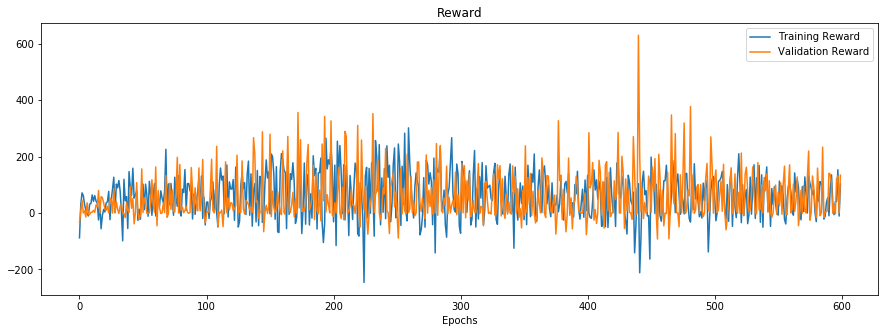

In [4]:
#Training
coloredlogs.install(level='DEBUG')
switch_k_backend_device() #switches to CPU (acc. to author faster than GPU)


if df2_train is not None:
    agent = Agent(window_size*2, pretrained=False, model_name=model_name)
else:
    agent = Agent(window_size, pretrained=False, model_name=model_name)



reslist_t =[] # Train Reward for plotting
reslist_v = [] # Val Reward for plotting


for i in range(1, ep_count + 1): 
    #shuffle columns of training data
    cols = df_train.columns.values
    np.random.shuffle(cols)
    df_train_s = df_train[cols]
    print(df_train_s.head())

    #print(cols)

    for column in df_train_s:
        #create list
        df_train_list = list(df_train_s[column])
        df_val_list = list(df_val[column])

        #dft = df_test.rename(columns={column: 'actual'})
        initial_offset = df_train_list[1] - df_train_list[0]
                
        train_result = train_model(agent, i, df_train_list, df2_train_list, ep_count=ep_count,
                                batch_size=batch_size, window_size=window_size)
        val_result, _ = evaluate_model(agent, df_val_list, df2_val_list, window_size, debug)
        show_train_result(train_result, val_result, initial_offset)
      
        reslist_t.append(train_result[2]) # append reward of training
        reslist_v.append(val_result)
        
# Plotting Training History  
plt.figure(figsize = (15,5))
plt.plot(reslist_t, label = "Training Reward");
plt.plot(reslist_v, label = "Validation Reward");
plt.title("Reward")
plt.xlabel("Epochs")
plt.legend()
plt.show()



## Visualization of actions taken by Trading Bot

In [3]:
def visualize(df, history):
    # add history to dataframe
    position = [history[0][0]] + [x[0] for x in history]
    actions = ['HOLD'] + [x[1] for x in history]
    df['position'] = position
    df['action'] = actions
    
    #alt.Chart(df.reset_index()).mark_line().encode(x='index')
    
    # specify y-axis scale for stock prices
    scale = alt.Scale(domain=(min(min(df['actual']), min(df['position'])) - 50, max(max(df['actual']), max(df['position'])) + 50), clamp=True)
    
    # plot a line chart for stock positions
    actual = alt.Chart(df.reset_index()).mark_line(
        color='green',
        opacity=0.5
    ).encode(
        x='Date:T', #'date:T'
        y=alt.Y('position', axis=alt.Axis(format='$.2f', title='Price'), scale=scale)
    ).interactive(
        bind_y=False
    )
    
    # plot the BUY and SELL actions as points
    points = alt.Chart(df.reset_index()).transform_filter(
        alt.datum.action != 'HOLD'
    ).mark_point(
        filled=True
    ).encode(
        x=alt.X('Date:T', axis=alt.Axis(title='Date')),
        y=alt.Y('position', axis=alt.Axis(format='$.2f', title='Price'), scale=scale),
        color='action'
        #color=alt.Color('action', scale=alt.Scale(range=['blue', 'red']))
    ).interactive(bind_y=False)

    # merge the two charts
    chart = alt.layer(actual, points, title="your stock").properties(height=300, width=1000)
    
    return chart

## Plotting the evaluation actions

## Testing the Model
__Select correct model for Testing! (test model not linked to trained model)__

### Load different types of stocks in model:
 - Growth: Adobe (ADBE), Apple (AAPL)
 - Cyclical: Royal Caribbean (RCL)
 - Slow and low dividend: Costco (COST)
 - Turnaround: A&F (ANF)
 - Other: Gold
 
### Load generated data
  - Sin function
  - Random Data
 
 

<Figure size 432x288 with 0 Axes>

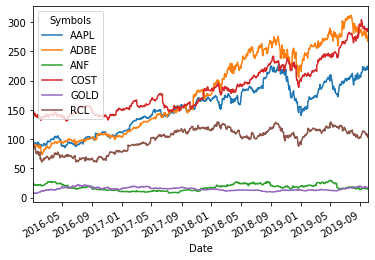

In [4]:
# Loading Test Data
# Setting Start and Enddate for Validation


start_test = datetime.datetime(2016, 1, 1)
end_test = datetime.datetime.now()

# Load Test Data

# Load several stocks
df_test = web.DataReader(['ADBE', 'AAPL', 'RCL', 'COST', 'ANF', 'GOLD'],'yahoo',
                               start=start_test, 
                               end=end_test)['Adj Close']

#Add random column for testing
#df_test['random']=np.random.randint(1,100,df_test.shape[0])
#df_test['sine']=50+50*np.sin(np.linspace(1,100,df_test.shape[0]))

# define second data input
df2_test = web.DataReader('GOLD','yahoo',
                               start=start_test, end=end_test)

# Convert df2_test to list
df2_test_list = list(df2_test['Adj Close'])


plt.figure();
df_test.plot();


In [ ]:
# Loop over all Models and test them
# If window size does not fit, pass and try next model



for models in os.listdir("models/"):

    
    #model_name = 'model_w15v2_40'
    model_name = models
    
    # Init Model
    window_size = 10

    try: 
        # Initialize Agent
        if df2_test_list is not None:
            agent = Agent(window_size*2, pretrained=True, model_name=model_name)
        else:
            agent = Agent(window_size, pretrained=True, model_name=model_name)

        sum = 0
        # Loop over stocks
        for column in df_test:
            #print(column)
            #rename feature column name
            df_test_list = list(df_test[column])
            dft = df_test.rename(columns={column: 'actual'})
            initial_offset = df_test_list[1] - df_test_list[0]
            val_result, history = evaluate_model(agent, df_test_list, df2_test_list, window_size, debug)
            show_eval_result(model_name, val_result, initial_offset);
            chart = visualize(dft, history)
            sum = sum+val_result
            #print("Earnings of Model: ", model_name, " is: ", val_result)
            #chart.display()
        print("Sum of all earnings: ", model_name, " is: ", sum)
    except: 
        print(models, "wrong windowsize")
        pass

model_GOOGL_10 wrong windowsize
model_GOOGL_20 wrong windowsize
model_GOOGL_30 wrong windowsize


Earnings of :  AAPL  is:  108.35307312011719


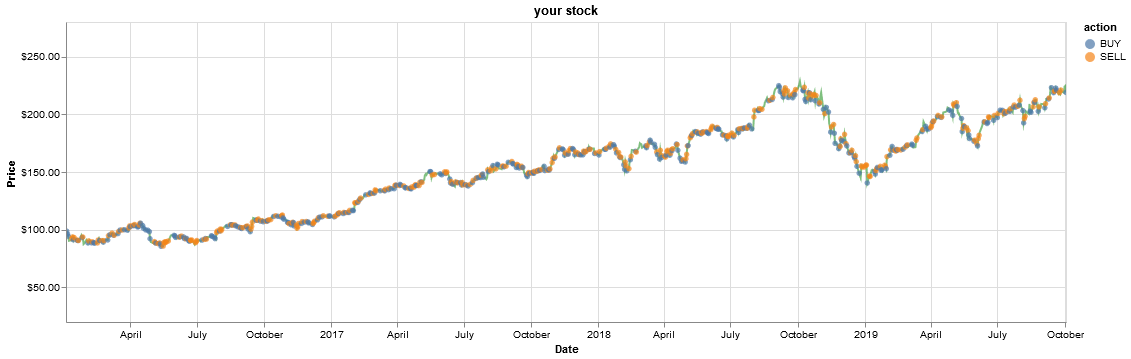

Earnings of :  ADBE  is:  435.42969512939453


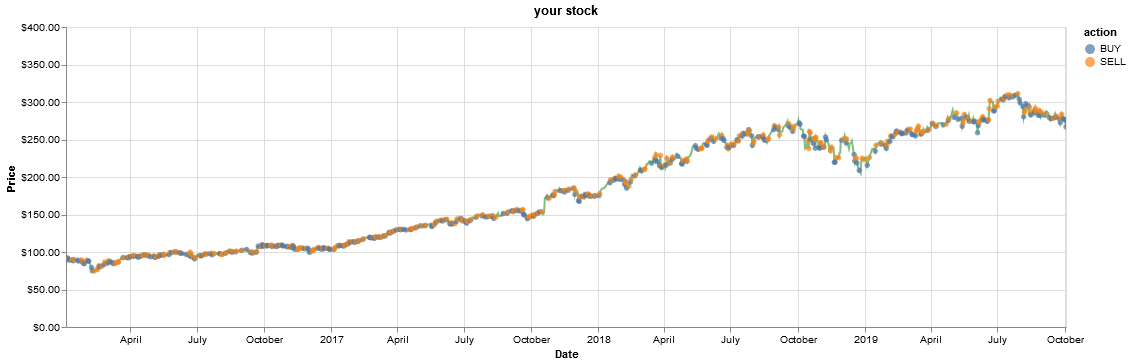

Earnings of :  ANF  is:  341.7534303665161


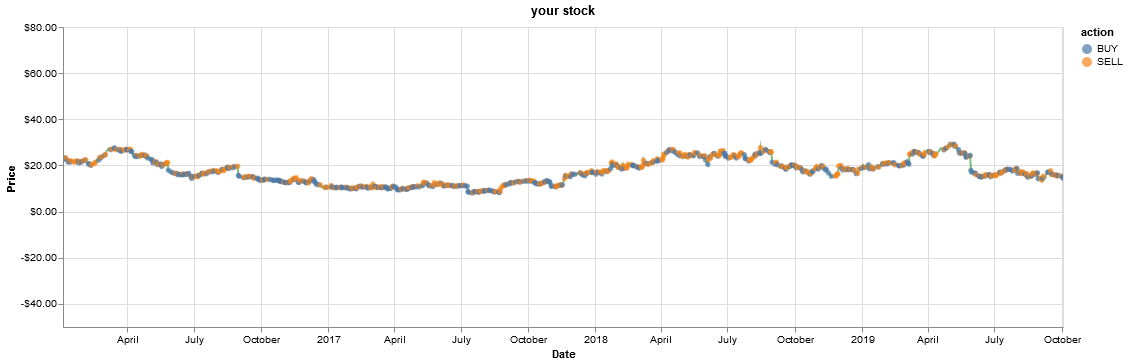

Earnings of :  COST  is:  134.74118041992188


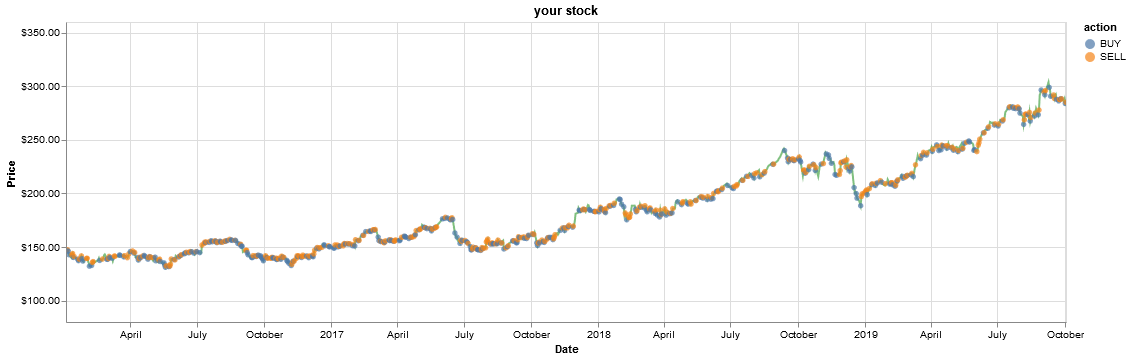

Earnings of :  GOLD  is:  144.29910850524902


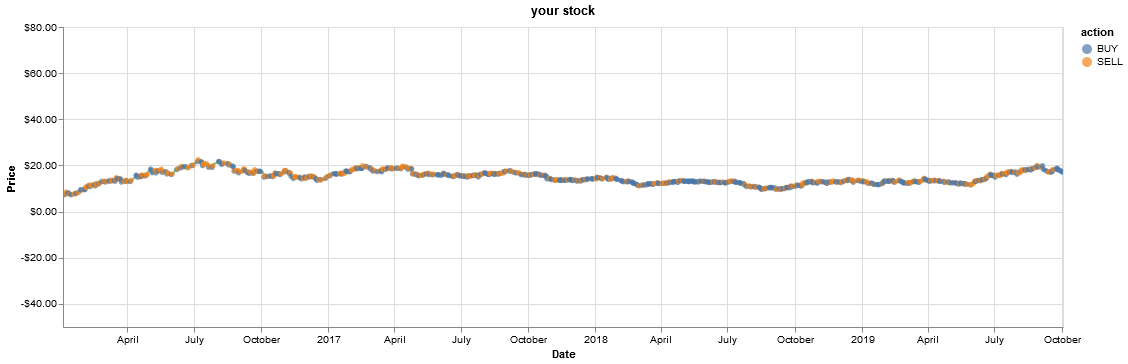

Earnings of :  RCL  is:  111.10065841674805


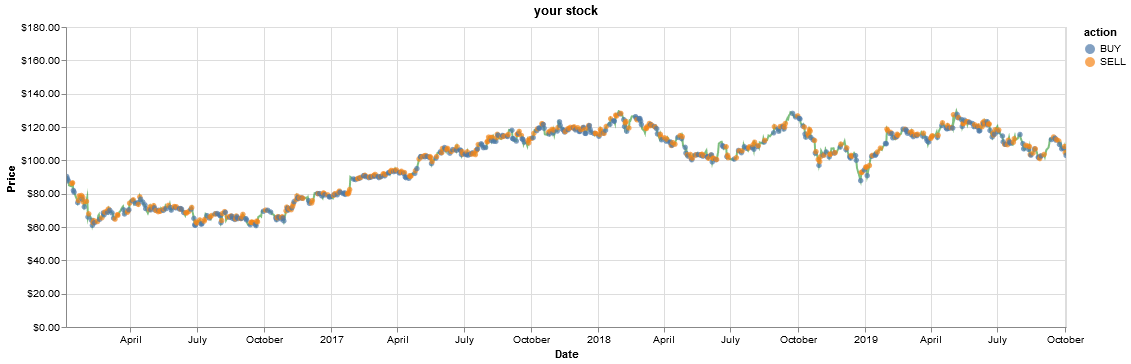

Sum of all earnings:  model_w15v2_30  is:  1275.6771459579468


In [9]:
# Test 1 model
    
#model_name = 'model_w15v2_40' model_Stefan_10
model_name = "model_w15v2_30"

# Init Model
window_size = 15


# Initialize Agent
if df2_test_list is not None:
    agent = Agent(window_size*2, pretrained=True, model_name=model_name)
else:
    agent = Agent(window_size, pretrained=True, model_name=model_name)

sum = 0
# Loop over stocks
for column in df_test:
    #print(column)
    #rename feature column name
    df_test_list = list(df_test[column])
    dft = df_test.rename(columns={column: 'actual'})
    initial_offset = df_test_list[1] - df_test_list[0]
    val_result, history = evaluate_model(agent, df_test_list, df2_test_list, window_size, debug)
    show_eval_result(model_name, val_result, initial_offset);
    chart = visualize(dft, history)
    sum = sum+val_result
    print("Earnings of : ", column, " is: ", val_result)
    chart.display()
print("Sum of all earnings: ", model_name, " is: ", sum)


In [10]:
dft.head(200)

Symbols,AAPL,ADBE,ANF,COST,GOLD,actual,position,action
Date,,,,,,,,
2016-01-04,98.742249,91.970001,23.073023,147.152557,7.478310,90.324860,90.324860,HOLD
2016-01-05,96.267815,92.339996,23.216385,147.512253,7.381814,88.852280,90.324860,BUY
2016-01-06,94.383888,91.019997,22.752563,146.147202,7.661649,87.720222,88.852280,BUY
2016-01-07,90.400467,89.110001,23.283852,142.799042,8.443253,85.069565,87.720222,BUY
2016-01-08,90.878479,87.849998,21.529758,140.299454,8.124820,84.471329,85.069565,HOLD
2016-01-11,92.350006,89.379997,21.816490,142.706802,7.864287,86.146400,84.471329,HOLD
2016-01-12,93.690300,89.820000,21.959852,143.942764,7.623052,86.532928,86.146400,SELL
2016-01-13,91.281494,88.300003,21.529758,140.308655,7.758143,81.949516,86.532928,SELL
2016-01-14,93.277916,89.800003,21.993586,141.286377,7.314269,80.900299,81.949516,BUY
